In [3]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.ma as ma
from astropy.table import Table
# from scipy.spatial import distance
# from scipy import spatial
# from scipy.spatial import KDTree
import time
import matplotlib.path as mpltPath
from pandas import DataFrame, read_csv
import pandas as pd 
from mpl_toolkits.mplot3d import Axes3D
import copy
#from matplotlib.patches import Circle, Wedge, Polygon
#from matplotlib.collections import PatchCollection


In [1]:
K_unc = df["ks_msigcom"].values
print(np.nanmean(K_unc))
G_flux = df["phot_g_mean_flux"]
G_flux_er = df["phot_g_mean_flux_error"]
SNR = G_flux/G_flux_er
print(np.nanmean(SNR))
plt.hist(SNR)
plt.show()

NameError: name 'df' is not defined

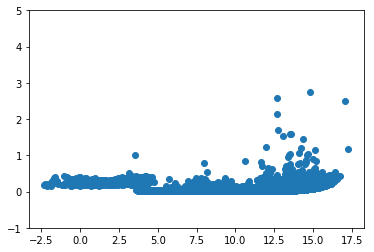

In [162]:
plt.scatter(Kmag,K_unc)
plt.ylim(-1,5)
plt.show()

In [4]:
file = r'Gaia_plx7_dr2.csv'
df = pd.read_csv(file)
df2 = df.columns.get_values()
df2.tolist()
#print('Succesfully Read in the Data')

/astromake/opt/python/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (96,122,130) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


['Unnamed: 0',
 'solution_id',
 'designation',
 'source_id',
 'random_index',
 'ref_epoch',
 'ra',
 'ra_error',
 'dec',
 'dec_error',
 'parallax',
 'parallax_error',
 'parallax_over_error',
 'pmra',
 'pmra_error',
 'pmdec',
 'pmdec_error',
 'ra_dec_corr',
 'ra_parallax_corr',
 'ra_pmra_corr',
 'ra_pmdec_corr',
 'dec_parallax_corr',
 'dec_pmra_corr',
 'dec_pmdec_corr',
 'parallax_pmra_corr',
 'parallax_pmdec_corr',
 'pmra_pmdec_corr',
 'astrometric_n_obs_al',
 'astrometric_n_obs_ac',
 'astrometric_n_good_obs_al',
 'astrometric_n_bad_obs_al',
 'astrometric_gof_al',
 'astrometric_chi2_al',
 'astrometric_excess_noise',
 'astrometric_excess_noise_sig',
 'astrometric_params_solved',
 'astrometric_primary_flag',
 'astrometric_weight_al',
 'astrometric_pseudo_colour',
 'astrometric_pseudo_colour_error',
 'mean_varpi_factor_al',
 'astrometric_matched_observations',
 'visibility_periods_used',
 'astrometric_sigma5d_max',
 'frame_rotator_object_type',
 'matched_observations',
 'duplicated_source'

In [5]:
# GAIA bands
Gmag = df["phot_g_mean_mag"].values
GBmag = df["phot_bp_mean_mag"].values
GRmag = df["phot_rp_mean_mag"].values
# 2MASS bands
Jmag = df["j_m"].values
Hmag = df["h_m"].values
Kmag = df["ks_m"].values
# SDSS Bands
# u_mag = df["u_mag"].values
# g_mag = df["g_mag"].values
# r_mag = df["r_mag"].values
# i_mag = df["i_mag"].values
# z_mag = df["z_mag"].values
# Other Important Data
plx = df["parallax"].values
Dist = 1000./plx

In [6]:
def AbsoluteMagnitudes(plx,GBmag,GRmag,Gmag,Jmag,Hmag,Kmag,umag,gmag,rmag,imag,zmag):
    #Calculates the absolute magnitudes of the stars
    #Read in parallax and apparent magnitude from each band
    
    #Variables Read In
    #plx: column of parallaxes
    #GBmag: column of magnitudes in GB
    #GRmag: column of magnitudes in GR
    #Gmag: column of magnitudes in G
    #Jmag: column of magnitudes in J
    #Kmag: column of magnitudes in K
    #Hmag: column of magnitudes in H
    #umag: column of magnitudes in u
    #gmag: column of magnitudes in g
    #rmag: column of magnitudes in r
    #imag: column of magnitudes in i
    #zmag: column of magnitudes in z
    
    #Variables Returned
    #plx: column of parallaxes
    #GBmags: numpy array of absolute magnitudes in GB
    #GRmags: numpy array of absolute magnitudes in GR
    #Gmags: numpy array of absolute magnitudes in G
    #Jmags: numpy array of absolute magnitudes in J
    #Hmags: numpy array of absolute magnitudes in H
    #Kmags: numpy array of absolute magnitudes in K
    #umags: numpy array of absolute magnitudes in u
    #gmags: numpy array of absolute magnitudes in g
    #rmags: numpy array of absolute magnitudes in r
    #imags: numpy array of absolute magnitudes in i
    #zmags: numpy array of absolute magnitudes in z
        
    
    #create arrays for absolute magnitude
    Dist = np.array([])
    GBmags = np.array([])
    GRmags = np.array([])
    Gmags = np.array([])
    Jmags = np.array([])
    Hmags = np.array([])
    Kmags = np.array([])
    umags = np.array([])
    gmags = np.array([])
    rmags = np.array([])
    imags = np.array([])
    zmags = np.array([])
    
    #calculate the distance of each star in parsecs
    Dist = 1000./plx
    
    #use the distance modulus formula to calculate the absolute magnitude for all the stars
    GBmags = GBmag - 5 * np.log10(Dist) + 5
    GRmags = GRmag - 5 * np.log10(Dist) + 5
    Gmags = Gmag - 5 * np.log10(Dist) + 5
    Jmags = Jmag - 5 * np.log10(Dist) + 5
    Hmags = Hmag - 5 * np.log10(Dist) + 5
    Kmags = Kmag - 5 * np.log10(Dist) + 5
    umags = umag - 5 * np.log10(Dist) + 5
    gmags = gmag - 5 * np.log10(Dist) + 5
    rmags = rmag - 5 * np.log10(Dist) + 5
    imags = imag - 5 * np.log10(Dist) + 5
    zmags = zmag - 5 * np.log10(Dist) + 5
    
    return Dist, GBmags,GRmags,Gmags,Jmags,Hmags,Kmags,umags,gmags,rmags,imags,zmags


In [7]:
def ColorClassification(Gmags,Kmags,colors):    
    #assign the stars into different categories based on G-K
    
    #Variables Read In
    #Gmags: numpy array of absolute magnitudes in G
    #Kmags: numpy array of absolute magnitudes in K
    #colors: list or array of values of G-K in increasing order
    
    #Variables Returned
    #color: numpy array that indicates the category of G-K that each star belongs to
    
    #caclculate the values of G-K for all stars
    
    G_K = Gmags-Kmags
    
    #create array to hold the G-K color categories 
    color = np.ones(len(G_K))*1000
    
    #compare the value of G-K for each star to the categories and assign a corresponding
    #value for the category in the color array
    for i in range(len(colors)):
        for j in range(len(G_K)):
            if (i == 0):
                if (G_K[j] <= colors[i]):
                    color[j] = colors[i]
            elif(G_K[j] <= colors[i] and G_K[j] > colors[i-1]):
                color[j] = colors[i]
    return color

In [8]:
def CreateTemplates(color,colors,Gmags,Kmags,GB_mags=[999],GR_mags=[999],J_mags=[999],H_mags=[999],umags=[999],gmags=[999],rmags=[999],imags=[999],zmags=[999]):
    #For each category of G-K, a template is created of the absolute magnitudes of the stars and their color indices 
    #calculated with bands of different magnitudes
    # ** Gmags and Kmags is REQUIRED ** 
    #Variables Read In:
    #color: numpy array that indicates the category of G-K that each star belongs to
    #colors: list or array of values of G-K in increasing order
    #GBmags: numpy array of absolute magnitudes in GB
    #GRmags: numpy array of absolute magnitudes in GR
    #Gmags: numpy array of absolute magnitudes in G
    #Jmags: numpy array of absolute magnitudes in J
    #Hmags: numpy array of absolute magnitudes in H 
    #Kmags: numpy array of absolute magnitudes in K
    #umags: numpy array of absolute magnitudes in u
    #gmags: numpy array of absolute magnitudes in g
    #rmags: numpy array of absolute magnitudes in r
    #imags: numpy array of absolute magnitudes in i
    #zmags: numpy array of absolute magnitudes in z
    
    #Variables Returned: 
    #stars: array of the number of stars in each category of G-K
    #color_mags: array of the color indices at each wavelength for all of the categories of G-K
    #color_std: array of the standard deviation of color indices at each wavelength for all of the categories of G-K
    #color_std_err: array of the standard deviation error of thecolor indices at each wavelength for all of the categories of G-K
    #abs_color_mags: array of the average absolute magnitudes in each band for all of the categories of G-K
    #abs_color_std: array of the standard deviation of absolute magnitudes in each band for all of the categories of G-K
    #abs_color_std_err: array of the standard deviation error of absolute magnitudes in each band for all categores of G-K
    
    if(len(GB_mags) < 2):
        GB_mags = np.ones(len(Gmags))*np.nan
    if(len(GR_mags) < 2):
        GR_mags = np.ones(len(Gmags))*np.nan
    if(len(J_mags) < 2):
        J_mags = np.ones(len(Gmags))*np.nan
    if(len(H_mags) < 2):
        H_mags = np.ones(len(Gmags))*np.nan
    if(len(umags) < 2):
        umags = np.ones(len(Gmags))*np.nan
    if(len(gmags) < 2):
        gmags = np.ones(len(Gmags))*np.nan
    if(len(zmags) < 2):
        zmags = np.ones(len(Gmags))*np.nan
    if(len(imags) < 2):
        imags = np.ones(len(Gmags))*np.nan
    if(len(rmags) < 2):
        rmags = np.ones(len(Gmags))*np.nan
    
    
    #Calculate the values of G-K for each star
    G_K = Gmags-Kmags
    
    #create array to hold the number of stars in each template: 
    stars = np.array([])
    
    for c in colors:
        #create array of values for color indices and absolute magnitudes
        G_GB_array = np.array([])
        G_GR_array = np.array([])
        G_J_array = np.array([])
        G_H_array = np.array([])
        G_K_array = np.array([])
        G_u_array = np.array([])
        G_g_array = np.array([])
        G_r_array = np.array([])
        G_i_array = np.array([])
        G_z_array = np.array([])
        GB = np.array([])
        GR = np.array([])
        G = np.array([])
        J = np.array([])
        H = np.array([])
        K = np.array([])
        u = np.array([])
        g = np.array([])
        r = np.array([])
        i_m = np.array([])
        z = np.array([])
        star_count = 0
        #fill arrays with values if the values are part of the color category
        for i in range(len(Gmags)):
            if (color[i] == c):
                
                G_GB_array = np.append(G_GB_array,Gmags[i]-GB_mags[i])
                G_GR_array = np.append(G_GR_array,Gmags[i]-GR_mags[i])
                G_J_array = np.append(G_J_array,Gmags[i]-J_mags[i])
                G_H_array = np.append(G_H_array,Gmags[i]-H_mags[i])
                G_K_array = np.append(G_K_array,Gmags[i]-Kmags[i])
                G_u_array = np.append(G_u_array,Gmags[i]-umags[i])
                G_g_array = np.append(G_g_array,Gmags[i]-gmags[i])
                G_r_array = np.append(G_r_array,Gmags[i]-rmags[i])
                G_i_array = np.append(G_i_array,Gmags[i]-umags[i])
                G_z_array = np.append(G_z_array,Gmags[i]-zmags[i])
                GB = np.append(GB,GB_mags[i])
                GR = np.append(GR,GR_mags[i])
                G = np.append(G,Gmags[i])
                J = np.append(J,J_mags[i])
                H = np.append(H,H_mags[i])
                K = np.append(K,Kmags[i])
                u = np.append(u,umags[i])
                g = np.append(g,umags[i])
                r = np.append(r,rmags[i])
                i_m = np.append(i_m,imags[i])
                z = np.append(z,zmags[i])
                star_count = star_count +1
        #number of stars per color
        stars = np.append(stars,star_count)
        #relative SED
        mag_array = [np.nanmean(G_u_array),np.nanmean(G_g_array), np.nanmean(G_GB_array),\
                     np.nanmean(G_r_array),np.nanmean(G_i_array), np.nanmean(G_GR_array), \
                     np.nanmean(G_z_array),np.nanmean(G_J_array), np.nanmean(G_H_array), \
                     np.nanmean(G_K_array)]
        std_array = [np.nanstd(G_u_array),np.nanstd(G_g_array), np.nanstd(G_GB_array),\
                     np.nanstd(G_r_array),np.nanstd(G_i_array), np.nanstd(G_GR_array), \
                     np.nanstd(G_z_array),np.nanstd(G_J_array), np.nanstd(G_H_array), \
                     np.nanstd(G_K_array)]
        #absolute SED
        mag_array2 = [np.nanmean(u), np.nanmean(g), np.nanmean(GB), \
                      np.nanmean(r), np.nanmean(G), np.nanmean(i), \
                      np.nanmean(GR), np.nanmean(z), np.nanmean(J), \
                      np.nanmean(H), np.nanmean(K)]
        std_array2 = [np.nanstd(u), np.nanstd(g), np.nanstd(GB), \
                      np.nanstd(r), np.nanstd(G), np.nanstd(i_m), \
                      np.nanstd(GR), np.nanstd(z), np.nanstd(J), \
                      np.nanstd(H), np.nanstd(K)]
        #calculate standard deviation error
        val = np.sqrt(len(G_u_array))
        std_array3 = std_array/val
        val2 = np.sqrt(len(u))
        std_array4 = std_array2/val2
        #stack SEDs
        if (c == colors[0]):
            
            color_mags = np.array(mag_array)
            color_std = np.array(std_array)
            color_std_err = np.array(std_array3)
            abs_color_mags = np.array(mag_array2)
            abs_color_std = np.array(std_array2)
            abs_color_std_err = np.array(std_array4)
        else:
            #print(len(color_mags),len(mag_array))
            color_mags = np.vstack((color_mags,mag_array))
            color_std = np.vstack((color_std,std_array))
            color_std_err = np.vstack((color_std_err,std_array3))
            #print('\n',len(abs_color_mags),len(mag_array2))
            abs_color_mags = np.vstack((abs_color_mags, mag_array2))
            abs_color_std = np.vstack((abs_color_mags, std_array2))
            abs_color_std_err = np.vstack((abs_color_std_err,std_array4))
            #A[~np.isnan(A)])
    #print((color_mags))
#     color_mags = color_mags[~np.isnan(color_mags)]
#     #print(len(color_mags))
#     color_std = color_std[~np.isnan(color_std)]
#     color_std_err = color_std_err[~np.isnan(color_std_err)]
#     abs_color_mags = abs_color_mags[~np.isnan(abs_color_mags)]
#     abs_color_std = abs_color_std[~np.isnan(abs_color_std)]
#     abs_color_std_err = abs_color_std_err[~np.isnan(abs_color_std_err)]
#     color_mags = np.reshape(color_mags, (-1, 10))
#     color_std = np.reshape(color_std, (-1, 10))
#     color_std_err = np.reshape(color_std_err, (-1, 10))
#     print(color_mags,'\n',abs_color_mags)
#     abs_color_mags = np.reshape(abs_color_mags, (-1, 11))
#     abs_color_std = np.reshape(abs_color_std, (-1, 11))
#     abs_color_std_err = np.reshape(abs_color_std_err, (-1, 11))
            
    return stars,color_mags,color_std,color_std_err,abs_color_mags,abs_color_std,abs_color_std_err

In [9]:
def CreatePlots(colors,abs_colors_mags,abs_color_std,color_mags,color_std):
    #create SED and Relative SED plots with the standard deviation as error 
    
    #Variables Read In:
    #colors: list or array of values of G-K in increasing order
    #wvl: list of colors that contain the wavlengths of the filters except for the G filter
    #wvl2: list of colors that contain the wavlengths of the filters
    #stars: array of the number of stars in each category of G-K
    #abs_color_mags: array of the average absolute magnitudes in each band for all of the categories of G-K
    #abs_color_std: array of the standard deviation of absolute magnitudes in each band for all of the categories of G-K
    #color_mags: array of the color indices at each wavelength for all of the categories of G-K
    #color_std: array of the standard deviation of color indices at each wavelength for all of the categories of G-K 
    
    #No variables are read out, running the function creates two plots
    
    wvl = [354,420,477,500,623,677,763,913,1250,1650,2170]
    wvl2 = [354,420,477,623,677,763,913,1250,1650,2170]
    new_wvl = []
    new_wvl2 = []
    for i in range(len(abs_color_mags[0])):
        if(str(abs_color_mags[0,i]) != 'nan'):
            new_wvl.append(wvl[i])
            
    for i in range(len(color_mags[0])):
        if(str(color_mags[0,i]) != 'nan'):
            new_wvl2.append(wvl2[i])
    #print(wvl,'\n',wvl2)
#     wvl = wvl[~np.isnan(wvl)]
#     wvl2 = wvl2[~np.isnan(wvl2)]
    
    
    #plot average absolute magnitude in each filter for each value of G-K 
    ax = plt.subplot(111)
    for i in range(len(colors)):
        #color_mags = color_mags[~np.isnan(color_mags)]
        acm = abs_color_mags[i,:]
        acs = abs_color_std[i,:]
        
        acm = acm[~np.isnan(acm)]
        acs = acs[~np.isnan(acs)]
        
        ax.errorbar(new_wvl, acm, yerr = acs, linestyle = '-', marker = 'o',label = str(colors[i]))
       ## ORIGINAL CODE
        #ax.errorbar(wvl, abs_color_mags[i,:], yerr = abs_color_std[i,:], linestyle = '-', marker = 'o',label = str(colors[i]))
    ax.set_xlabel('Effective Wavelength (nm)')
    ax.set_ylabel('Average Absolute Magnitude')
    ax.set_title('Spectral Energy Distribution')
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()
    
    #plot average color index in each filter for each value of G-K
    ax2 = plt.subplot(111)
    for i in range(len(colors)):
        acm = color_mags[i,:]
        acs = color_std[i,:]
        c = str(colors[i])
        acm = acm[~np.isnan(acm)]
        acs = acs[~np.isnan(acs)]
        #print(acm,'\n',new_wvl2)
        ax2.errorbar(new_wvl2, acm, yerr = acs, linestyle = '-', marker = 'o',label = str(colors[i]))
        
       
        #ax2.errorbar(wvl2, color_mags[i,:], yerr = color_std[i,:], linestyle = '-', marker = 'o',label = str(colors[i]))
    ax2.set_xlabel('Effective Wavelength (nm)')
    ax2.set_ylabel('Average Color Index')
    ax2.set_title('Spectral Energy Distribution')
    box2 = ax2.get_position()
    ax2.set_position([box2.x0, box2.y0, box2.width * 0.8, box2.height])
    ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()
    
    return

In [10]:
# # DEFINE HOW MANY TEMPLATES YOU WANT TO PLOT BASED ON G-K COLOR
# Gmags = Gmag - 5 * np.log10(Dist) + 5

# new_Gmag = []
# new_GBmag = []
# new_GRmag = []
# new_Jmag = []
# new_Hmag = []
# new_Kmag = []

# for i in range(len(Gmags)):
#     if(Gmags[i] < 7):
#         new_Gmag.append(Gmag[i])
#         new_GBmag.append(GBmag[i])
#         new_GRmag.append(GRmag[i])
#         new_Jmag.append(Jmag[i])
#         new_Hmag.append(Hmag[i])
#         new_Kmag.append(Kmag[i])
# new_Gmag = np.array(new_Gmag)
# new_GBmag = np.array(new_GBmag)
# new_GRmag = np.array(new_GRmag)
# new_Jmag = np.array(new_Jmag)
# new_Hmag = np.array(new_Hmag)
# new_Kmag = np.array(new_Kmag)
        
colors = np.arange(1,2,0.03) # EDIT THIS TO USE DESIRED NUMBER OF COLORS
#color = ColorClassification(new_Gmag,new_Kmag,colors)
color = ColorClassification(Gmag,Kmag,colors)


# stars,color_mags,color_std,color_std_err,abs_color_mags,abs_color_std,abs_color_std_err = \
# CreateTemplates(color,colors,new_Gmag,new_Kmag,GB_mags=new_GBmag,GR_mags=new_GRmag,J_mags=new_Jmag,H_mags=new_Hmag)


stars,color_mags,color_std,color_std_err,abs_color_mags,abs_color_std,abs_color_std_err = \
CreateTemplates(color,colors,Gmags=Gmag,Kmags=Kmag,GB_mags=GBmag,GR_mags=GRmag,J_mags=Jmag,H_mags=Hmag)

/astromake/opt/python/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:108: RuntimeWarning: Mean of empty slice
/astromake/opt/python/anaconda3/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1423: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/astromake/opt/python/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:111: RuntimeWarning: Mean of empty slice


In [13]:
print(len(colors))

CreatePlots(colors,abs_color_mags,abs_color_std,color_mags,color_std)

34


AssertionError: 

In [48]:
n =5
starBands = [new_Gmag[n],new_GBmag[n],new_GRmag[n],new_Jmag[n],new_Hmag[n],new_Kmag[n]]
print(starBands)

new_starBands = []
for i in range(len(starBands)):
    if(i == 0):
        G = starBands[i]
    else:
        G_X = G - starBands[i]
        new_starBands.append(G_X)
print(new_starBands)

[10.882441520690918, 11.388130187988279, 10.248380661010742, 9.5019998550415039, 9.074000358581543, 8.9209995269775391]
[-0.5056886672973615, 0.63406085968017578, 1.3804416656494141, 1.808441162109375, 1.9614419937133789]


In [53]:
l = np.array([np.nan,np.nan,np.nan])
#l = l[~np.isnan(l)]
print(np.nanmean(l))

nan


/astromake/opt/python/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice
  This is separate from the ipykernel package so we can avoid doing imports until


# StarFitting Function

In [10]:
# ONLY GAIA BANDS AND 2MASS BANDS
def StarFitting(starBands,color_mags,color_std):
    new_starBands = []
    for i in range(len(starBands)):
        if(i == 0):
            G = starBands[i]
        else:
            G_X = G - starBands[i]
            new_starBands.append(G_X)
    
    template_bands = []
    template_err = []
    for i in range(len(color_mags)):
        cm = color_mags[i,:]
        cm = cm[~np.isnan(cm)]
        cs = color_std[i,:]
        cs = cs[~np.isnan(cs)]
        template_bands.append(cm)
        template_err.append(cs)
    template_bands = np.array(template_bands)
    template_err = np.array(template_err)
    
    Chi2_vals = []
    for i in range(len(template_bands)):
        Chi2 = 0
        for j in range(len(new_starBands)):
            Chi2 = Chi2 + ((template_bands[i,j] - new_starBands[j])**2/(template_err[i,j])**2)
        Chi2 = Chi2/(len(new_starBands)-1)  # EDITED THIS LINE JUNE 7TH. GOT RID OF THE -1
        Chi2_vals.append(Chi2)
    Chi2_vals = np.array(Chi2_vals)
    
    red_Chi2 = []
    for i in range(len(Chi2_vals)):
        if(Chi2_vals[i] == np.min(Chi2_vals)):
            chi_val = Chi2_vals[i]
            
            red_Chi2.append(chi_val)
            best_fit = i
#             print('The best Template is '+ str((best_fit+1)) +' out of '+str(len(template_bands))+ ' templates')
#             print('Or ' + str(best_fit) + ' out of ' + str((len(template_bands)-1)))
    #print(best_fit)
    return best_fit, new_starBands, red_Chi2    

In [9]:
all_starBands = []
for i in range(len(Gmag)):
    if(Gmag[i] != np.nan and GBmag[i] != np.nan and GRmag[i] != np.nan and Jmag[i] \
       != np.nan and Hmag[i] != np.nan and Kmag[i] != np.nan and \
       (Gmag[i]-Kmag[i]) <=2.0 and (Gmag[i]-Kmag[i]) >= 1.0 and (Gmag[i] - Kmag[i]) != np.nan \
      and (Gmag[i]-Hmag[i]) != np.nan):
        
        all_starBands.append([Gmag[i],GBmag[i],GRmag[i],Jmag[i],Hmag[i],Kmag[i]])
all_starBands = np.array(all_starBands)
print(len(all_starBands[0]))

6


In [12]:
color = ColorClassification(all_starBands[:,0],all_starBands[:,5],colors)


# stars,color_mags,color_std,color_std_err,abs_color_mags,abs_color_std,abs_color_std_err = \
# CreateTemplates(color,colors,new_Gmag,new_Kmag,GB_mags=new_GBmag,GR_mags=new_GRmag,J_mags=new_Jmag,H_mags=new_Hmag)


stars,color_mags,color_std,color_std_err,abs_color_mags,abs_color_std,abs_color_std_err = \
CreateTemplates(color,colors,Gmags=all_starBands[:,0],Kmags=all_starBands[:,5],GB_mags=all_starBands[:,1],\
                GR_mags=all_starBands[:,2],J_mags=all_starBands[:,3],H_mags=all_starBands[:,4])

/astromake/opt/python/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:108: RuntimeWarning: Mean of empty slice
/astromake/opt/python/anaconda3/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1423: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/astromake/opt/python/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:111: RuntimeWarning: Mean of empty slice


In [17]:
star_bin_vals = []
temp_bin_vals = []
red_Chi2_vals = []

for i in range(len(all_starBands)):
    mags = copy.copy(color_mags)
    std = copy.copy(color_std)
    mags = mags[1:len(mags)]
    std = std[1:len(std)]
    starBands= np.array(all_starBands[i])
    starBands = starBands[~np.isnan(starBands)]
    if(len(starBands) == len(all_starBands[0])):
        #starBands = np.array(starBands)
        fit, new_starBand, red_Chi2 = StarFitting(starBands,mags,std)
        temp_bin_vals.append(colors[fit])
        red_Chi2_vals.append(red_Chi2)
        diff_vals = []
        for j in range(len(colors)):
            diff = abs(colors[j] - new_starBand[4])
            diff_vals.append(diff)

        for j in range(len(diff_vals)):
            if(diff_vals[j] == np.min(diff_vals)):
                star_bin_vals.append(colors[j])


In [31]:
print((temp_bin_vals[15]))
print((star_bin_vals[15]))

1.93
1.93


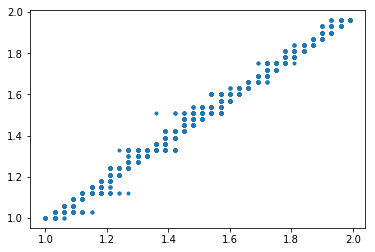

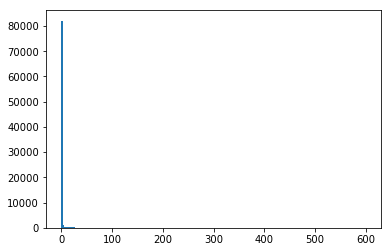

0.00119237768765


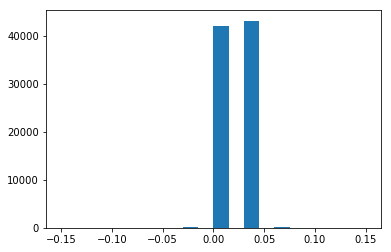

In [36]:

plt.plot(star_bin_vals,temp_bin_vals,'.')
plt.show()

red_Chi2_vals = np.array(red_Chi2_vals)
plt.hist(red_Chi2_vals[:,0],200)
plt.show()
print(np.min(red_Chi2_vals[:,0]))
star_bin_vals = np.array(star_bin_vals)
temp_bin_vals = np.array(temp_bin_vals)
diff = star_bin_vals - temp_bin_vals

plt.hist(diff,20)
plt.show()

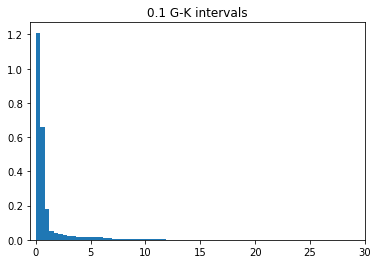

Average Reduced Chi2 Val: 1.25959241862
Median Reduced Chi2 Val: 0.416214103869
STD of Reduced Chi2 Val: 3.33696301491


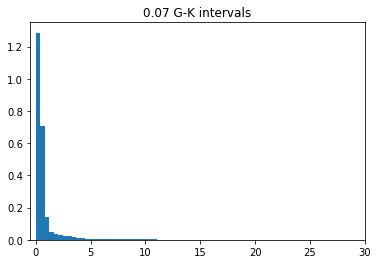

Average Reduced Chi2 Val: 1.09487917538
Median Reduced Chi2 Val: 0.380570872118
STD of Reduced Chi2 Val: 3.3337648876


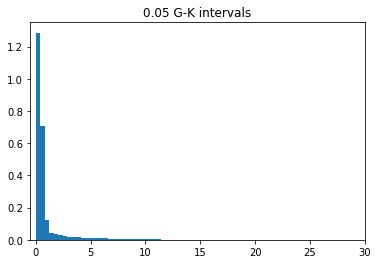

Average Reduced Chi2 Val: 1.16227407892
Median Reduced Chi2 Val: 0.381068868168
STD of Reduced CHi2 Val: 3.43854138419


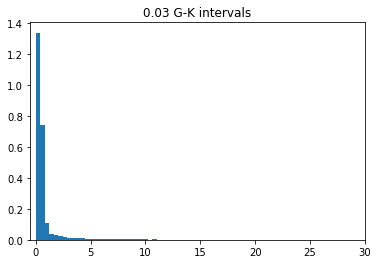

Average Reduced Chi2 Val: 1.04785069795
Median Reduced Chi2 Val: 0.359756314394
STD of Reduced Chi2 Val: 3.37811816912


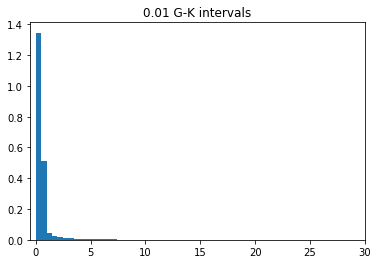

Average Reduced Chi2 Val: 0.711852828507
Median Reduced Chi2 Val: 0.32459427752
STD of Reduced Chi2 Val: 2.09296082767


In [99]:
red_Chi2_vals = np.array(red_Chi2_vals)
red_Chi2_vals_01 = copy.copy(red_Chi2_vals)

plt.hist(red_Chi2_vals_1[:,0],500,normed=True)
plt.xlim([-.5,30])
plt.title('0.1 G-K intervals')
plt.show()
print('Average Reduced Chi2 Val:', np.mean(red_Chi2_vals_1[:,0]))
print('Median Reduced Chi2 Val:', np.median(red_Chi2_vals_1[:,0]))
print('STD of Reduced Chi2 Val:', np.std(red_Chi2_vals_1[:,0]))

plt.hist(red_Chi2_vals_07[:,0],500,normed=True)
plt.xlim([-.5,30])
plt.title('0.07 G-K intervals')
plt.show()
print('Average Reduced Chi2 Val:', np.mean(red_Chi2_vals_07[:,0]))
print('Median Reduced Chi2 Val:', np.median(red_Chi2_vals_07[:,0]))
print('STD of Reduced Chi2 Val:', np.std(red_Chi2_vals_07[:,0]))

plt.hist(red_Chi2_vals_05[:,0],500,normed=True)
plt.xlim([-.5,30])
plt.title('0.05 G-K intervals')
plt.show()
print('Average Reduced Chi2 Val:', np.mean(red_Chi2_vals_05[:,0]))
print('Median Reduced Chi2 Val:', np.median(red_Chi2_vals_05[:,0]))
print('STD of Reduced CHi2 Val:', np.std(red_Chi2_vals_05[:,0]))

plt.hist(red_Chi2_vals_03[:,0],500,normed=True)
plt.xlim([-.5,30])
plt.title('0.03 G-K intervals')
plt.show()
print('Average Reduced Chi2 Val:', np.mean(red_Chi2_vals_03[:,0]))
print('Median Reduced Chi2 Val:', np.median(red_Chi2_vals_03[:,0]))
print('STD of Reduced Chi2 Val:', np.std(red_Chi2_vals_03[:,0]))

plt.hist(red_Chi2_vals_01[:,0],500,normed=True)
plt.xlim([-.5,30])
plt.title('0.01 G-K intervals')
plt.show()
print('Average Reduced Chi2 Val:', np.mean(red_Chi2_vals_01[:,0]))
print('Median Reduced Chi2 Val:', np.median(red_Chi2_vals_01[:,0]))
print('STD of Reduced Chi2 Val:', np.std(red_Chi2_vals_01[:,0]))

 # **Comparing Reduced Chi2 value for each G-K Interval**

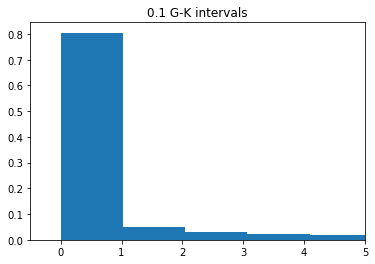

Average Reduced Chi2 Val: 1.25959241862
Median Reduced Chi2 Val: 0.416214103869
STD of Reduced Chi2 Val: 3.33696301491


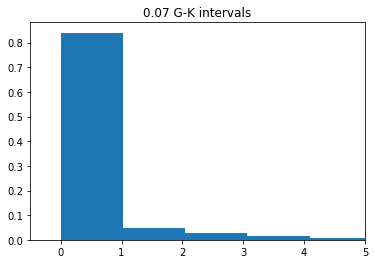

Average Reduced Chi2 Val: 1.09487917538
Median Reduced Chi2 Val: 0.380570872118
STD of Reduced Chi2 Val: 3.3337648876


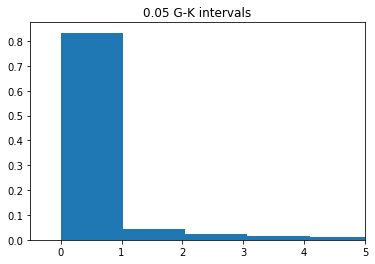

Average Reduced Chi2 Val: 1.16227407892
Median Reduced Chi2 Val: 0.381068868168
STD of Reduced CHi2 Val: 3.43854138419


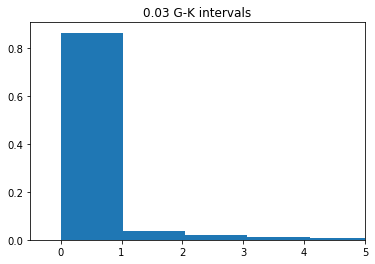

Average Reduced Chi2 Val: 1.04785069795
Median Reduced Chi2 Val: 0.359756314394
STD of Reduced Chi2 Val: 3.37811816912


In [195]:
# red_Chi2_vals = np.array(red_Chi2_vals)
# red_Chi2_vals_07 = copy.copy(red_Chi2_vals)

plt.hist(red_Chi2_vals_1[:,0],200,normed=True)
plt.xlim([-.5,5])
plt.title('0.1 G-K intervals')
plt.show()
print('Average Reduced Chi2 Val:', np.mean(red_Chi2_vals_1[:,0]))
print('Median Reduced Chi2 Val:', np.median(red_Chi2_vals_1[:,0]))
print('STD of Reduced Chi2 Val:', np.std(red_Chi2_vals_1[:,0]))

plt.hist(red_Chi2_vals_07[:,0],200,normed=True)
plt.xlim([-.5,5])
plt.title('0.07 G-K intervals')
plt.show()
print('Average Reduced Chi2 Val:', np.mean(red_Chi2_vals_07[:,0]))
print('Median Reduced Chi2 Val:', np.median(red_Chi2_vals_07[:,0]))
print('STD of Reduced Chi2 Val:', np.std(red_Chi2_vals_07[:,0]))

plt.hist(red_Chi2_vals_05[:,0],200,normed=True)
plt.xlim([-.5,5])
plt.title('0.05 G-K intervals')
plt.show()
print('Average Reduced Chi2 Val:', np.mean(red_Chi2_vals_05[:,0]))
print('Median Reduced Chi2 Val:', np.median(red_Chi2_vals_05[:,0]))
print('STD of Reduced CHi2 Val:', np.std(red_Chi2_vals_05[:,0]))

plt.hist(red_Chi2_vals_03[:,0],200,normed=True)
plt.xlim([-.5,5])
plt.title('0.03 G-K intervals')
plt.show()
print('Average Reduced Chi2 Val:', np.mean(red_Chi2_vals_03[:,0]))
print('Median Reduced Chi2 Val:', np.median(red_Chi2_vals_03[:,0]))
print('STD of Reduced Chi2 Val:', np.std(red_Chi2_vals_03[:,0]))


# **Plots using G-K color ranges of 0.3 to 3.0 using 0.1 G-K sub-intervals**

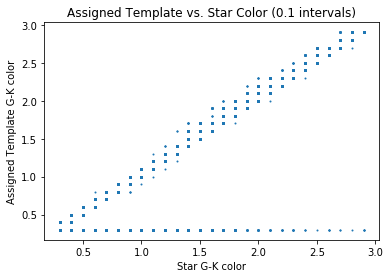

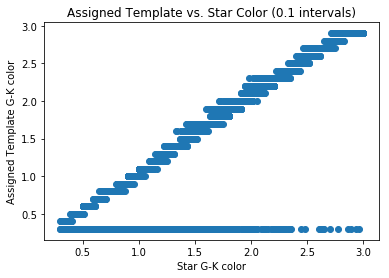

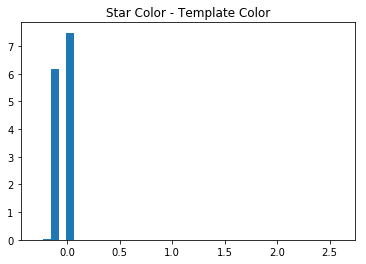

Mean: -0.0401077935458


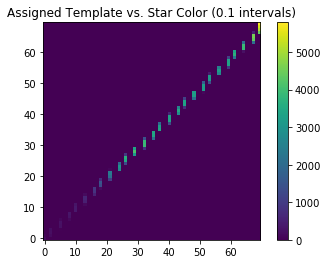

In [61]:
# DEFINE AND COPY ARRAYS BEING CREATED IN SCRIPT ABOVE. ENSURE YOU CHANGE THE NAME OF THE COPIED VARIABLE
# star_bin_vals = np.array(star_bin_vals)
# temp_bin_vals = np.array(temp_bin_vals)

# star_bin_vals_1 = copy.copy(star_bin_vals)
# temp_bin_vals_1 = copy.copy(temp_bin_vals) # KEEP THESE 4 LINES COMMENTED OUT UNLESS BEING USED

# PLOT CURVE RELATING STAR COLOR AND ASSIGNED TEMPLATE COLOR WHERE STAR COLOR IS DIGITIZED
plt.scatter(star_bin_vals_1,temp_bin_vals_1,s=1.0)
plt.title('Assigned Template vs. Star Color (0.1 intervals)')
plt.xlabel('Star G-K color')
plt.ylabel('Assigned Template G-K color')
plt.show()

# CREATING SAME CURVE WHERE STAR COLOR IS NOT DIGITIZED
diff_1 = []
for i in range(len(all_starBands)):
    starBands= np.array(all_starBands[i])
    starBands = starBands[~np.isnan(starBands)]
    if(len(starBands) == len(all_starBands[0])):
        diff_1.append(starBands[0] - starBands[5])
diff_1 = np.array(diff_1)


plt.scatter(diff_1,temp_bin_vals_1)
plt.title('Assigned Template vs. Star Color (0.1 intervals)')
plt.xlabel('Star G-K color')
plt.ylabel('Assigned Template G-K color')
plt.show()

# CREATING HISTOGRAM OF THE DIFFERENCE BETWEEN STAR COLOR AND TEMPLATE COLOR
difference_1 = star_bin_vals_1-temp_bin_vals_1

bins_1 = plt.hist(difference_1,40,normed=True)
plt.title('Star Color - Template Color (0.1 intervals)')
#plt.xlim([-0.2,0.75])
plt.show()
print('Mean:',np.mean(difference_1))

# CREATING HEATMAP OF THE FIRST TWO PLOTS ABOVE
heatmap, xedges, yedges = np.histogram2d(star_bin_vals_1, diff_1, bins=70)
plt.imshow(heatmap.T, origin='lower')
plt.title('Assigned Template vs. Star Color (0.1 intervals)')
plt.colorbar()
plt.show()

# **Plots using G-K color ranges of 0.3 to 3.0 using 0.07 G-K sub-intervals**

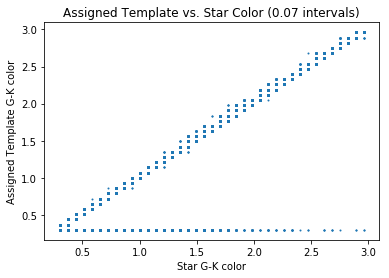

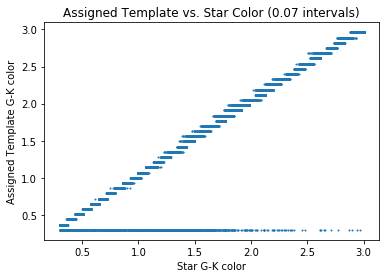

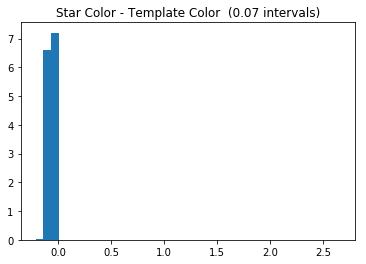

Mean: -0.0277217352586


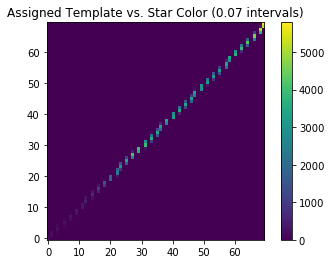

In [64]:
# DEFINE AND COPY ARRAYS BEING CREATED IN SCRIPT ABOVE. ENSURE YOU CHANGE THE NAME OF THE COPIED VARIABLE
# star_bin_vals = np.array(star_bin_vals)
# temp_bin_vals = np.array(temp_bin_vals)

# star_bin_vals_07 = copy.copy(star_bin_vals)
# temp_bin_vals_07 = copy.copy(temp_bin_vals) #KEEP THESE 4 LINES COMMENTED OUT UNLESS BEING USED

# PLOT CURVE RELATING STAR COLOR AND ASSIGNED TEMPLATE COLOR WHERE STAR COLOR IS DIGITIZED
plt.scatter(star_bin_vals_07,temp_bin_vals_07,s=1.0)
plt.title('Assigned Template vs. Star Color (0.07 intervals)')
plt.xlabel('Star G-K color')
plt.ylabel('Assigned Template G-K color')
plt.show()

# CREATING SAME CURVE WHERE STAR COLOR IS NOT DIGITIZED
diff_07 = []
for i in range(len(all_starBands)):
    starBands= np.array(all_starBands[i])
    starBands = starBands[~np.isnan(starBands)]
    if(len(starBands) == len(all_starBands[0])):
        diff_07.append(starBands[0] - starBands[5])
diff_07 = np.array(diff_07)


plt.scatter(diff_07,temp_bin_vals_07,s=1.0)
plt.title('Assigned Template vs. Star Color (0.07 intervals)')
plt.xlabel('Star G-K color')
plt.ylabel('Assigned Template G-K color')
plt.show()

# CREATING HISTOGRAM OF THE DIFFERENCE BETWEEN STAR COLOR AND TEMPLATE COLOR
difference_07 = star_bin_vals_07-temp_bin_vals_07

bins_07 = plt.hist(difference_07,40,normed=True)
plt.title('Star Color - Template Color  (0.07 intervals)')
#plt.xlim([-0.2,0.75])
plt.show()
print('Mean:',np.mean(difference_07))
# CREATING HEATMAP OF THE FIRST TWO PLOTS ABOVE
heatmap, xedges, yedges = np.histogram2d(star_bin_vals_07, diff_07, bins=70)
plt.imshow(heatmap.T, origin='lower')
plt.title('Assigned Template vs. Star Color (0.07 intervals)')
plt.colorbar()
plt.show()

# **Plots using G-K color ranges of 0.3 to 3.0 using 0.05 G-K sub-intervals**

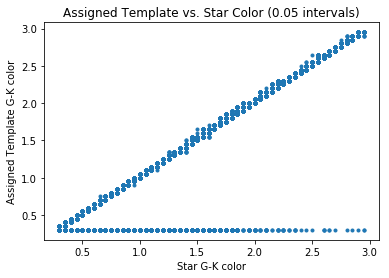

ValueError: x and y must have same first dimension, but have shapes (85458,) and (193147,)

In [90]:
# DEFINE AND COPY ARRAYS BEING CREATED IN SCRIPT ABOVE. ENSURE YOU CHANGE THE NAME OF THE COPIED VARIABLE
# star_bin_vals = np.array(star_bin_vals)
# temp_bin_vals = np.array(temp_bin_vals)

# star_bin_vals_05 = copy.copy(star_bin_vals)
# temp_bin_vals_05 = copy.copy(temp_bin_vals) # KEEP THESE 4 LINES ABOVE COMMENTED OUT UNLESS BEING USED

# PLOT CURVE RELATING STAR COLOR AND ASSIGNED TEMPLATE COLOR WHERE STAR COLOR IS DIGITIZED
plt.plot(star_bin_vals_05,temp_bin_vals_05,'.')
plt.title('Assigned Template vs. Star Color (0.05 intervals)')
plt.xlabel('Star G-K color')
plt.ylabel('Assigned Template G-K color')
plt.show()

# CREATING SAME CURVE WHERE STAR COLOR IS NOT DIGITIZED
diff_05 = []
for i in range(len(all_starBands)):
    starBands= np.array(all_starBands[i])
    starBands = starBands[~np.isnan(starBands)]
    if(len(starBands) == len(all_starBands[0])):
        diff_05.append(starBands[0] - starBands[5])
diff_05 = np.array(diff_05)


plt.plot(diff_05,temp_bin_vals_05,'.')
plt.title('Assigned Template vs. Star Color (0.05 intervals)')
plt.xlabel('Star G-K color')
plt.ylabel('Assigned Template G-K color')
plt.show()

# CREATING HISTOGRAM OF THE DIFFERENCE BETWEEN STAR COLOR AND TEMPLATE COLOR
difference_05 = star_bin_vals_05-temp_bin_vals_05

bins_05 = plt.hist(difference_05,40,normed=True)
plt.title('Star Color - Template Color  (0.05 intervals)')
#plt.xlim([-0.2,0.75])
plt.show()
print('Mean:',np.mean(difference_05))
print('Standard Deviation:', np.std(difference_05))

# CREATING HEATMAP OF THE FIRST TWO PLOTS ABOVE
heatmap, xedges, yedges = np.histogram2d(star_bin_vals_05, diff_05, bins=70)
plt.imshow(heatmap.T, origin='lower')
plt.title('Assigned Template vs. Star Color (0.05 intervals)')
plt.colorbar()
plt.show()

# **Plots using G-K color ranges of 0.3 to 3.0 using 0.03 G-K sub-intervals**

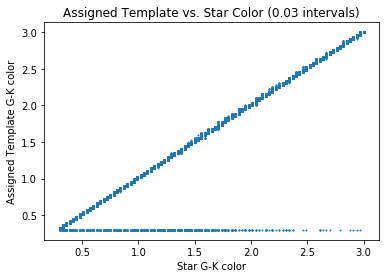

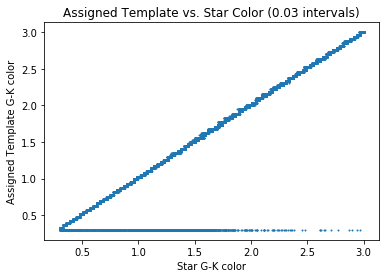

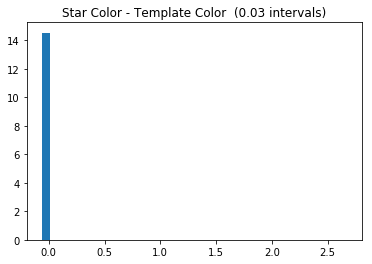

Mean: -0.00871605564674


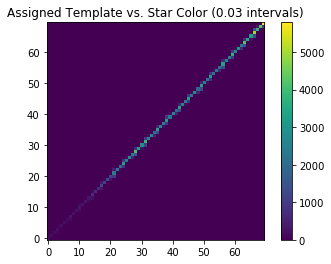

In [51]:
# DEFINE AND COPY ARRAYS BEING CREATED IN SCRIPT ABOVE. ENSURE YOU CHANGE THE NAME OF THE COPIED VARIABLE
star_bin_vals = np.array(star_bin_vals)
temp_bin_vals = np.array(temp_bin_vals)

star_bin_vals_03 = copy.copy(star_bin_vals)
temp_bin_vals_03 = copy.copy(temp_bin_vals) #KEEP THESE 4 LINES COMMENTED OUT UNLESS BEING USED

# PLOT CURVE RELATING STAR COLOR AND ASSIGNED TEMPLATE COLOR WHERE STAR COLOR IS DIGITIZED
plt.scatter(star_bin_vals_03,temp_bin_vals_03,s=1.0)
plt.title('Assigned Template vs. Star Color (0.03 intervals)')
plt.xlabel('Star G-K color')
plt.ylabel('Assigned Template G-K color')
plt.show()

# CREATING SAME CURVE WHERE STAR COLOR IS NOT DIGITIZED
diff_03 = []
for i in range(len(all_starBands)):
    starBands= np.array(all_starBands[i])
    starBands = starBands[~np.isnan(starBands)]
    if(len(starBands) == len(all_starBands[0])):
        diff_03.append(starBands[0] - starBands[5])
diff_03 = np.array(diff_03)


plt.scatter(diff_03,temp_bin_vals_03,s=1.0)
plt.title('Assigned Template vs. Star Color (0.03 intervals)')
plt.xlabel('Star G-K color')
plt.ylabel('Assigned Template G-K color')
plt.show()

# CREATING HISTOGRAM OF THE DIFFERENCE BETWEEN STAR COLOR AND TEMPLATE COLOR
difference_03 = star_bin_vals_03-temp_bin_vals_03

bins_03 = plt.hist(difference_03,40,normed=True)
plt.title('Star Color - Template Color  (0.03 intervals)')
#plt.xlim([-0.2,0.75])
plt.show()
print('Mean:',np.mean(difference_03))
# CREATING HEATMAP OF THE FIRST TWO PLOTS ABOVE
heatmap, xedges, yedges = np.histogram2d(star_bin_vals_03, diff_03, bins=70)
plt.imshow(heatmap.T, origin='lower')
plt.title('Assigned Template vs. Star Color (0.03 intervals)')
plt.colorbar()
plt.show()



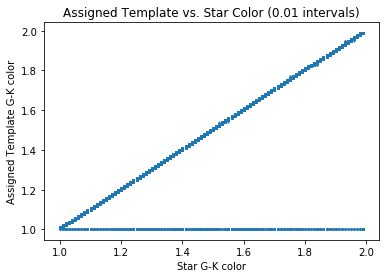

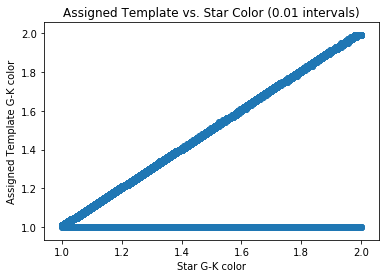

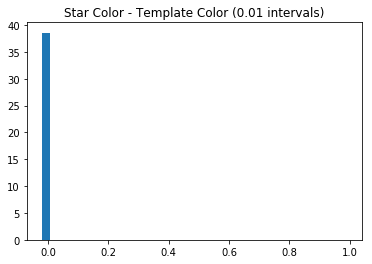

Mean: 0.00809555571158


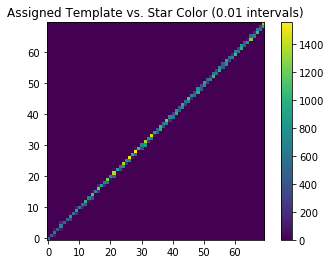

In [100]:
# DEFINE AND COPY ARRAYS BEING CREATED IN SCRIPT ABOVE. ENSURE YOU CHANGE THE NAME OF THE COPIED VARIABLE
star_bin_vals = np.array(star_bin_vals)
temp_bin_vals = np.array(temp_bin_vals)

star_bin_vals_01 = copy.copy(star_bin_vals)
temp_bin_vals_01 = copy.copy(temp_bin_vals) # KEEP THESE 4 LINES COMMENTED OUT UNLESS BEING USED

# PLOT CURVE RELATING STAR COLOR AND ASSIGNED TEMPLATE COLOR WHERE STAR COLOR IS DIGITIZED
plt.scatter(star_bin_vals_01,temp_bin_vals_01,s=1.0)
plt.title('Assigned Template vs. Star Color (0.01 intervals)')
plt.xlabel('Star G-K color')
plt.ylabel('Assigned Template G-K color')
plt.show()

# CREATING SAME CURVE WHERE STAR COLOR IS NOT DIGITIZED
diff_01 = []
for i in range(len(all_starBands)):
    starBands= np.array(all_starBands[i])
    starBands = starBands[~np.isnan(starBands)]
    if(len(starBands) == len(all_starBands[0])):
        diff_01.append(starBands[0] - starBands[5])
diff_01 = np.array(diff_01)


plt.scatter(diff_01,temp_bin_vals_01)
plt.title('Assigned Template vs. Star Color (0.01 intervals)')
plt.xlabel('Star G-K color')
plt.ylabel('Assigned Template G-K color')
plt.show()

# CREATING HISTOGRAM OF THE DIFFERENCE BETWEEN STAR COLOR AND TEMPLATE COLOR
difference_01 = star_bin_vals_01-temp_bin_vals_01

bins_01 = plt.hist(difference_01,40,normed=True)
plt.title('Star Color - Template Color (0.01 intervals)')
#plt.xlim([-0.2,0.75])
plt.show()
print('Mean:',np.mean(difference_01))

# CREATING HEATMAP OF THE FIRST TWO PLOTS ABOVE
heatmap, xedges, yedges = np.histogram2d(star_bin_vals_01, diff_01, bins=70)
plt.imshow(heatmap.T, origin='lower')
plt.title('Assigned Template vs. Star Color (0.01 intervals)')
plt.colorbar()
plt.show()

In [101]:
er_stars_03 = []
good_stars_03 = []
star_bin_vals_03 = np.array(star_bin_vals_03)
temp_bin_vals_03 = np.array(temp_bin_vals_03)
red_Chi2_vals_03 = np.array(red_Chi2_vals_03)
for i in range(len(star_bin_vals_03)):
    if(star_bin_vals_03[i] > 0.3 and temp_bin_vals_03[i] == np.min(temp_bin_vals_03)):
        er_stars_03.append([star_bin_vals_03[i],temp_bin_vals_03[i],red_Chi2_vals_03[i,0]])
    else:
        good_stars_03.append([star_bin_vals_03[i],temp_bin_vals_03[i],red_Chi2_vals_03[i,0]])

er_stars_03 = np.array(er_stars_03)
good_stars_03 = np.array(good_stars_03)        

er_stars_01 = []
good_stars_01 = []
star_bin_vals_01 = np.array(star_bin_vals_01)
temp_bin_vals_01 = np.array(temp_bin_vals_01)
red_Chi2_vals_01 = np.array(red_Chi2_vals_01)
for i in range(len(star_bin_vals_01)):
    if(star_bin_vals_01[i] > 0.3 and temp_bin_vals_01[i] == np.min(temp_bin_vals_01)):
        er_stars_01.append([star_bin_vals_01[i],temp_bin_vals_01[i],red_Chi2_vals_01[i,0]])
    else:
        good_stars_01.append([star_bin_vals_01[i],temp_bin_vals_01[i],red_Chi2_vals_01[i,0]])
        
er_stars_01 = np.array(er_stars_01)
good_stars_01 = np.array(good_stars_01)


er_stars_05 = []
good_stars_05 = []
star_bin_vals_05 = np.array(star_bin_vals_05)
temp_bin_vals_05 = np.array(temp_bin_vals_05)
red_Chi2_vals_05 = np.array(red_Chi2_vals_05)
for i in range(len(star_bin_vals_05)):
    if(star_bin_vals_05[i] > 0.3 and temp_bin_vals_05[i] == np.min(temp_bin_vals_05)):
        er_stars_05.append([star_bin_vals_05[i],temp_bin_vals_05[i],red_Chi2_vals_05[i,0]])
    else:
        good_stars_05.append([star_bin_vals_05[i],temp_bin_vals_05[i],red_Chi2_vals_05[i,0]])

er_stars_05 = np.array(er_stars_05)
good_stars_05 = np.array(good_stars_05)



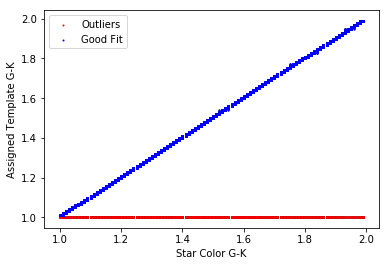

Length of Good Fit: 83201
Length of Outliers: 2257
Percentage of Stars that are Outliers: 2.712707779954568 %


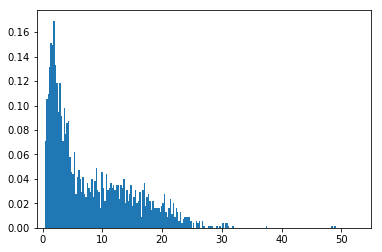

Mean Reduced Chi2: 8.06100503898


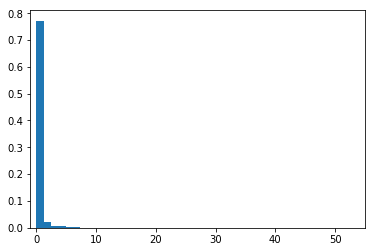

Mean Reduced Chi2: 0.512491804733
Standard Deviation: 1.30082413879
Median Val: 0.312434609069


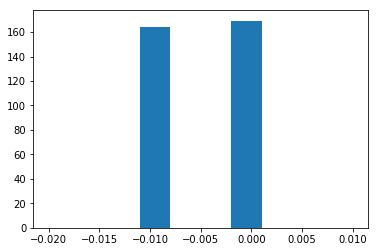

Mean val: -0.00492181584356
Standard Deviation: 0.00500227278793


In [105]:
plt.scatter(star_bin_vals_01,temp_bin_vals_01,s=1.0,c='k')
plt.scatter(er_stars_01[:,0],er_stars_01[:,1],s=1,c='r',label= 'Outliers')
plt.scatter(good_stars_01[:,0],good_stars_01[:,1],s=1,c='b',label='Good Fit')
plt.legend()
plt.xlabel('Star Color G-K')
plt.ylabel('Assigned Template G-K')
plt.show()
print('Length of Good Fit:', len(good_stars_01))
print('Length of Outliers:', len(er_stars_01))
print('Percentage of Stars that are Outliers:', 100*(len(er_stars_01)/len(good_stars_01)),'%')
plt.hist(er_stars_01[:,2],200,normed=True)
plt.xlim([-1,55])
plt.show()
print('Mean Reduced Chi2:',np.mean(er_stars_01[:,2]))

plt.hist(good_stars_01[:,2],200,normed=True)
plt.xlim([-1,55])
plt.show()
print('Mean Reduced Chi2:',np.mean(good_stars_01[:,2]))
print('Standard Deviation:', np.std(good_stars_01[:,2]))
print('Median Val:', np.median(good_stars_01[:,2]))

good_diff_01 = good_stars_01[:,0] - good_stars_01[:,1]
bin01 = plt.hist(good_diff_01,10,normed=True)
plt.show()
print('Mean val:',np.mean(good_diff_01))
print('Standard Deviation:', np.std(good_diff_01))

# **Tests Removing stars with outlying reduced Chi2 vals (0.03 interval)**

In [108]:
print(bin01[1])
print(bin01[0])

[-0.02  -0.017 -0.014 -0.011 -0.008 -0.005 -0.002  0.001  0.004  0.007
  0.01 ]
[  2.80445347e-02   0.00000000e+00   0.00000000e+00   1.64024471e+02
   0.00000000e+00   0.00000000e+00   1.69260786e+02   0.00000000e+00
   0.00000000e+00   2.00318105e-02]


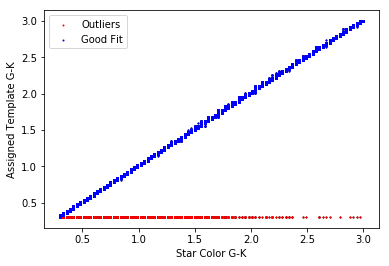

Length of Good Fit: 191728
Length of Outliers: 1419
Percentage of Stars that are Outliers: 0.7401109905699741 %


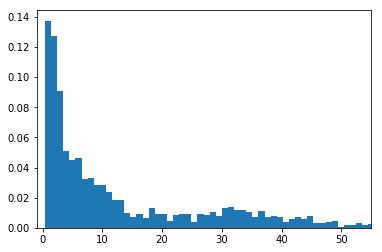

Mean Reduced Chi2: 13.0782131253


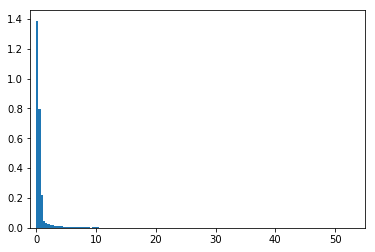

Mean Reduced Chi2: 0.958812663416
Median Val: 0.356118483687
Standard Deviation: 2.93785088824


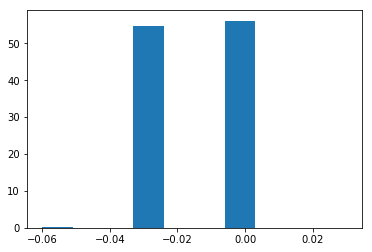

Mean val: -0.014863243762
Standard Deviation: 0.0150742989805


In [109]:
plt.scatter(star_bin_vals_03,temp_bin_vals_03,s=1.0,c='k')
plt.scatter(er_stars_03[:,0],er_stars_03[:,1],s=1,c='r',label= 'Outliers')
plt.scatter(good_stars_03[:,0],good_stars_03[:,1],s=1,c='b',label='Good Fit')
plt.legend()
plt.xlabel('Star Color G-K')
plt.ylabel('Assigned Template G-K')
plt.show()
print('Length of Good Fit:', len(good_stars_03))
print('Length of Outliers:', len(er_stars_03))
print('Percentage of Stars that are Outliers:', 100*(len(er_stars_03)/len(good_stars_03)),'%')
plt.hist(er_stars_03[:,2],200,normed=True)
plt.xlim([-1,55])
plt.show()
print('Mean Reduced Chi2:',np.mean(er_stars_03[:,2]))

plt.hist(good_stars_03[:,2],200,normed=True)
plt.xlim([-1,55])
plt.show()
print('Mean Reduced Chi2:',np.mean(good_stars_03[:,2]))
print('Median Val:', np.median(good_stars_03[:,2]))
print('Standard Deviation:', np.std(good_stars_03[:,2]))

good_diff_03 = good_stars_03[:,0] - good_stars_03[:,1]
bin03 = plt.hist(good_diff_03,10,normed=True)
plt.show()
print('Mean val:',np.mean(good_diff_03))
print('Standard Deviation:', np.std(good_diff_03))

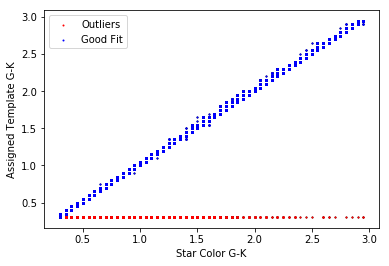

Length of Good Fit: 191757
Length of Outliers: 1390
Percentage of Stars that are Outliers: 0.724875754209755 %


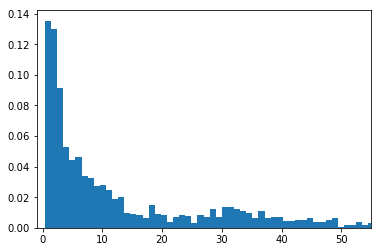

Mean Reduced Chi2: 12.9267852754


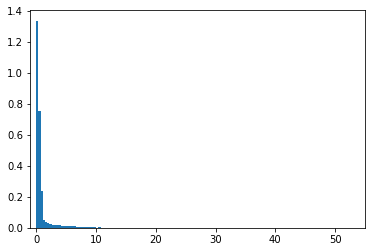

Mean Reduced Chi2: 1.07699598965
Standard Deviation: 3.02493274689


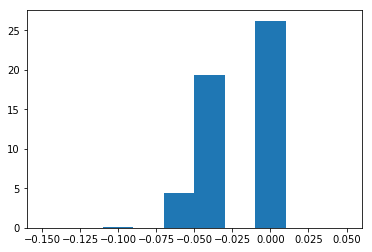

Mean val: -0.0238564954604
Standard Deviation: 0.0251040049439


In [97]:
plt.scatter(star_bin_vals_05,temp_bin_vals_05,s=1.0,c='k')
plt.scatter(er_stars_05[:,0],er_stars_05[:,1],s=1,c='r',label= 'Outliers')
plt.scatter(good_stars_05[:,0],good_stars_05[:,1],s=1,c='b',label='Good Fit')
plt.legend()
plt.xlabel('Star Color G-K')
plt.ylabel('Assigned Template G-K')
plt.show()
print('Length of Good Fit:', len(good_stars_05))
print('Length of Outliers:', len(er_stars_05))
print('Percentage of Stars that are Outliers:', 100*(len(er_stars_05)/len(good_stars_05)),'%')
plt.hist(er_stars_05[:,2],200,normed=True)
plt.xlim([-1,55])
plt.show()
print('Mean Reduced Chi2:',np.mean(er_stars_05[:,2]))

plt.hist(good_stars_05[:,2],200,normed=True)
plt.xlim([-1,55])
plt.show()
print('Mean Reduced Chi2:',np.mean(good_stars_05[:,2]))
print('Standard Deviation:', np.std(good_stars_05[:,2]))

good_diff_05 = good_stars_05[:,0] - good_stars_05[:,1]
plt.hist(good_diff_05,10,normed=True)
plt.show()
print('Mean val:',np.mean(good_diff_05))
print('Standard Deviation:', np.std(good_diff_05))

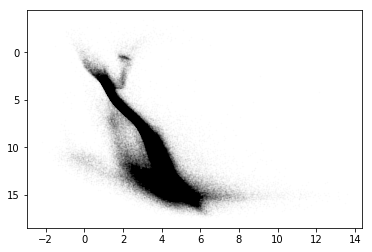

In [301]:
new_all_starBands = []
for i in range(len(new_Gmag)):
    if(new_Gmag[i] != np.nan and new_GBmag[i] != np.nan and new_GRmag[i] != np.nan and new_Jmag[i] \
       != np.nan and new_Hmag[i] != np.nan and new_Kmag[i] != np.nan and \
       (new_Gmag[i]-new_Kmag[i]) <=2.8 and (new_Gmag[i]-new_Kmag[i]) >= 0.2 and (new_Gmag[i] - new_Kmag[i]) != np.nan \
      and (new_Gmag[i]-new_Hmag[i]) != np.nan):
        
        new_all_starBands.append([new_Gmag[i],new_GBmag[i],new_GRmag[i],new_Jmag[i],new_Hmag[i],new_Kmag[i]])
new_all_starBands = np.array(all_starBands)
print(new_all_starBands[0])

[ 10.02853012  10.37783909   9.54774475   8.99300003   8.68599987
   8.65100002]


# **Comparing Templates: Bright Stars & Dim Stars between 1-4 G-K**

In [11]:
Gmags = Gmag - 5 * np.log10(Dist) + 5
GK = Gmag - Kmag
br_Gmag = []
br_GBmag = []
br_GRmag = []
br_Jmag = []
br_Hmag = []
br_Kmag = []
br_GK = []
br_G = []
for i in range(len(Gmags)):
    if(Gmags[i] < 10 and GK[i] >= 1.0 and GK[i] <= 4.0):
    #if(SNR[i] > 50):
        br_Gmag.append(Gmag[i])
        br_GBmag.append(GBmag[i])
        br_GRmag.append(GRmag[i])
        br_Jmag.append(Jmag[i])
        br_Hmag.append(Hmag[i])
        br_Kmag.append(Kmag[i])
        br_GK.append(GK[i])
        br_G.append(Gmags[i])
br_Gmag = np.array(br_Gmag)
br_GBmag = np.array(br_GBmag)
br_GRmag = np.array(br_GRmag)
br_Jmag = np.array(br_Jmag)
br_Hmag = np.array(br_Hmag)
br_Kmag = np.array(br_Kmag)
br_GK = np.array(br_GK)
br_G = np.array(br_G)
print('Length of Br_Mags:',len(br_Gmag))

dm_G = []
dm_Gmag = []
dm_GBmag = []
dm_GRmag = []
dm_Jmag = []
dm_Hmag = []
dm_Kmag = []
dm_GK = []
for i in range(len(Gmags)):
    if(Gmags[i] > 10 and GK[i] >= 1.0 and GK[i] <= 4.0):
        dm_Gmag.append(Gmag[i])
        dm_GBmag.append(GBmag[i])
        dm_GRmag.append(GRmag[i])
        dm_Jmag.append(Jmag[i])
        dm_Hmag.append(Hmag[i])
        dm_Kmag.append(Kmag[i])
        dm_GK.append(GK[i])
        dm_G.append(Gmags[i])
dm_Gmag = np.array(dm_Gmag)
dm_GBmag = np.array(dm_GBmag)
dm_GRmag = np.array(dm_GRmag)
dm_Jmag = np.array(dm_Jmag)
dm_Hmag = np.array(dm_Hmag)
dm_Kmag = np.array(dm_Kmag)
dm_GK = np.array(dm_GK)
dm_G = np.array(dm_G)
print('Length of dm_Mags:',len(dm_Gmag))

Length of Br_Mags: 296527
Length of dm_Mags: 279660


In [ ]:
574213   296527

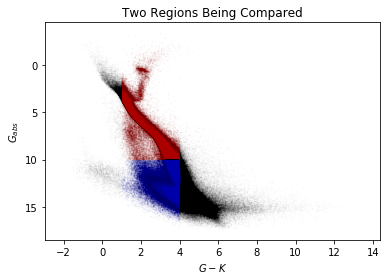

In [38]:
plt.scatter(GK,Gmags,s=1.0,c='k',alpha=0.01)
plt.scatter(br_GK,br_G,s=1.0,c='r',alpha=0.01)
plt.scatter(dm_GK,dm_G,s=1.0,c='b',alpha=0.01)
plt.gca().invert_yaxis()
plt.title('Two Regions Being Compared')
plt.xlabel('$G-K$')
plt.ylabel('$G_{abs}$')
plt.show()

In [88]:
#     *** BRIGHT STARS ***

colors = np.arange(1,2,0.03) # EDIT THIS TO USE DESIRED NUMBER OF COLORS
#color = ColorClassification(new_Gmag,new_Kmag,colors)
color_br = ColorClassification(br_Gmag,br_Kmag,colors)

stars_br,color_mags_br,color_std_br,color_std_err_br,abs_color_mags_br,abs_color_std_br,abs_color_std_err_br = \
CreateTemplates(color_br,colors,br_Gmag,br_Kmag,GB_mags=br_GBmag,GR_mags=br_GRmag,J_mags=br_Jmag,H_mags=br_Hmag)

#stars_br_2,color_mags_br_2,color_std_br_2,color_std_err_br_2,abs_color_mags_br_2,abs_color_std_br_2,abs_color_std_err_br_2 = \
#CreateTemplates(color_br_2,colors,br_Gmag,br_Kmag,GB_mags=br_GBmag,GR_mags=br_GRmag,J_mags=br_Jmag,H_mags=br_Hmag)

/astromake/opt/python/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:108: RuntimeWarning: Mean of empty slice
/astromake/opt/python/anaconda3/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1423: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/astromake/opt/python/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:111: RuntimeWarning: Mean of empty slice


In [89]:
#    *** DIM STARS ***

colors = np.arange(1,2,0.03) # EDIT THIS TO USE DESIRED NUMBER OF COLORS
color_dm = ColorClassification(dm_Gmag,dm_Kmag,colors)

stars_dm,color_mags_dm,color_std_dm,color_std_err_dm,abs_color_mags_dm,abs_color_std_dm,abs_color_std_err_dm = \
CreateTemplates(color_dm,colors,dm_Gmag,dm_Kmag,GB_mags=dm_GBmag,GR_mags=dm_GRmag,J_mags=dm_Jmag,H_mags=dm_Hmag)

#stars_dm_2,color_mags_dm_2,color_std_dm_2,color_std_err_dm_2,abs_color_mags_dm_2,abs_color_std_dm_2,abs_color_std_err_dm_2 = \
#CreateTemplates(color_dm_2,colors,dm_Gmag,dm_Kmag,GB_mags=dm_GBmag,GR_mags=dm_GRmag,J_mags=dm_Jmag,H_mags=dm_Hmag)

/astromake/opt/python/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:108: RuntimeWarning: Mean of empty slice
/astromake/opt/python/anaconda3/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1423: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/astromake/opt/python/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:111: RuntimeWarning: Mean of empty slice


34


In [42]:
all_starBands = []
for i in range(len(Gmag)):
    if(Gmag[i] != np.nan and GBmag[i] != np.nan and GRmag[i] != np.nan and Jmag[i] \
       != np.nan and Hmag[i] != np.nan and Kmag[i] != np.nan and \
       (Gmag[i]-Kmag[i]) <=4.0 and (Gmag[i]-Kmag[i]) >= 1.0 and (Gmag[i] - Kmag[i]) != np.nan \
      and (Gmag[i]-Hmag[i]) != np.nan):
        
        all_starBands.append([Gmag[i],GBmag[i],GRmag[i],Jmag[i],Hmag[i],Kmag[i]])
all_starBands = np.array(all_starBands)
print(all_starBands[0])






## KEEP THE FOLLOWING CODE BELOW COMMENTED OUT FOR NOW

# dim_stars = []

# for i in range(len(Gmags)):
#     if(Gmags[i] >= 10):
#         if(Gmag[i] != np.nan and GBmag[i] != np.nan and GRmag[i] != np.nan and Jmag[i] \
#         != np.nan and Hmag[i] != np.nan and Kmag[i] != np.nan and \
#         (Gmag[i]-Kmag[i]) <=4.0 and (Gmag[i]-Kmag[i]) >= 1.0 and (Gmag[i] - Kmag[i]) != np.nan \
#         and (Gmag[i]-Hmag[i]) != np.nan):
        
#            dim_stars.append([Gmag[i],GBmag[i],GRmag[i],Jmag[i],Hmag[i],Kmag[i]])
        
# dim_stars = np.array(dim_stars)

# br_stars = []

# for i in range(len(Gmags)):
#     if(Gmags[i] < 10):
#         if(Gmag[i] != np.nan and GBmag[i] != np.nan and GRmag[i] != np.nan and Jmag[i] \
#         != np.nan and Hmag[i] != np.nan and Kmag[i] != np.nan and \
#         (Gmag[i]-Kmag[i]) <=4.0 and (Gmag[i]-Kmag[i]) >= 1.0 and (Gmag[i] - Kmag[i]) != np.nan \
#         and (Gmag[i]-Hmag[i]) != np.nan):
        
#            br_stars.append([Gmag[i],GBmag[i],GRmag[i],Jmag[i],Hmag[i],Kmag[i]])
        
# br_stars = np.array(br_stars)


[ 16.30409813  17.6627121   15.15303516  13.65299988  13.1619997
  12.88899994]


**Fitting All stars to Templates Built with Bright Stars**

In [64]:
br_Chi2 = []
color_mags_br = color_mags_br[1:len(color_mags_br)]
color_std_br = color_std_br[1:len(color_std_br)]
for i in range(len(all_starBands)):
    starBands= np.array(all_starBands[i])
    starBands = starBands[~np.isnan(starBands)]
    if(len(starBands) == len(all_starBands[0])):
        #starBands = np.array(starBands)
        fit, new_starBand, red_Chi2 = StarFitting(starBands,color_mags_br,color_std_br)
        br_Chi2_val = red_Chi2[0]
        br_Chi2.append(br_Chi2_val)
br_Chi2 = np.array(br_Chi2)

In [152]:
# starBands= np.array(all_starBands[12875])
# starBands = starBands[~np.isnan(starBands)]
# fit, new_starBand, red_Chi2 = StarFitting(starBands,color_mags_br[1:len(color_mags_br)],color_std_br[1:len(color_std_br)])

# print(red_Chi2)

In [154]:
print(np.mean(br_Chi2))
print(np.mean(dm_Chi2))
print(len(br_Chi2)/len(br_Gmag))

6.12336155942
1.21244735949
1.9364610979775871


In [149]:
len(all_starBands)

490607

In [153]:
# DEBUGGING CODE

# test = []
# test_mags_dm = copy.copy(color_mags_dm)
# test_std_dm = copy.copy(color_std_dm)
# # test_mags_dm = test[1:len(color_mags_dm)]
# # test_std_dm = color_std_dm[1:len(color_std_dm)]
# #print(color_mags_dm)
# for i in range(15):
#     starBands= np.array(all_starBands[i])
#     starBands = starBands[~np.isnan(starBands)]
#     if(len(starBands) == len(all_starBands[i])):
#         #starBands = np.array(starBands)
#         fit, new_starBand, red_Chi2 = StarFitting(starBands,test_mags_dm,test_std_dm)
#         test_val = red_Chi2[0]
#         test.append(test_val)
# test = np.array(test)
# print('length:',len(test))

In [72]:
dm_Chi2 = []
color_mags_dm = color_mags_dm[1:len(color_mags_dm)]
color_std_dm = color_std_dm[1:len(color_std_dm)]
#print(color_mags_dm)
for i in range(len(all_starBands)):
    starBands= np.array(all_starBands[i])
    starBands = starBands[~np.isnan(starBands)]
    if(len(starBands) == len(all_starBands[i])):
        #starBands = np.array(starBands)
        fit, new_starBand, red_Chi2 = StarFitting(starBands,color_mags_dm,color_std_dm)
        dm_Chi2_val = red_Chi2[0]
        dm_Chi2.append(dm_Chi2_val)
dm_Chi2 = np.array(dm_Chi2)

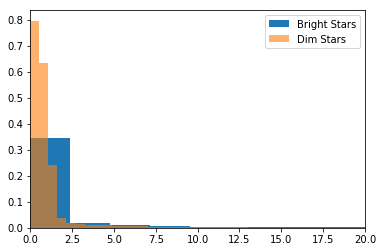

Mean Reduced Chi Squared for Bright Stars: 6.12336155942
Median Reduced Chi Squared for Bright Stars: 0.688117241054

Mean Reduced Chi Squared for Dim Stars: 1.21244735949
Median Reduced Chi Squared for Dim Stars: 0.64488304594


In [240]:
plt.hist(br_Chi2,600,normed=True,alpha=1.0,label='Bright Stars')
plt.hist(dm_Chi2,600,normed=True,alpha=0.6,label='Dim Stars')
plt.xlim([0,20])
plt.legend()
plt.show()
print('Mean Reduced Chi Squared for Bright Stars:',np.mean(br_Chi2))
print('Median Reduced Chi Squared for Bright Stars:',np.median(br_Chi2))
print('\nMean Reduced Chi Squared for Dim Stars:',np.mean(dm_Chi2))
print('Median Reduced Chi Squared for Dim Stars:',np.median(dm_Chi2))

574213
574213


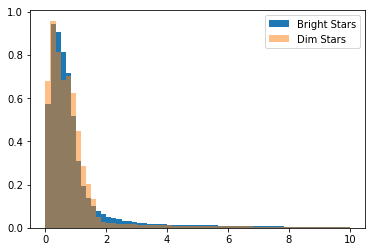

Mean Reduced Chi Squared for Bright Stars: 1.03499881821
Median Reduced Chi Squared for Bright Stars: 0.616781031629

Mean Reduced Chi Squared for Dim Stars: 0.894172694549
Median Reduced Chi Squared for Dim Stars: 0.633331234541


In [178]:
print(len(br_Chi2))
print(len(dm_Chi2))

bet_br_Chi2 = []
bet_dm_Chi2 = []
for i in range(len(br_Chi2)):
    if(br_Chi2[i] <= 10.0):
        bet_br_Chi2.append(br_Chi2[i])
    if(dm_Chi2[i] <= 10.0):
        bet_dm_Chi2.append(dm_Chi2[i])

plt.hist(bet_br_Chi2,60,normed=True,alpha=1.0,label='Bright Stars')
plt.hist(bet_dm_Chi2,60,normed=True,alpha=0.5,label='Dim Stars')
#plt.xlim([0,30])
plt.legend()
plt.show()
print('Mean Reduced Chi Squared for Bright Stars:',np.mean(bet_br_Chi2))
print('Median Reduced Chi Squared for Bright Stars:',np.median(bet_br_Chi2))
print('\nMean Reduced Chi Squared for Dim Stars:',np.mean(bet_dm_Chi2))
print('Median Reduced Chi Squared for Dim Stars:',np.median(bet_dm_Chi2))        

# **Comparing Templates: Bright Stars & Dim Stars between 2-4 G-K**

In [162]:
all_starBands = []
for i in range(len(Gmag)):
    if(Gmag[i] != np.nan and GBmag[i] != np.nan and GRmag[i] != np.nan and Jmag[i] \
       != np.nan and Hmag[i] != np.nan and Kmag[i] != np.nan and \
       (Gmag[i]-Kmag[i]) <=4.0 and (Gmag[i]-Kmag[i]) >= 2.0 and (Gmag[i] - Kmag[i]) != np.nan \
      and (Gmag[i]-Hmag[i]) != np.nan):
        
        all_starBands.append([Gmag[i],GBmag[i],GRmag[i],Jmag[i],Hmag[i],Kmag[i]])
all_starBands = np.array(all_starBands)
print(all_starBands[0])


[ 16.30409813  17.6627121   15.15303516  13.65299988  13.1619997
  12.88899994]


In [166]:
br_Chi2_2 = []
br_mags = copy.copy(color_mags_br_2)
br_std = copy.copy(color_std_br_2)
br_mags = br_mags[1:len(br_mags)]
br_std = br_std[1:len(br_std)]
for i in range(len(all_starBands)):
    starBands= np.array(all_starBands[i])
    starBands = starBands[~np.isnan(starBands)]
    if(len(starBands) == len(all_starBands[0])):
        #starBands = np.array(starBands)
        fit, new_starBand, red_Chi2 = StarFitting(starBands,br_mags,br_std)
        br_Chi2_val = red_Chi2[0]
        br_Chi2_2.append(br_Chi2_val)
br_Chi2_2 = np.array(br_Chi2_2)

In [167]:
dm_Chi2_2 = []
dm_mags = copy.copy(color_mags_dm_2)
dm_std = copy.copy(color_std_dm_2)
dm_mags = br_mags[1:len(dm_mags)]
dm_std = br_std[1:len(dm_std)]
for i in range(len(all_starBands)):
    starBands= np.array(all_starBands[i])
    starBands = starBands[~np.isnan(starBands)]
    if(len(starBands) == len(all_starBands[0])):
        #starBands = np.array(starBands)
        fit, new_starBand, red_Chi2 = StarFitting(starBands,dm_mags,dm_std)
        dm_Chi2_val = red_Chi2[0]
        dm_Chi2_2.append(dm_Chi2_val)
dm_Chi2_2 = np.array(dm_Chi2_2)

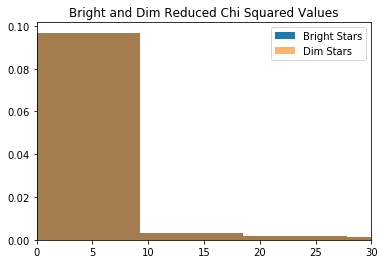

Mean Reduced Chi Squared Value for Bright Stars: 5.89566017951
Median Reduced Chi Squared Value for Bright Stars: 0.672128138641

Mean Reduced Chi Squared Value for Dim Stars: 5.91247221255
Median Reduced Chi Squared Value for Dim Stars: 0.676935265053
0.00213512202013 0.00213512202013


In [174]:
plt.hist(br_Chi2_2,100,normed=True,alpha=1.0,label='Bright Stars')
plt.hist(dm_Chi2_2,100,normed=True,alpha=0.6,label='Dim Stars')
plt.title('Bright and Dim Reduced Chi Squared Values')
plt.legend()
plt.xlim([0,30])
plt.show()
print('Mean Reduced Chi Squared Value for Bright Stars:',np.mean(br_Chi2_2))
print('Median Reduced Chi Squared Value for Bright Stars:', np.median(br_Chi2_2))
print('\nMean Reduced Chi Squared Value for Dim Stars:',np.mean(dm_Chi2_2))
print('Median Reduced Chi Squared Value for Dim Stars:',np.median(dm_Chi2_2))
print(np.min(br_Chi2_2),np.min(dm_Chi2_2))

In [235]:
print(len(br_Chi2_2),len(br_Chi2))

488755 574213


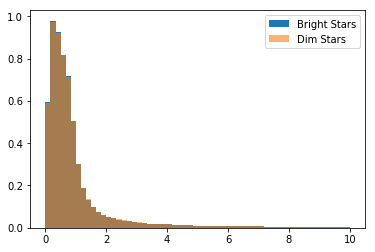

Mean Reduced Chi Squared for Bright Stars: 0.989118739035
Median Reduced Chi Squared for Bright Stars: 0.600914653147

Mean Reduced Chi Squared for Dim Stars: 1.00478414307
Median Reduced Chi Squared for Dim Stars: 0.604869170773


In [175]:
bet_br_Chi2_2 = []
bet_dm_Chi2_2 = []
for i in range(len(br_Chi2_2)):
    if(br_Chi2_2[i] <= 10.0):
        bet_br_Chi2_2.append(br_Chi2_2[i])
    if(dm_Chi2_2[i] <= 10.0):
        bet_dm_Chi2_2.append(dm_Chi2_2[i])

plt.hist(bet_br_Chi2_2,60,normed=True,alpha=1.0,label='Bright Stars')
plt.hist(bet_dm_Chi2_2,60,normed=True,alpha=0.6,label='Dim Stars')
#plt.xlim([0,30])
plt.legend()
plt.show()
print('Mean Reduced Chi Squared for Bright Stars:',np.mean(bet_br_Chi2_2))
print('Median Reduced Chi Squared for Bright Stars:',np.median(bet_br_Chi2_2))
print('\nMean Reduced Chi Squared for Dim Stars:',np.mean(bet_dm_Chi2_2))
print('Median Reduced Chi Squared for Dim Stars:',np.median(bet_dm_Chi2_2))       

# Reduced X^2 Tests Between G-K 1-4 For Bright And Dim Stars. Two Sets of Fits will be performed

In [56]:
print(len(color_mags_br),len(color_mags_dm))
print(len(br_Gmag),len(all_brightStars))

100 100
296527 296527


In [12]:
colors = np.arange(1,4,0.03) # EDIT THIS TO USE DESIRED NUMBER OF COLORS

# BRIGHT STARS
color_br = ColorClassification(br_Gmag,br_Kmag,colors)

stars_br,color_mags_br,color_std_br,color_std_err_br,abs_color_mags_br,abs_color_std_br,abs_color_std_err_br = \
CreateTemplates(color_br,colors,Gmags=br_Gmag,Kmags=br_Kmag,GB_mags=br_GBmag,GR_mags=br_GRmag,J_mags=br_Jmag,H_mags=br_Hmag)

# DIM STARS
color_dm = ColorClassification(dm_Gmag,dm_Kmag,colors)

stars_dm,color_mags_dm,color_std_dm,color_std_err_dm,abs_color_mags_dm,abs_color_std_dm,abs_color_std_err_dm = \
CreateTemplates(color_dm,colors,dm_Gmag,dm_Kmag,GB_mags=dm_GBmag,GR_mags=dm_GRmag,J_mags=dm_Jmag,H_mags=dm_Hmag)

/astromake/opt/python/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:108: RuntimeWarning: Mean of empty slice
/astromake/opt/python/anaconda3/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1423: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/astromake/opt/python/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:111: RuntimeWarning: Mean of empty slice


In [13]:
# DEFINE ALL BRIGHT STARS
# all_brightStars = []
# for i in range(len(Gmag)):
#     if(Gmag[i] != np.nan and GBmag[i] != np.nan and GRmag[i] != np.nan and Jmag[i] \
#        != np.nan and Hmag[i] != np.nan and Kmag[i] != np.nan and \
#        (Gmag[i]-Kmag[i]) <=4.0 and (Gmag[i]-Kmag[i]) >= 1.0 and (Gmag[i] - Kmag[i]) != np.nan \
#       and (Gmag[i]-Hmag[i]) != np.nan and Gmags[i] < 10.0):
        
#         all_brightStars.append([Gmag[i],GBmag[i],GRmag[i],Jmag[i],Hmag[i],Kmag[i]])
# all_brightStars = np.array(all_brightStars)
# print(len(all_brightStars),len(br_Gmag))

all_brightStars = np.transpose(np.array([br_Gmag,br_GBmag,br_GRmag,br_Jmag,br_Hmag,br_Kmag]))
print(all_brightStars[0])

[ 10.02853012  10.37783909   9.54774475   8.99300003   8.68599987
   8.65100002]


In [ ]:
# FITTING BRIGHT STARS TO BOTH BRIGHT AND FAINT TEMPLATES & DETERMINING WHETHER EACH BRIGHT STAR FITS TO
# A BRIGHT TEMPLATE OR A FAINT TEMPLATE. **Best Template is determined by comparing Reduced X^2 values**


ReducedX2_br = 0
ReducedX2_dm = 0

# Bright Templates
mags_br = copy.copy(color_mags_br)
std_br = copy.copy(color_std_br)
mags_br = mags_br[1:len(mags_br)]
std_br = std_br[1:len(std_br)]
# Faint Templates
mags_dm = copy.copy(color_mags_dm)
std_dm = copy.copy(color_std_dm)
mags_dm = mags_dm[1:len(mags_dm)]
std_dm = std_dm[1:len(std_dm)]
for i in range(len(all_brightStars)):
    chiValues = []
    starBands= np.array(all_brightStars[i])
    starBands = starBands[~np.isnan(starBands)]
    if(len(starBands) == len(all_brightStars[0])):
       
        fit_br, new_starBand_br, red_Chi2_br = StarFitting(starBands,mags_br,std_br) # BRIGHT TEMPLATE FIT
        fit_dm, new_starBand_dm, red_Chi2_dm = StarFitting(starBands,mags_dm,std_dm) # FAINT TEMPLATE FIT
        chiValues.append([red_Chi2_br[0],red_Chi2_dm[0]])
    if(chiValues[0] == np.min(chiValues)):
        ReducedX2_br = ReducedX2_br + 1
    else:
        ReducedX2_dm = ReducedX2_dm + 1
        
print('Bright Stars Fit to Bright Templates'+str((ReducedX2_br/len(all_brightStars))*100.0)+'% of the time')
print('Bright Stars Fit to Faint Templates'+str((ReducedX2_dm/len(all_brightStars))*100.0)+'% of the time')
        

In [ ]:
# FITTING BRIGHT STARS TO BOTH BRIGHT AND FAINT TEMPLATES & DETERMINING WHETHER EACH BRIGHT STAR FITS TO
# A BRIGHT TEMPLATE OR A FAINT TEMPLATE. **Best Template is determined by comparing G-K color values**

brightFit_br = 0
faintFit_br = 0

# Bright Templates
mags_br = copy.copy(color_mags_br)
std_br = copy.copy(color_std_br)
mags_br = mags_br[1:len(mags_br)]
std_br = std_br[1:len(std_br)]
# Faint Templates
mags_dm = copy.copy(color_mags_dm)
std_dm = copy.copy(color_std_dm)
mags_dm = mags_dm[1:len(mags_dm)]
std_dm = std_dm[1:len(std_dm)]
for i in range(len(all_brightStars)):
    fitColors = []
    starBands= np.array(all_brightStars[i])
    starBands = starBands[~np.isnan(starBands)]
    if(len(starBands) == len(all_brightStars[0])):
       
        fit_br, new_starBand, red_Chi2_br = StarFitting(starBands,mags_br,std_br) # BRIGHT TEMPLATE FIT
        fit_dm, new_starBand, red_Chi2_dm = StarFitting(starBands,mags_dm,std_dm) # FAINT TEMPLATE FIT
        fitColors.append((new_starband[4] - mags_br[fit_br,9]),(new_starBand[4] - mags_dm[fit_dm,9]))
    if(fitColors[0] == np.min(fitColors)):
        brightFit_br = brightFit_br + 1
    else:
        faintFit_br = faintFit_br + 1
        
print('Bright Stars Fit to Bright Templates'+str((brightFit_br/len(all_brightStars))*100.0)+'% of the time')
print('Bright Stars Fit to Faint Templates'+str((faintFit_br/len(all_brightStars))*100.0)+'% of the time')
        

In [14]:
# DEFINE ALL FAINT STARS
# all_dimStars = []
# for i in range(len(Gmag)):
#     if(Gmag[i] != np.nan and GBmag[i] != np.nan and GRmag[i] != np.nan and Jmag[i] \
#        != np.nan and Hmag[i] != np.nan and Kmag[i] != np.nan and \
#        (Gmag[i]-Kmag[i]) <=4.0 and (Gmag[i]-Kmag[i]) >= 1.0 and (Gmag[i] - Kmag[i]) != np.nan \
#       and (Gmag[i]-Hmag[i]) != np.nan and Gmags[i] >= 10.0):
        
#         all_dimStars.append([Gmag[i],GBmag[i],GRmag[i],Jmag[i],Hmag[i],Kmag[i]])
# all_dimStars = np.array(all_dimStars)
# print(len(all_dimStars),len(dm_Gmag))

all_dimStars = np.transpose(np.array([dm_Gmag,dm_GBmag,dm_GRmag,dm_Jmag,dm_Hmag,dm_Kmag]))
print(all_dimStars[0])

[ 16.30409813  17.6627121   15.15303516  13.65299988  13.1619997
  12.88899994]


In [42]:
# CALCULATE REDUCED CHI SQUARED VALUES FOR BRIGHT STAR TEMPLATES USING BRIGHT STARS (1-4)
br_redChi2_bright = []
new_bands_bright = []
br_brightFits = []
br_mags = copy.copy(color_mags_br)
br_std = copy.copy(color_std_br)
br_mags = br_mags[1:len(br_mags)]
br_std = br_std[1:len(br_std)]
for i in range(len(all_brightStars)):
    starBands= np.array(all_brightStars[i])
    starBands = starBands[~np.isnan(starBands)]
    if(len(starBands) == len(all_brightStars[0])):
        #starBands = np.array(starBands)
        fit, new_starBand, red_Chi2 = StarFitting(starBands,br_mags,br_std)
        chi2 = red_Chi2[0]
        br_redChi2_bright.append(chi2)
        new_bands_bright.append(starBands)
        br_brightFits.append(fit)
br_redChi2_bright = np.array(br_redChi2_bright)
new_bands_bright = np.array(new_bands_bright)
br_brightFits = np.array(br_brightFits)

In [98]:
print(br_brightFits)

[12 12 85 ..., 74 85 66]


In [44]:
# CALCULATE REDUCED CHI SQUARED VALUES FOR BRIGHT STAR TEMPLATES USING FAINT STARS
br_redChi2_dim = []
new_bands_dim = []
br_dimFits = []
br_mags = copy.copy(color_mags_br)
br_std = copy.copy(color_std_br)
br_mags = br_mags[1:len(br_mags)]
br_std = br_std[1:len(br_std)]
for i in range(len(all_dimStars)):
    starBands= np.array(all_dimStars[i])
    starBands = starBands[~np.isnan(starBands)]
    if(len(starBands) == len(all_dimStars[0])):
        #starBands = np.array(starBands)
        fit, new_starBand, red_Chi2 = StarFitting(starBands,br_mags,br_std)
        chi2 = red_Chi2[0]
        br_redChi2_dim.append(chi2)
        new_bands_dim.append(starBands)
        br_dimFits.append(fit)
br_redChi2_dim = np.array(br_redChi2_dim)
new_bands_dim = np.array(new_bands_dim)
br_dimFits = np.array(br_dimFits)

In [294]:
print(mags[fit])

[        nan         nan -0.28760808         nan         nan  0.8442376
         nan  1.6414531   2.06387716  2.005855  ]


In [304]:
# star_bin_vals_br = []
# temp_bin_vals_br = []
# red_Chi2_vals_br = []

templateColor_br = []
starColor_br = []
starChi2_br = []

mags = copy.copy(color_mags_br)
std = copy.copy(color_std_br)
mags = mags[1:len(mags)]
std = std[1:len(std)]
for i in range(len(all_brightStars)):
    
    starBands= np.array(all_brightStars[i])
    starBands = starBands[~np.isnan(starBands)]
    if(len(starBands) == len(all_brightStars[0])):
        #starBands = np.array(starBands)
        fit, new_starBand, red_Chi2 = StarFitting(starBands,mags,std)
        #temp_bin_vals_br.append(mags[fit,4])
        #red_Chi2_vals_br.append(red_Chi2)
        templateColor_br.append(mags[fit,9])
        starChi2_br.append(red_Chi2)
        diff_vals = []
        for j in range(len(colors)):
            diff = abs(colors[j] - new_starBand[4])
            diff_vals.append(diff)

        for j in range(len(diff_vals)):
            if(diff_vals[j] == np.min(diff_vals)):
                #star_bin_vals_br.append(colors[j])
                starColor_br.append(colors[j])

                


In [303]:
print(mags[0])

[        nan         nan -0.24796131         nan         nan  0.36355456
         nan  0.77215016  0.95497886  1.01548181]


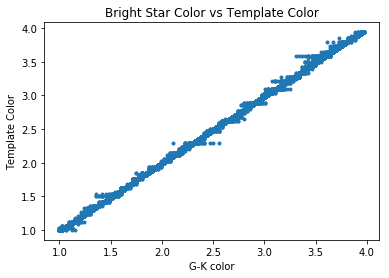

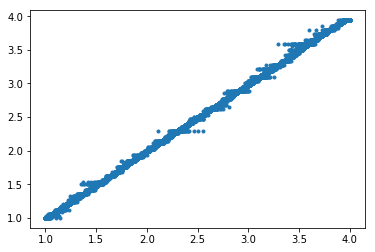

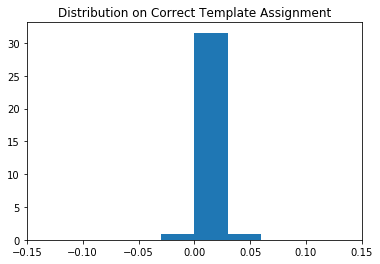

0.0149026465172
0.014937210083


In [320]:
star_bin_vals_br = np.array(star_bin_vals_br)
temp_bin_vals_br = np.array(temp_bin_vals_br)

plt.plot(star_bin_vals_br,temp_bin_vals_br,'.')
plt.title('Bright Star Color vs Template Color')
plt.xlabel('G-K color')
plt.ylabel('Template Color')
plt.show()

diff_color_br = []
for i in range(len(all_brightStars)):
    starBands= np.array(all_brightStars[i])
    starBands = starBands[~np.isnan(starBands)]
    if(len(starBands) == len(all_brightStars[0])):
        diff_color_br.append(starBands[0] - starBands[5])
diff_color_br = np.array(diff_color_br)
plt.plot(diff_color_br,temp_bin_vals_br,'.')
plt.show()

diff_br = (diff_color_br - temp_bin_vals_br)
diff_temp_br = abs(star_bin_vals_br - temp_bin_vals_br)

bins=[-.12,-0.09,-0.06,-0.03,0.0,0.03,0.06,0.09,0.12]
plt.hist(diff_br,bins=bins,normed=True)
plt.xlim([-.15,.15])
plt.title('Distribution on Correct Template Assignment')
plt.show()
print(np.mean(diff_br))
print(np.median(diff_br))

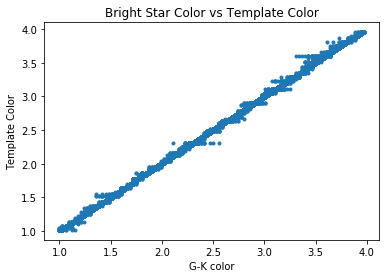

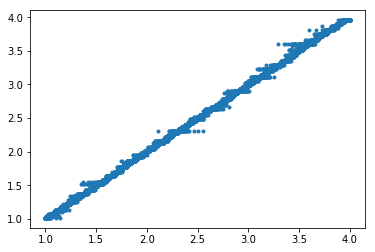

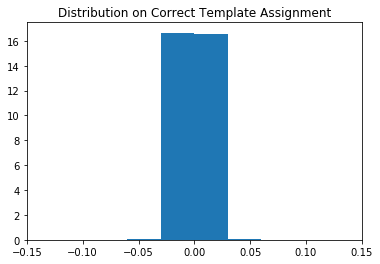

-7.65696467941e-05
-4.38011547299e-05


In [323]:

starColor_br = np.array(starColor_br)
templateColor_br = np.array(templateColor_br)

plt.plot(starColor_br,templateColor_br,'.')
plt.title('Bright Star Color vs Template Color')
plt.xlabel('G-K color')
plt.ylabel('Template Color')
plt.show()

diff_color_br = []
for i in range(len(all_brightStars)):
    starBands= np.array(all_brightStars[i])
    starBands = starBands[~np.isnan(starBands)]
    if(len(starBands) == len(all_brightStars[0])):
        diff_color_br.append(starBands[0] - starBands[5])
diff_color_br = np.array(diff_color_br)
plt.plot(diff_color_br,templateColor_br,'.')
plt.show()

diff_br = (diff_color_br - templateColor_br)
diff_temp_br = (starColor_br - templateColor_br)

bins=[-.12,-0.09,-0.06,-0.03,0.0,0.03,0.06,0.09,0.12]
plot = plt.hist(diff_br,bins=bins,normed=True)
plt.xlim([-.15,.15])
plt.title('Distribution on Correct Template Assignment')
plt.show()
print(np.mean(diff_br))
print(np.median(diff_br))

In [309]:
print(plot)

(array([  3.60318972e-03,   9.57097270e-03,   4.86430613e-02,
         1.66520287e+01,   1.65673537e+01,   4.70666658e-02,
         3.71578940e-03,   1.35119615e-03]), array([-0.12, -0.09, -0.06, -0.03,  0.  ,  0.03,  0.06,  0.09,  0.12]), <a list of 8 Patch objects>)


In [310]:
# star_bin_vals_dm = []
# temp_bin_vals_dm = []
# red_Chi2_vals_dm = []

starColor_dm = []
templateColor_dm = []
starChi2_dm = []


mags = copy.copy(color_mags_br)
std = copy.copy(color_std_br)
mags = mags[1:len(mags)]
std = std[1:len(std)]
for i in range(len(all_dimStars)):
    
    starBands= np.array(all_dimStars[i])
    starBands = starBands[~np.isnan(starBands)]
    if(len(starBands) == len(all_dimStars[0])):
        #starBands = np.array(starBands)
        fit, new_starBand, red_Chi2 = StarFitting(starBands,mags,std)
        #temp_bin_vals_dm.append(colors[fit])
        templateColor_dm.append(mags[fit,9])
        #red_Chi2_vals_dm.append(red_Chi2)
        starChi2_dm.append(red_Chi2)
        diff_vals = []
        for j in range(len(colors)):
            diff = abs(colors[j] - new_starBand[4])
            diff_vals.append(diff)

        for j in range(len(diff_vals)):
            if(diff_vals[j] == np.min(diff_vals)):
                #star_bin_vals_dm.append(colors[j])
                starColor_dm.append(colors[j])

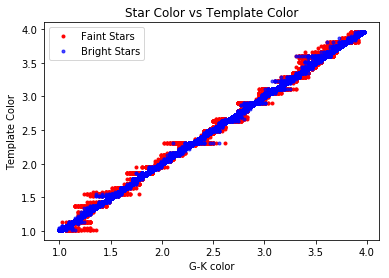

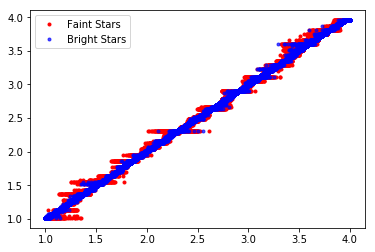

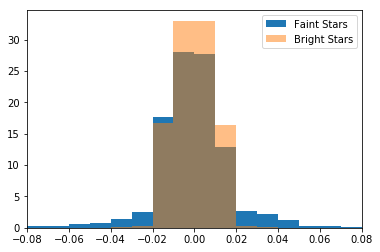

Mean Val for Bright Stars: -7.65696467941e-05
Mean Val for Faint Stars: -0.000951069689369

Median Val for Bright Stars: -4.38011547299e-05
Median Val for Faint Stars: -0.000764766074176


In [330]:
# star_bin_vals_dm = np.array(star_bin_vals_dm)
# temp_bin_vals_dm = np.array(temp_bin_vals_dm)

starColor_dm = np.array(starColor_dm)
templateColor_dm = np.array(templateColor_dm)

plt.plot(starColor_dm,templateColor_dm,'.',color='red',label='Faint Stars')
plt.plot(starColor_br,templateColor_br,'.',color='blue',alpha=0.7,label='Bright Stars')
plt.title('Star Color vs Template Color')
plt.xlabel('G-K color')
plt.ylabel('Template Color')
plt.legend()
plt.show()

diff_color_dm = []
for i in range(len(all_dimStars)):
    starBands= np.array(all_dimStars[i])
    starBands = starBands[~np.isnan(starBands)]
    if(len(starBands) == len(all_dimStars[0])):
        diff_color_dm.append(starBands[0] - starBands[5])
diff_color_dm = np.array(diff_color_dm)
plt.plot(diff_color_dm,templateColor_dm,'.',color='red',label='Faint Stars')
plt.plot(diff_color_br,templateColor_br,'.',color='blue',alpha=0.7,label='Bright Stars')
plt.legend()
plt.show()


diff_dm = (diff_color_dm - templateColor_dm)
diff_temp_dm = abs(starColor_dm - templateColor_dm)
bins=np.arange(-.5,.5,0.01)
#bins=[-.12,-0.09,-0.06,-0.03,0.0,0.03,0.06,0.09,0.12]
plt.hist(diff_dm,bins=bins,normed=True,label='Faint Stars')
plt.hist(diff_br,bins=bins,normed=True,alpha=0.5,label='Bright Stars')
plt.xlim([-.08,.08])
plt.legend()
plt.show()
print('Mean Val for Bright Stars:',np.mean(diff_br))
print('Mean Val for Faint Stars:',np.mean(diff_dm))
print('\nMedian Val for Bright Stars:',np.median(diff_br))
print('Median Val for Faint Stars:',np.median(diff_dm))
# bins = [0.0,0.03,0.06,0.09,0.12]
# plt.hist(diff_temp_dm,bins=bins,normed=True,label='Faint Stars')
# plt.hist(diff_temp_br,bins=bins,normed=True,label='Bright Stars',alpha=0.7)
# plt.legend()
# plt.xlim([0,.15])
# plt.show()

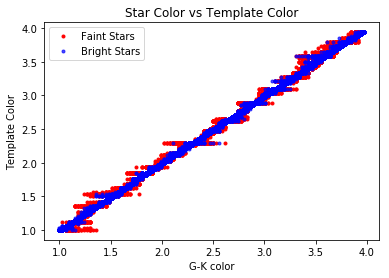

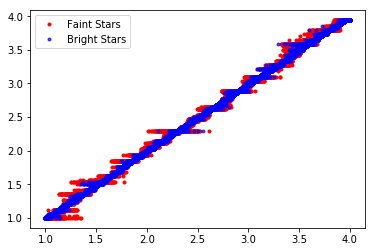

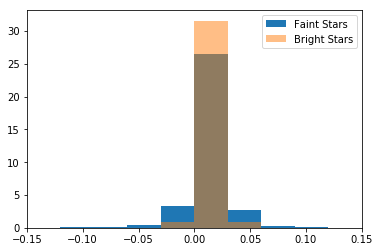

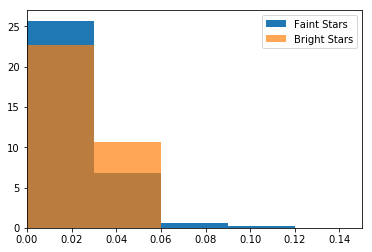

In [272]:
# star_bin_vals_dm = np.array(star_bin_vals_dm)
# temp_bin_vals_dm = np.array(temp_bin_vals_dm)

plt.plot(star_bin_vals_dm,temp_bin_vals_dm,'.',color='red',label='Faint Stars')
plt.plot(star_bin_vals_br,temp_bin_vals_br,'.',color='blue',alpha=0.7,label='Bright Stars')
plt.title('Star Color vs Template Color')
plt.xlabel('G-K color')
plt.ylabel('Template Color')
plt.legend()
plt.show()

diff_color_dm = []
for i in range(len(all_dimStars)):
    starBands= np.array(all_dimStars[i])
    starBands = starBands[~np.isnan(starBands)]
    if(len(starBands) == len(all_dimStars[0])):
        diff_color_dm.append(starBands[0] - starBands[5])
diff_color_dm = np.array(diff_color_dm)
plt.plot(diff_color_dm,temp_bin_vals_dm,'.',color='red',label='Faint Stars')
plt.plot(diff_color_br,temp_bin_vals_br,'.',color='blue',alpha=0.7,label='Bright Stars')
plt.legend()
plt.show()


diff_dm = (diff_color_dm - temp_bin_vals_dm)
diff_temp_dm = abs(star_bin_vals_dm - temp_bin_vals_dm)

bins=[-.12,-0.09,-0.06,-0.03,0.0,0.03,0.06,0.09,0.12]
plt.hist(diff_dm,bins=bins,normed=True,label='Faint Stars')
plt.hist(diff_br,bins=bins,normed=True,alpha=0.5,label='Bright Stars')
plt.xlim([-.15,.15])
plt.legend()
plt.show()
bins = [0.0,0.03,0.06,0.09,0.12]
plt.hist(diff_temp_dm,bins=bins,normed=True,label='Faint Stars')
plt.hist(diff_temp_br,bins=bins,normed=True,label='Bright Stars',alpha=0.7)
plt.legend()
plt.xlim([0,.15])
plt.show()

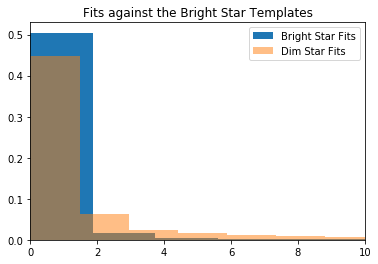

Mean Reduced Chi Squared Value for Bright Star Fits: 1.13491367237
Median Reduced Chi Squared Value for Bright Star Fits: 0.494589678387

Mean Reduced Chi Squared Value for Dim Star Fits: 9.18825651218
Median Reduced Chi Squared Value for Dim Star Fits: 0.885572919885


In [273]:
plt.hist(br_redChi2_bright,500,normed=True,label='Bright Star Fits')
plt.hist(br_redChi2_dim,500,normed=True,label='Dim Star Fits',alpha=0.5)
plt.title('Fits against the Bright Star Templates')
plt.legend()
plt.xlim([0,10])
plt.show()
print('Mean Reduced Chi Squared Value for Bright Star Fits:',np.mean(br_redChi2_bright))
print('Median Reduced Chi Squared Value for Bright Star Fits:', np.median(br_redChi2_bright))
print('\nMean Reduced Chi Squared Value for Dim Star Fits:', np.mean(br_redChi2_dim))
print('Median Reduced Chi Squared Value for Dim Star Fits:', np.median(br_redChi2_dim))


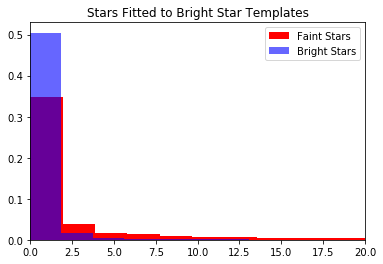

Mean Reduced Chi Squared Value for Bright Star Fits: 1.13491367237
Median Reduced Chi Squared Value for Bright Star Fits: 0.494589678387

Mean Reduced Chi Squared Value for Dim Star Fits: 10.73005763
Median Reduced Chi Squared Value for Dim Star Fits: 0.936807212284


In [263]:
plt.hist(red_Chi2_vals_dm,500,normed=True,label='Faint Stars',color='red')
plt.hist(red_Chi2_vals_br,500,normed=True,label='Bright Stars',color='blue',alpha=0.6)
plt.legend()
plt.xlim([0,20])
plt.title('Stars Fitted to Bright Star Templates')
plt.show()
print('Mean Reduced Chi Squared Value for Bright Star Fits:',np.mean(red_Chi2_vals_br))
print('Median Reduced Chi Squared Value for Bright Star Fits:', np.median(red_Chi2_vals_br))
print('\nMean Reduced Chi Squared Value for Dim Star Fits:', np.mean(red_Chi2_vals_dm))
print('Median Reduced Chi Squared Value for Dim Star Fits:', np.median(red_Chi2_vals_dm))


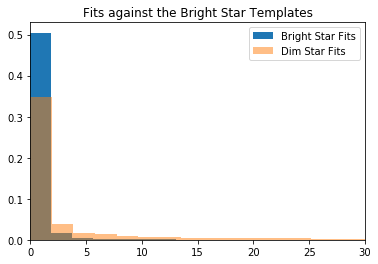

Mean Reduced Chi Squared Value for Bright Star Fits: 1.13491367237
Median Reduced Chi Squared Value for Bright Star Fits: 0.494589678387

Mean Reduced Chi Squared Value for Dim Star Fits: 10.73005763
Median Reduced Chi Squared Value for Dim Star Fits: 0.936807212284


In [87]:
plt.hist(br_redChi2_bright,500,normed=True,label='Bright Star Fits')
plt.hist(br_redChi2_dim,500,normed=True,label='Dim Star Fits',alpha=0.5)
plt.title('Fits against the Bright Star Templates')
plt.legend()
plt.xlim([0,30])
plt.show()
print('Mean Reduced Chi Squared Value for Bright Star Fits:',np.mean(br_redChi2_bright))
print('Median Reduced Chi Squared Value for Bright Star Fits:', np.median(br_redChi2_bright))
print('\nMean Reduced Chi Squared Value for Dim Star Fits:', np.mean(br_redChi2_dim))
print('Median Reduced Chi Squared Value for Dim Star Fits:', np.median(br_redChi2_dim))




# REMOVING SPURIOUS DATA FROM BRIGHT AND FAINT STARS AND BUILDING NEW TEMPLATES & CALCULATE NEW X^2 VALUES (BRIGHT STAR TEMPLATES)

In [314]:
new_bands_bright = []
new_bands_dim = []
for i in range(len(all_brightStars)):
    starBands = np.array(all_brightStars[i])
    starBands = starBands[~np.isnan(starBands)]
    if(len(starBands) == len(all_brightStars[0])):
        new_bands_bright.append(starBands)
        
# for i in range(len(all_dimStars)):
#     starBands = np.array(all_dimStars[i])
#     starBands = starBands[~np.isnan(starBands)]
#     if(len(starBands) == len(all_dimStars[0])):
#         new_bands_dim.append(starBands)
        
new_bands_bright = np.array(new_bands_bright)
#new_bands_dim = np.array(new_bands_dim)

In [112]:
print(len(new_bands_dim),len(red_Chi2_vals_dm))

278142 278142


In [315]:
better_br_bands = []
#better_dim_bands = []
#red_Chi2_vals_dm = np.array(red_Chi2_vals_dm)
starChi2_br = np.array(starChi2_br)
#red_Chi2_vals_br = np.array(red_Chi2_vals_br)
for i in range(len(new_bands_bright)):
    if(starChi2_br[i] <= 5.0):
        better_br_bands.append(new_bands_bright[i])
        #better_brFits.append(br_brightFits[i])
# for i in range(len(new_bands_dim)):    
#     if(red_Chi2_vals_dm[i] <= 5.0):
#         better_dim_bands.append(new_bands_dim[i])
        #better_dimFits.append(br_dimFits[i])
better_br_bands = np.array(better_br_bands)
#better_dim_bands = np.array(better_dim_bands)


In [316]:
colors = np.arange(1,4,0.03) # EDIT THIS TO USE DESIRED NUMBER OF COLORS

# BRIGHT STARS
best_color_br = ColorClassification(better_br_bands[:,0],better_br_bands[:,5],colors)

best_stars_br,best_color_mags_br,best_color_std_br,best_color_std_err_br,best_abs_color_mags_br, \
best_abs_color_std_br,best_abs_color_std_err_br = \
CreateTemplates(best_color_br,colors,Gmags=better_br_bands[:,0],Kmags=better_br_bands[:,5],\
                GB_mags=better_br_bands[:,1],GR_mags=better_br_bands[:,2],J_mags=better_br_bands[:,3],\
                H_mags=better_br_bands[:,4])

# DIM STARS
# best_color_dm = ColorClassification(better_dim_bands[:,0],better_dim_bands[:,5],colors)

# best_stars_dm,best_color_mags_dm,best_color_std_dm,best_color_std_err_dm,best_abs_color_mags_dm,\
# best_abs_color_std_dm,best_abs_color_std_err_dm = \
# CreateTemplates(best_color_dm,colors,Gmags=better_dim_bands[:,0],Kmags=better_dim_bands[:,5],\
#                 GB_mags=better_dim_bands[:,1],GR_mags=better_dim_bands[:,2],J_mags=better_dim_bands[:,3],\
#                 H_mags=better_dim_bands[:,4])

/astromake/opt/python/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:108: RuntimeWarning: Mean of empty slice
/astromake/opt/python/anaconda3/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1423: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/astromake/opt/python/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:111: RuntimeWarning: Mean of empty slice


In [317]:
# best_star_bin_vals_br = []
# best_temp_bin_vals_br = []
# best_red_Chi2_vals_br = []

bestStarColor_br = []
bestTemplateColor_br = []
bestStarChi2_br = []


mags = copy.copy(best_color_mags_br)
std = copy.copy(best_color_std_br)
mags = mags[1:len(mags)]
std = std[1:len(std)]
for i in range(len(better_br_bands)):
    
    starBands= np.array(better_br_bands[i])
    starBands = starBands[~np.isnan(starBands)]
    if(len(starBands) == len(better_br_bands[0])):
        #starBands = np.array(starBands)
        fit, new_starBand, red_Chi2 = StarFitting(starBands,mags,std)
        #best_temp_bin_vals_br.append(colors[fit])
        bestTemplateColor_br.append(mags[fit,9])
        #best_red_Chi2_vals_br.append(red_Chi2)
        bestStarChi2_br.append(red_Chi2[0])
        diff_vals = []
        for j in range(len(colors)):
            diff = abs(colors[j] - new_starBand[4])
            diff_vals.append(diff)

        for j in range(len(diff_vals)):
            if(diff_vals[j] == np.min(diff_vals)):
                #best_star_bin_vals_br.append(colors[j])
                bestStarColor_br.append(colors[j])
# best_star_bin_vals_br = np.array(best_star_bin_vals_br)
# best_temp_bin_vals_br = np.array(best_temp_bin_vals_br)
# best_red_Chi2_vals_br = np.array(best_red_Chi2_vals_br)

bestStarColor_br = np.array(bestStarColor_br)
bestTemplateColor_br = np.array(bestTemplateColor_br)
bestStarChi2_br = np.array(bestStarChi2_br)


In [325]:
test = np.arange(-.10,.10,.01)
print(test)

[ -1.00000000e-01  -9.00000000e-02  -8.00000000e-02  -7.00000000e-02
  -6.00000000e-02  -5.00000000e-02  -4.00000000e-02  -3.00000000e-02
  -2.00000000e-02  -1.00000000e-02  -5.55111512e-17   1.00000000e-02
   2.00000000e-02   3.00000000e-02   4.00000000e-02   5.00000000e-02
   6.00000000e-02   7.00000000e-02   8.00000000e-02   9.00000000e-02]


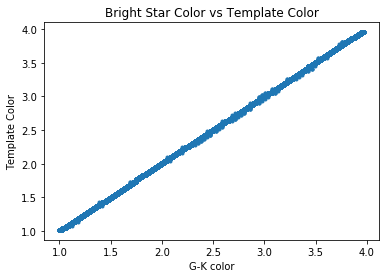

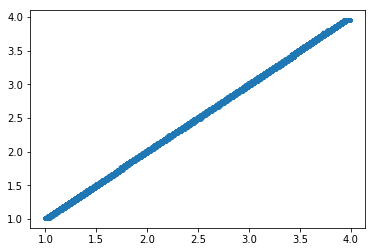

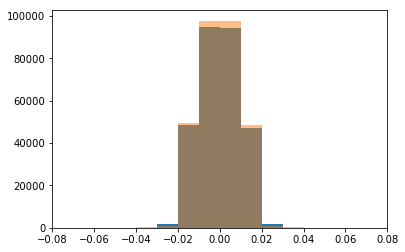

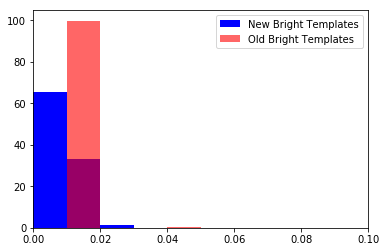

-7.65696467941e-05
-4.38011547299e-05
-7.66336725016e-05
-8.69436610111e-05


In [354]:
plt.plot(bestStarColor_br,bestTemplateColor_br,'.')
plt.title('Bright Star Color vs Template Color')
plt.xlabel('G-K color')
plt.ylabel('Template Color')
plt.show()

best_diff_color_br = []
for i in range(len(better_br_bands)):
    starBands= np.array(better_br_bands[i])
    starBands = starBands[~np.isnan(starBands)]
    if(len(starBands) == len(better_br_bands[0])):
        best_diff_color_br.append(starBands[0] - starBands[5])
best_diff_color_br = np.array(best_diff_color_br)
plt.plot(best_diff_color_br,bestTemplateColor_br,'.')
plt.show()

best_diff_br = (best_diff_color_br - bestTemplateColor_br)
#best_diff_temp_br = abs(bestStarColor_br - bestTemplateColor_br)
best_diff_temp_br = abs(best_diff_color_br - bestTemplateColor_br)
bins=np.arange(-.5,.5,0.005)
h1=plt.hist(best_diff_br,bins=bins,normed=False)
h2=plt.hist(diff_br,bins=bins,normed=False,alpha=0.5)
plt.xlim([-.08,.08])
plt.show()
bins=np.arange(0.0,0.5,0.01)
bins1 = plt.hist(best_diff_temp_br,bins=bins,normed=True,color='blue',label='New Bright Templates')
bins2 = plt.hist(diff_temp_br,bins=bins,normed=True,alpha=0.6,color='red',label='Old Bright Templates')
plt.xlim([0,.10])
plt.legend()
#plt.ylim([0,1000])
plt.show()
print(np.mean(diff_br))
print(np.median(diff_br))
print(np.mean(best_diff_br))
print(np.median(best_diff_br))

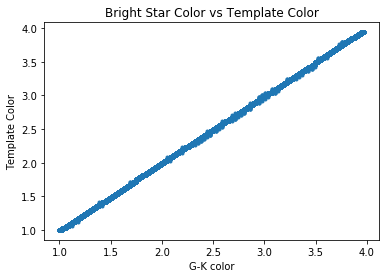

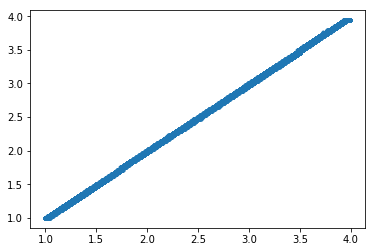

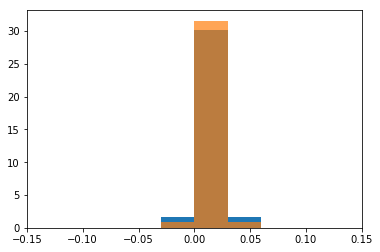

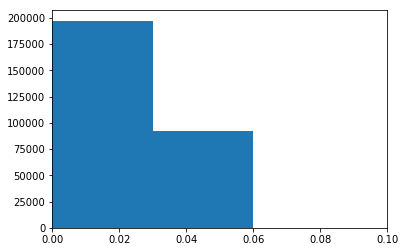

0.0149026465172
0.014937210083
0.0149013332398
0.0148910903931


In [321]:
plt.plot(best_star_bin_vals_br,best_temp_bin_vals_br,'.')
plt.title('Bright Star Color vs Template Color')
plt.xlabel('G-K color')
plt.ylabel('Template Color')
plt.show()

best_diff_color_br = []
for i in range(len(better_br_bands)):
    starBands= np.array(better_br_bands[i])
    starBands = starBands[~np.isnan(starBands)]
    if(len(starBands) == len(better_br_bands[0])):
        best_diff_color_br.append(starBands[0] - starBands[5])
best_diff_color_br = np.array(best_diff_color_br)
plt.plot(best_diff_color_br,best_temp_bin_vals_br,'.')
plt.show()

best_diff_br = (best_diff_color_br - best_temp_bin_vals_br)
best_diff_temp_br = abs(best_star_bin_vals_br - best_temp_bin_vals_br)
bins=[-.12,-0.09,-0.06,-0.03,0.0,0.03,0.06,0.09,0.12]
h1=plt.hist(best_diff_br,bins=bins,normed=True)
h2=plt.hist(diff_br,bins=bins,normed=True,alpha=0.7)
plt.xlim([-.15,.15])
plt.show()
bins=[0.0,0.03,0.06,0.09,0.12]
bins = plt.hist(best_diff_temp_br,bins=bins,normed=False)
plt.xlim([0,.10])
plt.show()
print(np.mean(diff_br))
print(np.median(diff_br))
print(np.mean(best_diff_br))
print(np.median(best_diff_br))

In [281]:
print(len(best_diff_br))

289289


In [343]:
# best_star_bin_vals_dm = []
# best_temp_bin_vals_dm = []
# best_red_Chi2_vals_dm = []

bestStarColor_dm = []
bestTemplateColor_dm = []
bestStarChi2_dm = []


mags = copy.copy(best_color_mags_br)
std = copy.copy(best_color_std_br)
mags = mags[1:len(mags)]
std = std[1:len(std)]
for i in range(len(all_dimStars)):
    
    starBands= np.array(all_dimStars[i])
    starBands = starBands[~np.isnan(starBands)]
    if(len(starBands) == len(all_dimStars[0])):
        #starBands = np.array(starBands)
        fit, new_starBand, red_Chi2 = StarFitting(starBands,mags,std)
#         best_temp_bin_vals_dm.append(colors[fit])
#         best_red_Chi2_vals_dm.append(red_Chi2)
        bestTemplateColor_dm.append(mags[fit,9])
        bestStarChi2_dm.append(red_Chi2[0])
        diff_vals = []
        for j in range(len(colors)):
            diff = abs(colors[j] - new_starBand[4])
            diff_vals.append(diff)

        for j in range(len(diff_vals)):
            if(diff_vals[j] == np.min(diff_vals)):
                #best_star_bin_vals_dm.append(colors[j])
                bestStarColor_dm.append(colors[j])

bestStarColor_dm = np.array(bestStarColor_dm)
bestTemplateColor_dm = np.array(bestTemplateColor_dm)
bestStarChi2_dm = np.array(bestStarChi2_dm)
                
# best_star_bin_vals_dm = np.array(best_star_bin_vals_dm)
# best_temp_bin_vals_dm = np.array(best_temp_bin_vals_dm)
# best_red_Chi2_vals_dm = np.array(best_red_Chi2_vals_dm)

192696


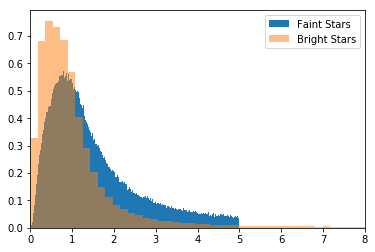

Bright Mean: 1.19258030596
Faint Mean: 1.52459819045

Bright Median: 0.79374477321
Faint Median: 1.20456221466


In [264]:

chi2 = copy.copy(best_red_Chi2_vals_dm)
chi2 = chi2[chi2<=5.0]
print(len(chi2))
plt.hist(chi2,200,normed=True,label='Faint Stars')
plt.hist(best_red_Chi2_vals_br,200,normed=True,alpha=0.5,label='Bright Stars')
plt.xlim([0,8])
plt.legend()
plt.show()
print('Bright Mean:',np.mean(best_red_Chi2_vals_br))
print('Faint Mean:',np.mean(chi2))
print('\nBright Median:',np.median(best_red_Chi2_vals_br))
print('Faint Median:',np.median(chi2))


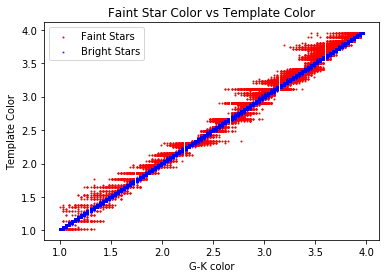

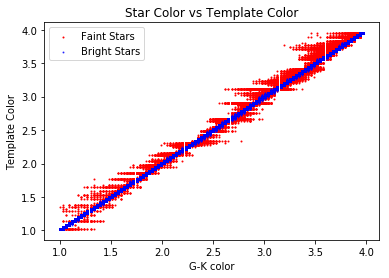

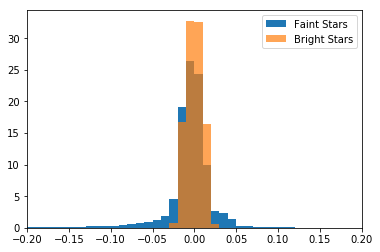

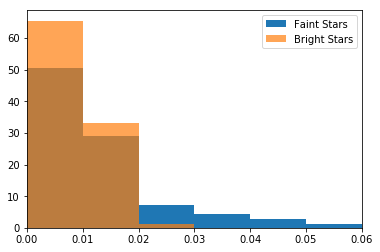

In [350]:
#plt.plot(bestStarColor_dm,bestTemplateColor_dm,'.',color='red',label='Faint Stars')
#plt.plot(bestStarColor_br,bestTemplateColor_br,'.',color='blue',label='Bright Stars',alpha=0.7)
plt.scatter(bestStarColor_dm,bestTemplateColor_dm,s=1.0,color='red',label='Faint Stars')
plt.scatter(bestStarColor_br,bestTemplateColor_br,s=1.0,color='blue',label='Bright Stars',alpha=0.7)
plt.title('Faint Star Color vs Template Color')
plt.xlabel('G-K color')
plt.ylabel('Template Color')
plt.legend()
plt.show()

best_diff_color_dm = []
for i in range(len(all_dimStars)):
    starBands= np.array(all_dimStars[i])
    starBands = starBands[~np.isnan(starBands)]
    if(len(starBands) == len(all_dimStars[0])):
        best_diff_color_dm.append(starBands[0] - starBands[5])
best_diff_color_dm = np.array(best_diff_color_dm)
#plt.plot(bestStarColor_dm,bestTemplateColor_dm,'.',color='red',label='Faint Stars')
#plt.plot(bestStarColor_br,bestTemplateColor_br,'.',color='blue',label='Bright Stars',alpha=0.7)
plt.scatter(bestStarColor_dm,bestTemplateColor_dm,s=1.0,color='red',label='Faint Stars')
plt.scatter(bestStarColor_br,bestTemplateColor_br,s=1.0,color='blue',label='Bright Stars',alpha=0.7)
plt.title('Star Color vs Template Color')
plt.xlabel('G-K color')
plt.ylabel('Template Color')
plt.legend()
plt.show()

best_diff_dm = (best_diff_color_dm - bestTemplateColor_dm)
#best_diff_temp_dm = abs(bestStarColor_dm - bestTemplateColor_dm)
best_diff_temp_dm = abs(best_diff_color_dm - bestTemplateColor_dm)
#bins = [-.12,-0.09,-0.06,-0.03,0.0,0.03,0.06,0.09,.12]
bins=np.arange(-.2,.2,0.01)
#bins = [-0.10,-0.07,-0.04-0.01,0.01,0.04,0.07,0.10]
#bins=range(min(data), max(data) + binwidth, binwidth
binwidth = 0.03
plot1_dm=plt.hist(best_diff_dm,bins=bins,normed=True,label='Faint Stars')
plot1_br=plt.hist(best_diff_br,bins=bins,normed=True,label='Bright Stars',alpha=0.7)
plt.legend()
plt.xlim([-.2,.2])
plt.show()
# print('Mean Diff val for Bright Stars:',np.mean(best_diff_br))
# print('Mean Diff val for Faint Stars:',np.mean(best_diff_dm))
bins=np.arange(0.0,0.5,0.01)
#bins = [0.0,0.03,0.06,0.09,0.12,0.15,0.18]
plot2_dm = plt.hist(best_diff_temp_dm,bins=bins,normed=True,label='Faint Stars')
plot2_br = plt.hist(best_diff_temp_br,bins=bins,normed=True,label='Bright Stars',alpha=0.7)
plt.legend()
plt.xlim([0,.06])
plt.show()
# print('Mean Diff val for Bright Stars:',np.mean(best_diff_temp_br))
# print('Mean Diff val for Faint Stars:',np.mean(best_diff_temp_dm))

In [ ]:
mags = copy.copy(best_color_mags_br)
mags = mags[1:len(mags)]
GBcolor = []
count = 0
for i in range(len(bestTemplateColor_br)):
     for j in range(len(mags)):
            if(mags[j,9] == bestTemplateColor_br[i]):
                starGB = better_br_bands[:,0] - better_br_bands[:,1]
                GBcolor.append([starGB,mags[j,2]])
GBcolor = np.array(GBcolor)



During handling of the above exception, another exception occurred:


Error in atexit._run_exitfuncs:
Traceback (most recent call last):

Error in atexit._run_exitfuncs:
Traceback (most recent call last):
  File "/astromake/opt/python/anaconda3/lib/python3.6/site-packages/matplotlib/_pylab_helpers.py", line 85, in destroy_all
KeyboardInterrupt
Traceback (most recent call last):
  File "/astromake/opt/python/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3214, in atexit_operations
    self.history_manager.end_session()
  File "/astromake/opt/python/anaconda3/lib/python3.6/site-packages/traitlets/traitlets.py", line 545, in __get__
    def __get__(self, obj, cls=None):
KeyboardInterrupt


In [364]:
print(mags[1])

[        nan         nan -0.25690859         nan         nan  0.37116211
         nan  0.79437958  0.98870806  1.04543075]


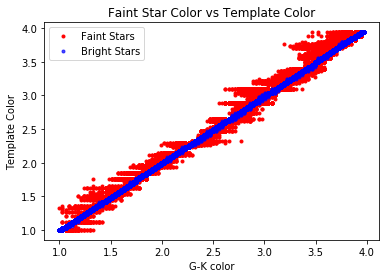

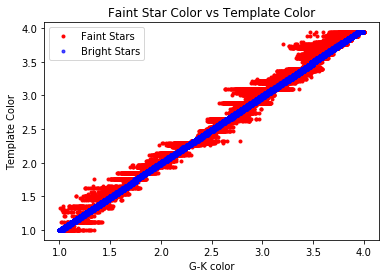

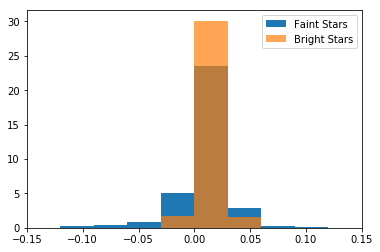

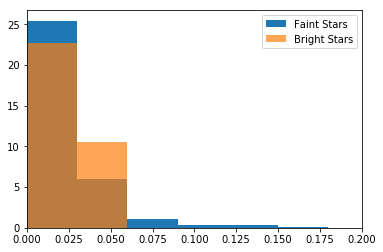

In [275]:
plt.plot(best_star_bin_vals_dm,best_temp_bin_vals_dm,'.',color='red',label='Faint Stars')
plt.plot(best_star_bin_vals_br,best_temp_bin_vals_br,'.',color='blue',label='Bright Stars',alpha=0.7)
plt.title('Faint Star Color vs Template Color')
plt.xlabel('G-K color')
plt.ylabel('Template Color')
plt.legend()
plt.show()

best_diff_color_dm = []
for i in range(len(all_dimStars)):
    starBands= np.array(all_dimStars[i])
    starBands = starBands[~np.isnan(starBands)]
    if(len(starBands) == len(all_dimStars[0])):
        best_diff_color_dm.append(starBands[0] - starBands[5])
best_diff_color_dm = np.array(best_diff_color_dm)
plt.plot(best_diff_color_dm,best_temp_bin_vals_dm,'.',color='red',label='Faint Stars')
plt.plot(best_diff_color_br,best_temp_bin_vals_br,'.',color='blue',label='Bright Stars',alpha=0.7)
plt.title('Faint Star Color vs Template Color')
plt.xlabel('G-K color')
plt.ylabel('Template Color')
plt.legend()
plt.show()

best_diff_dm = (best_diff_color_dm - best_temp_bin_vals_dm)
best_diff_temp_dm = abs(best_star_bin_vals_dm - best_temp_bin_vals_dm)
bins = [-.12,-0.09,-0.06,-0.03,0.0,0.03,0.06,0.09,.12]
#bins = [-0.10,-0.07,-0.04-0.01,0.01,0.04,0.07,0.10]
#bins=range(min(data), max(data) + binwidth, binwidth
binwidth = 0.03
plot1_dm=plt.hist(best_diff_dm,bins=bins,normed=True,label='Faint Stars')
plot1_br=plt.hist(best_diff_br,bins=bins,normed=True,label='Bright Stars',alpha=0.7)
plt.legend()
plt.xlim([-.15,.15])
plt.show()
# print('Mean Diff val for Bright Stars:',np.mean(best_diff_br))
# print('Mean Diff val for Faint Stars:',np.mean(best_diff_dm))

bins = [0.0,0.03,0.06,0.09,0.12,0.15,0.18]
plot2_dm = plt.hist(best_diff_temp_dm,bins=bins,normed=True,label='Faint Stars')
plot2_br = plt.hist(best_diff_temp_br,bins=bins,normed=True,label='Bright Stars',alpha=0.7)
plt.legend()
plt.xlim([0,.20])
plt.show()
# print('Mean Diff val for Bright Stars:',np.mean(best_diff_temp_br))
# print('Mean Diff val for Faint Stars:',np.mean(best_diff_temp_dm))

In [107]:
# CALCULATE REDUCED CHI SQUARED VALUES FOR BRIGHT STAR TEMPLATES USING BRIGHT STARS (1-4)
# AFTER REMOVING OUTLIERS
best_chiBright = []
bestBrightFits = []
br_mags = copy.copy(best_color_mags_br)
br_std = copy.copy(best_color_std_br)
br_mags = br_mags[1:len(br_mags)]
br_std = br_std[1:len(br_std)]
for i in range(len(better_br_bands)):
    starBands= np.array(better_br_bands[i])
    starBands = starBands[~np.isnan(starBands)]
    if(len(starBands) == len(better_br_bands[0])):
        #starBands = np.array(starBands)
        fit, new_starBand, red_Chi2 = StarFitting(starBands,br_mags,br_std)
        chi2 = red_Chi2[0]
        best_chiBright.append(chi2)
        bestBrightFits.append(fit)
        

best_chiBright = np.array(best_chiBright)
bestBrightFits = np.array(bestBrightFits)

In [108]:
# CALCULATE REDUCED CHI SQUARED VALUE FOR DIM STARS USING BRIGHT STAR TEMPLATES (1-4)
# AFTER REMOVING OUTLIERS
best_chiDim = []
bestDimFits = []
br_mags = copy.copy(best_color_mags_br)
br_std = copy.copy(best_color_std_br)
br_mags = br_mags[1:len(br_mags)]
br_std = br_std[1:len(br_std)]
for i in range(len(better_dim_bands)):
    starBands= np.array(better_dim_bands[i])
    starBands = starBands[~np.isnan(starBands)]
    if(len(starBands) == len(better_dim_bands[0])):
        #starBands = np.array(starBands)
        fit, new_starBand, red_Chi2 = StarFitting(starBands,br_mags,br_std)
        chi2 = red_Chi2[0]
        best_chiDim.append(chi2)
        bestDimFits.append(fit)

best_chiDim = np.array(best_chiDim)
bestDimFits = np.array(bestDimFits)

KeyboardInterrupt: 

# DISTRIBUTIONS OF RED X^2 FOR BRIGHT AND FAINT STARS FITTED ONTO BRIGHT STAR TEMPLATES AFTER REMOVING SPURIOUS DATA

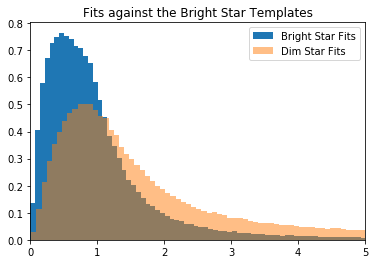

Mean Reduced Chi Squared Value for Bright Star Fits: 1.19258030596
Median Reduced Chi Squared Value for Bright Star Fits: 0.79374477321

Mean Reduced Chi Squared Value for Dim Star Fits: 2.18304512937
Median Reduced Chi Squared Value for Dim Star Fits: 1.32772006414


In [133]:
plt.hist(best_chiBright,500,normed=True,label='Bright Star Fits')
plt.hist(best_chiDim,500,normed=True,label='Dim Star Fits',alpha=0.5)
plt.title('Fits against the Bright Star Templates')
plt.legend()
plt.xlim([0,5])
plt.show()
print('Mean Reduced Chi Squared Value for Bright Star Fits:',np.mean(best_chiBright))
print('Median Reduced Chi Squared Value for Bright Star Fits:', np.median(best_chiBright))
print('\nMean Reduced Chi Squared Value for Dim Star Fits:', np.mean(best_chiDim))
print('Median Reduced Chi Squared Value for Dim Star Fits:', np.median(best_chiDim))


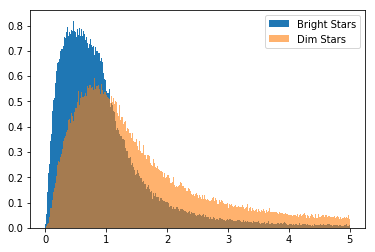

Mean Reduced Chi Squared for Bright Stars: 0.965265621088
Median Reduced Chi Squared for Bright Stars: 0.772223839591
STD of Reduced Chi Squared for Bright Stars: 0.786673441159
Standard Error for Bright Stars: 0.00148483406826

Mean Reduced Chi Squared for Dim Stars: 1.52459819045
Median Reduced Chi Squared for Dim Stars: 1.20456221466
STD of Reduced Chi Squared for Dim Stars: 1.08868060998
Standard Error for Dim Stars: 0.00248007113743


In [130]:
better_br = []
better_dim = []
for i in range(len(best_chiBright)):
    if(best_chiBright[i] <= 5.0):
        better_br.append(best_chiBright[i])
for i in range(len(best_chiDim)):    
    if(best_chiDim[i] <= 5.0):
        better_dim.append(best_chiDim[i])

plt.hist(better_br,500,normed=True,alpha=1.0,label='Bright Stars')
plt.hist(better_dim,500,normed=True,alpha=0.6,label='Dim Stars')
#plt.xlim([0,20])
plt.legend()
plt.show()
print('Mean Reduced Chi Squared for Bright Stars:',np.mean(better_br))
print('Median Reduced Chi Squared for Bright Stars:',np.median(better_br))
print('STD of Reduced Chi Squared for Bright Stars:', np.std(better_br))
print('Standard Error for Bright Stars:', np.std(better_br)/np.sqrt(len(better_br)))
print('\nMean Reduced Chi Squared for Dim Stars:',np.mean(better_dim))
print('Median Reduced Chi Squared for Dim Stars:',np.median(better_dim))
print('STD of Reduced Chi Squared for Dim Stars:', np.std(better_dim))
print('Standard Error for Dim Stars:', np.std(better_dim)/np.sqrt(len(better_dim)))

# CALCULATING REDUCED X^2 FOR BRIGHT AND FAINT STARS ONTO FAINT STAR TEMPLATES BETWEEN 1-4 G-K & WILL THEN REMOVE SPURIOUS DATA 

In [15]:
# FIT BRIGHT STARS TO FAINT STAR TEMPLATES
# dim_star_bin_vals_br = []
# dim_temp_bin_vals_br = []
# dim_red_Chi2_vals_br = []

faintStarColor_br = []
faintTemplateColor_br = []
faintStarChi2_br = []

mags = copy.copy(color_mags_dm)
std = copy.copy(color_std_dm)
mags = mags[1:len(mags)]
std = std[1:len(std)]
for i in range(len(all_brightStars)):
    
    starBands= np.array(all_brightStars[i])
    starBands = starBands[~np.isnan(starBands)]
    if(len(starBands) == len(all_brightStars[0])):
        #starBands = np.array(starBands)
        fit, new_starBand, red_Chi2 = StarFitting(starBands,mags,std)
        faintTemplateColor_br.append(mags[fit,9])
        faintStarChi2_br.append(red_Chi2[0])
        diff_vals = []
        for j in range(len(colors)):
            diff = abs(colors[j] - new_starBand[4])
            diff_vals.append(diff)

        for j in range(len(diff_vals)):
            if(diff_vals[j] == np.min(diff_vals)):
                faintStarColor_br.append(colors[j])

faintStarColor_br = np.array(faintStarColor_br)
faintTemplateColor_br = np.array(faintTemplateColor_br)
faintStarChi2_br = np.array(faintStarChi2_br)

# dim_star_bin_vals_br = np.array(dim_star_bin_vals_br)
# dim_temp_bin_vals_br = np.array(dim_temp_bin_vals_br)
# dim_red_Chi2_vals_br = np.array(dim_red_Chi2_vals_br)

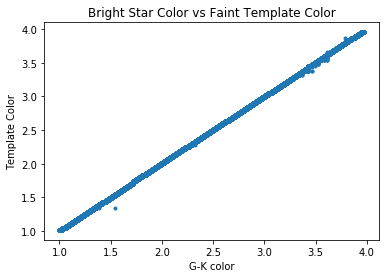

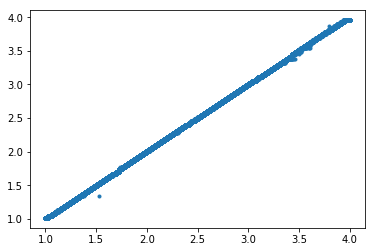

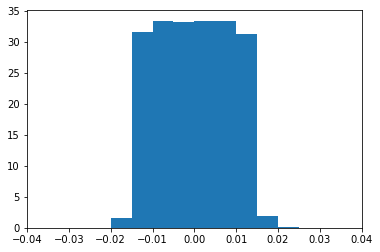

4.23831530013e-05
2.11976815119e-05


In [17]:

plt.plot(faintStarColor_br,faintTemplateColor_br,'.')
plt.title('Bright Star Color vs Faint Template Color')
plt.xlabel('G-K color')
plt.ylabel('Template Color')
plt.show()

dim_diff_color_br = []
for i in range(len(all_brightStars)):
    starBands= np.array(all_brightStars[i])
    starBands = starBands[~np.isnan(starBands)]
    if(len(starBands) == len(all_brightStars[0])):
        dim_diff_color_br.append(starBands[0] - starBands[5])
dim_diff_color_br = np.array(dim_diff_color_br)
plt.plot(dim_diff_color_br,faintTemplateColor_br,'.')
plt.show()

dim_diff_br = (dim_diff_color_br - faintTemplateColor_br)
#dim_diff_temp_br = abs(dim_star_bin_vals_br - dim_temp_bin_vals_br)
#bins=[-.12,-0.09,-0.06,-0.03,0.0,0.03,0.06,0.09,0.12]
bins=np.arange(-.5,.5,0.005)
plt.hist(dim_diff_br,bins=bins,normed=True)
plt.xlim([-.04,.04])
plt.show()
print(np.mean(dim_diff_br))
print(np.median(dim_diff_br))
# bins=[0.0,0.03,0.06,0.09,0.12,.15,.18]
# bins = plt.hist(dim_diff_temp_br,bins=bins,normed=False)
# plt.xlim([0,.20])
# plt.show()

In [173]:
print(all_dimStars[0])

[ 16.30409813  17.6627121   15.15303516  13.65299988  13.1619997
  12.88899994]


In [18]:
# dim_star_bin_vals_dm = []
# dim_temp_bin_vals_dm = []
# dim_red_Chi2_vals_dm = []

faintTemplateColor_dm = []
faintStarChi2_dm = []
faintStarColor_dm = []

mags = copy.copy(color_mags_dm)
std = copy.copy(color_std_dm)
mags = mags[1:len(mags)]
std = std[1:len(std)]
for i in range(len(all_dimStars)):
    
    starBands= np.array(all_dimStars[i])
    starBands = starBands[~np.isnan(starBands)]
    if(len(starBands) == len(all_dimStars[0])):
        #starBands = np.array(starBands)
        fit, new_starBand, red_Chi2 = StarFitting(starBands,mags,std)
        faintTemplateColor_dm.append(mags[fit,9])
        faintStarChi2_dm.append(red_Chi2[0])
        diff_vals = []
        for j in range(len(colors)):
            diff = abs(colors[j] - new_starBand[4])
            diff_vals.append(diff)

        for j in range(len(diff_vals)):
            if(diff_vals[j] == np.min(diff_vals)):
                faintStarColor_dm.append(colors[j])

faintTemplateColor_dm = np.array(faintTemplateColor_dm)
faintStarChi2_dm = np.array(faintStarChi2_dm)
faintStarColor_dm = np.array(faintStarColor_dm)

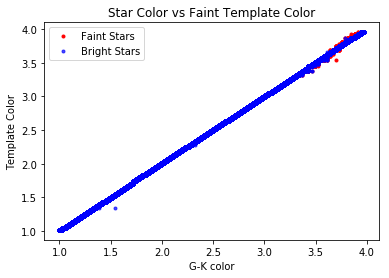

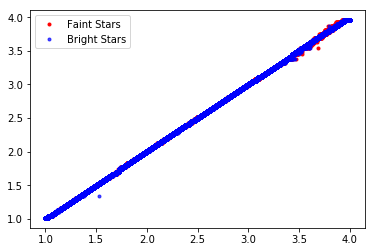

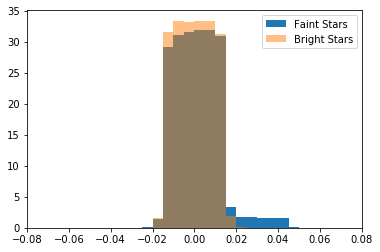

In [19]:
plt.plot(faintStarColor_dm,faintTemplateColor_dm,'.',color='red',label='Faint Stars')
plt.plot(faintStarColor_br,faintTemplateColor_br,'.',color='blue',alpha=0.7,label='Bright Stars')
plt.title('Star Color vs Faint Template Color')
plt.xlabel('G-K color')
plt.ylabel('Template Color')
plt.legend()
plt.show()

dim_diff_color_dm = []
for i in range(len(all_dimStars)):
    starBands= np.array(all_dimStars[i])
    starBands = starBands[~np.isnan(starBands)]
    if(len(starBands) == len(all_dimStars[0])):
        dim_diff_color_dm.append(starBands[0] - starBands[5])
dim_diff_color_dm = np.array(dim_diff_color_dm)
plt.plot(dim_diff_color_dm,faintTemplateColor_dm,'.',color='red',label='Faint Stars')
plt.plot(dim_diff_color_br,faintTemplateColor_br,'.',color='blue',alpha=0.7,label='Bright Stars')
plt.legend()
plt.show()

bins = np.arange(-.5,.5,0.005)
#bins = [-0.12,-0.09,-0.06,-0.03,0.0,0.03,0.06,0.09,0.12]
dim_diff_dm = (dim_diff_color_dm - faintTemplateColor_dm)
#dim_diff_temp_dm = abs(dim_star_bin_vals_dm - faintTemplateColor_br)
plt.hist(dim_diff_dm,bins=bins,normed=True,label='Faint Stars')
plt.hist(dim_diff_br,bins=bins,normed=True,alpha=0.5,label='Bright Stars')
plt.xlim([-.08,.08])
plt.legend()
plt.show()
# bins = [0.0,0.03,0.06,0.09,0.12]
# plt.hist(dim_diff_temp_dm,bins=bins,normed=True,label='Faint Stars')
# plt.hist(dim_diff_temp_br,bins=bins,normed=True,label='Bright Stars',alpha=0.7)
# plt.legend()
# plt.xlim([0,.15])
# plt.show()

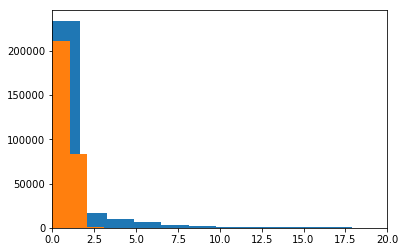

1.36912625557
0.830767690887


In [278]:
plt.hist(dim_red_Chi2_vals_dm,200)
plt.hist(dim_red_Chi2_vals_br,200)
plt.xlim([0,20])
plt.show()
print(np.mean(dim_red_Chi2_vals_dm))
print(np.mean(dim_red_Chi2_vals_br))

In [20]:
#new_dimBands_bright = []
new_dimBands_dim = []
# for i in range(len(all_brightStars)):
#     starBands = np.array(all_brightStars[i])
#     starBands = starBands[~np.isnan(starBands)]
#     if(len(starBands) == len(all_brightStars[0])):
#         new_dimBands_bright.append(starBands)
        
for i in range(len(all_dimStars)):
    starBands = np.array(all_dimStars[i])
    starBands = starBands[~np.isnan(starBands)]
    if(len(starBands) == len(all_dimStars[0])):
        new_dimBands_dim.append(starBands)
        
#new_dimBands_bright = np.array(new_dimBands_bright)
new_dimBands_dim = np.array(new_dimBands_dim)

In [22]:
#better_br_bands_dim = []
better_dim_bands_dim = []

# for i in range(len(new_bands_bright)):
#     if(dim_red_Chi2_vals_br[i] <= 5.0):
#         better_br_bands_dim.append(new_dimBands_bright[i])
        #better_brFits.append(br_brightFits[i])
for i in range(len(new_dimBands_dim)):    
    if(faintStarChi2_dm[i] <= 5.0):
        better_dim_bands_dim.append(new_dimBands_dim[i])
        #better_dimFits.append(br_dimFits[i])
#better_br_bands_dim = np.array(better_br_bands_dim)
better_dim_bands_dim = np.array(better_dim_bands_dim)

In [23]:
colors = np.arange(1,4,0.03) # EDIT THIS TO USE DESIRED NUMBER OF COLORS


# DIM STARS
best_color_dm = ColorClassification(better_dim_bands_dim[:,0],better_dim_bands_dim[:,5],colors)

best_stars_dm,best_color_mags_dm,best_color_std_dm,best_color_std_err_dm,best_abs_color_mags_dm,\
best_abs_color_std_dm,best_abs_color_std_err_dm = \
CreateTemplates(best_color_dm,colors,Gmags=better_dim_bands_dim[:,0],Kmags=better_dim_bands_dim[:,5],\
                GB_mags=better_dim_bands_dim[:,1],GR_mags=better_dim_bands_dim[:,2],\
                J_mags=better_dim_bands_dim[:,3],\
                H_mags=better_dim_bands_dim[:,4])

/astromake/opt/python/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:108: RuntimeWarning: Mean of empty slice
/astromake/opt/python/anaconda3/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1423: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/astromake/opt/python/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:111: RuntimeWarning: Mean of empty slice


In [24]:
# best_star_bin_vals_br_dim = [] # Bright Stars fitted onto better Faint Star Templates
# best_temp_bin_vals_br_dim = []
# best_red_Chi2_vals_br_dim = []

bestFaintStarColor_br = []
bestFaintTemplateColor_br = []
bestFaintStarChi2_br = []


mags = copy.copy(best_color_mags_dm)
std = copy.copy(best_color_std_dm)
mags = mags[1:len(mags)]
std = std[1:len(std)]
for i in range(len(all_brightStars)):
    
    starBands= np.array(all_brightStars[i])
    starBands = starBands[~np.isnan(starBands)]
    if(len(starBands) == len(all_brightStars[0])):
        #starBands = np.array(starBands)
        fit, new_starBand, red_Chi2 = StarFitting(starBands,mags,std)
        bestFaintTemplateColor_br.append(mags[fit,9])
        bestFaintStarChi2_br.append(red_Chi2[0])
        diff_vals = []
        for j in range(len(colors)):
            diff = abs(colors[j] - new_starBand[4])
            diff_vals.append(diff)

        for j in range(len(diff_vals)):
            if(diff_vals[j] == np.min(diff_vals)):
                bestFaintStarColor_br.append(colors[j])

bestFaintStarColor_br = np.array(bestFaintStarColor_br)
bestFaintTemplateColor_br = np.array(bestFaintTemplateColor_br)
bestFaintStarChi2_br = np.array(bestFaintStarChi2_br)

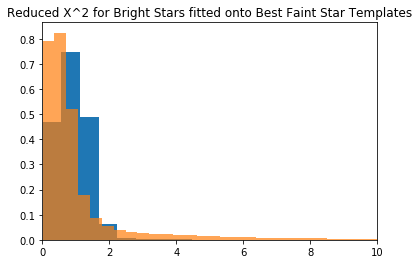

1.02900567416
1.299312865


In [224]:
plt.hist(best_red_Chi2_vals_br_dim,1200,normed=True)
plt.hist(best_red_Chi2_vals_dm_dim,80,normed=True,alpha=0.7)
plt.xlim([0,10])
plt.title('Reduced X^2 for Bright Stars fitted onto Best Faint Star Templates')
plt.show()
print(np.mean(best_red_Chi2_vals_br_dim))
print(np.mean(best_red_Chi2_vals_dm_dim))

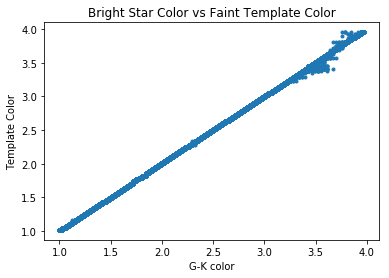

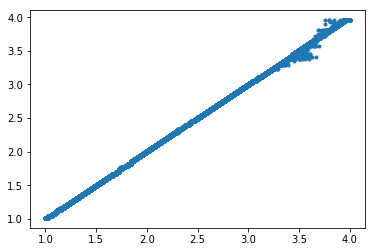

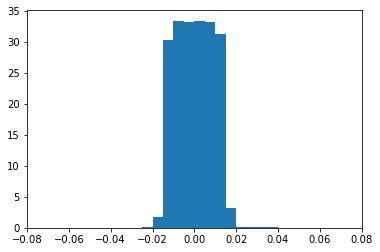

0.000229751956356
0.000189779908487


In [25]:
plt.plot(bestFaintStarColor_br,bestFaintTemplateColor_br,'.')
plt.title('Bright Star Color vs Faint Template Color')
plt.xlabel('G-K color')
plt.ylabel('Template Color')
plt.show()

best_dim_diff_color_br = []
for i in range(len(all_brightStars)):
    starBands= np.array(all_brightStars[i])
    starBands = starBands[~np.isnan(starBands)]
    if(len(starBands) == len(all_brightStars[0])):
        best_dim_diff_color_br.append(starBands[0] - starBands[5])
best_dim_diff_color_br = np.array(best_dim_diff_color_br)
plt.plot(best_dim_diff_color_br,bestFaintTemplateColor_br,'.')
plt.show()

best_dim_diff_br = (best_dim_diff_color_br - bestFaintTemplateColor_br)
#best_dim_diff_temp_br = abs(best_star_bin_vals_br_dim - bestFaintTemplateColor_br)

bins = np.arange(-.5,.5,0.005)
#bins = [-0.09,-0.06,-0.03,0.0,0.03,0.06,0.09]
plt.hist(best_dim_diff_br,bins=bins,normed=True)
plt.xlim([-.08,.08])
plt.show()
print(np.mean(best_dim_diff_br))
print(np.median(best_dim_diff_br))
# bins = [0.0,0.03,0.06,0.09]
# bins = plt.hist(best_dim_diff_temp_br,bins=bins,normed=False)
# plt.xlim([0,.10])
# plt.show()

In [26]:
# best_star_bin_vals_dm_dim = [] # Faint Stars fitted onto better Faint Star Templates
# best_temp_bin_vals_dm_dim = []
# best_red_Chi2_vals_dm_dim = []


bestFaintStarColor_dm = []
bestFaintTemplateColor_dm = []
bestFaintStarChi2_dm = []


mags = copy.copy(best_color_mags_dm)
std = copy.copy(best_color_std_dm)
mags = mags[1:len(mags)]
std = std[1:len(std)]
for i in range(len(better_dim_bands_dim)):
    
    starBands= np.array(better_dim_bands_dim[i])
    starBands = starBands[~np.isnan(starBands)]
    if(len(starBands) == len(better_dim_bands_dim[0])):
        #starBands = np.array(starBands)
        fit, new_starBand, red_Chi2 = StarFitting(starBands,mags,std)
        bestFaintTemplateColor_dm.append(mags[fit,9])
        bestFaintStarChi2_dm.append(red_Chi2[0])
        diff_vals = []
        for j in range(len(colors)):
            diff = abs(colors[j] - new_starBand[4])
            diff_vals.append(diff)

        for j in range(len(diff_vals)):
            if(diff_vals[j] == np.min(diff_vals)):
                bestFaintStarColor_dm.append(colors[j])

bestFaintStarColor_dm = np.array(bestFaintStarColor_dm)
bestFaintTemplateColor_dm = np.array(bestFaintTemplateColor_dm)
bestFaintStarChi2_dm = np.array(bestFaintStarChi2_dm)

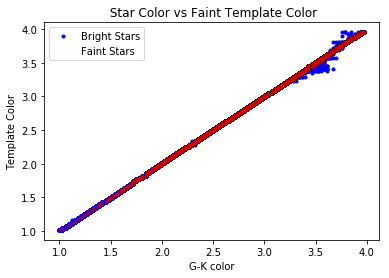

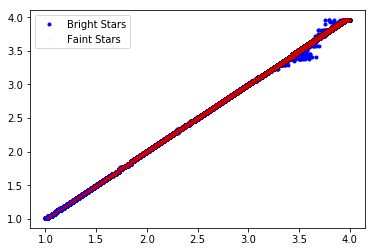

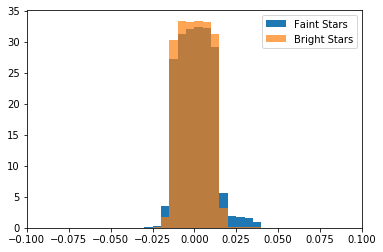

In [27]:
plt.plot(bestFaintStarColor_br,bestFaintTemplateColor_br,'.',color='blue',label='Bright Stars')

plt.plot(bestFaintStarColor_dm,bestFaintTemplateColor_dm,'.',color='red',label='Faint Stars',alpha=0.02)
plt.title(' Star Color vs Faint Template Color')
plt.xlabel('G-K color')
plt.ylabel('Template Color')
plt.legend()
plt.show()

best_dim_diff_color_dm = []
for i in range(len(better_dim_bands_dim)):
    starBands= np.array(better_dim_bands_dim[i])
    starBands = starBands[~np.isnan(starBands)]
    if(len(starBands) == len(better_dim_bands_dim[0])):
        best_dim_diff_color_dm.append(starBands[0] - starBands[5])
best_dim_diff_color_dm = np.array(best_dim_diff_color_dm)
plt.plot(best_dim_diff_color_br,bestFaintTemplateColor_br,'.',color='blue',label='Bright Stars')
plt.plot(best_dim_diff_color_dm,bestFaintTemplateColor_dm,'.',color='red',label='Faint Stars',alpha=0.02)
plt.legend()
plt.show()

best_dim_diff_dm = (best_dim_diff_color_dm - bestFaintTemplateColor_dm)
#best_dim_diff_temp_dm = abs(best_star_bin_vals_dm_dim - best_temp_bin_vals_dm_dim)
bins = np.arange(-.5,.5,0.005)
#bins = [-0.09,-0.06,-0.03,0.0,0.03,0.06,0.09]
plt.hist(best_dim_diff_dm,bins=bins,normed=True,label='Faint Stars')
plt.hist(best_dim_diff_br,bins=bins,normed=True,label='Bright Stars',alpha=0.7)
plt.xlim([-.10,.10])
plt.legend()
plt.show()


# bins = [0.0,0.03,0.06,0.09,0.12]
# plot2_br = plt.hist(best_dim_diff_temp_br,bins=bins,normed=False,label='Bright Stars')
# plot2_dm = plt.hist(best_dim_diff_temp_dm,bins=bins,normed=False,label='Faint Stars',alpha=0.7)
# plt.xlim([0,.10])
# plt.legend()
# plt.show()

# FITTING ALL STARS TO BRIGHT AND FAINT TEMPLATES

In [34]:
allStars = []
for i in range(len(Gmags)):
    if(Gmags[i] < 15 and (Gmag[i] - Kmag[i]) >= 1.0 and (Gmag[i]-Kmag[i]) <= 4.0):
        allStars.append([Gmag[i],GBmag[i],GRmag[i],Jmag[i],Hmag[i],Kmag[i]])
print(len(allStars))

573979


[ 16.30409813  17.6627121   15.15303516  13.65299988  13.1619997
  12.88899994]


In [ ]:
allTemplateColor_br = []
allStarColor_br = []
allStarChi2_br = []

mags = copy.copy(color_mags_br)
std = copy.copy(color_std_br)
mags = mags[1:len(mags)]
std = std[1:len(std)]
for i in range(len(allStars)):
    
    starBands= np.array(allStars[i])
    starBands = starBands[~np.isnan(starBands)]
    if(len(starBands) == len(allStars[0])):
        #starBands = np.array(starBands)
        fit, new_starBand, red_Chi2 = StarFitting(starBands,mags,std)
        allTemplateColor_br.append(mags[fit,9])
        allStarChi2_br.append(red_Chi2[0])
        diff_vals = []
        for j in range(len(colors)):
            diff = abs(colors[j] - new_starBand[4])
            diff_vals.append(diff)

        for j in range(len(diff_vals)):
            if(diff_vals[j] == np.min(diff_vals)):
                allStarColor_br.append(colors[j])

allTemplateColor_br = np.array(allTemplateColor_br)
allStarColor_br = np.array(allStarColor_br)
allStarChi2_br = np.array(allStarChi2_br)

In [ ]:
plt.scatter(allStarColor_br,allTemplateColor_br,s=1.0)
plt.show()

allGK = []
for i in range(len(allStars)):
    starBands = allStars[i]
    starBands = starBands[~np.isnan(starBands)]
    if(len(starBands) == allStars[0]):
        allGK.append(allStars[0] - allStars[5])
allGK = np.array(allGK)

colorDiff = allGK - allTemplateColor_br
bins = np.arange(-0.10,0.10,0.005)
plt.hist(colorDiff,bins=bins,normed=True)
plt.xlim([-0.08,0.08])
plt.title('All Stars Fitted to Bright Star Templates')
plt.xlabel('G-K Color Difference')

In [ ]:
allTemplateColor_dm = []
allStarColor_dm = []
allStarChi2_dm = []

mags = copy.copy(color_mags_dm)
std = copy.copy(color_std_dm)
mags = mags[1:len(mags)]
std = std[1:len(std)]
for i in range(len(allStars)):
    
    starBands= np.array(allStars[i])
    starBands = starBands[~np.isnan(starBands)]
    if(len(starBands) == len(allStars[0])):
        #starBands = np.array(starBands)
        fit, new_starBand, red_Chi2 = StarFitting(starBands,mags,std)
        allTemplateColor_dm.append(mags[fit,9])
        allStarChi2_dm.append(red_Chi2[0])
        diff_vals = []
        for j in range(len(colors)):
            diff = abs(colors[j] - new_starBand[4])
            diff_vals.append(diff)

        for j in range(len(diff_vals)):
            if(diff_vals[j] == np.min(diff_vals)):
                allStarColor_dm.append(colors[j])

allTemplateColor_dm = np.array(allTemplateColor_dm)
allStarColor_dm = np.array(allStarColor_dm)
allStarChi2_dm = np.array(allStarChi2_dm)

In [ ]:
plt.scatter(allStarColor_dm,allTemplateColor_dm,s=1.0)
plt.show()

allGK = []
for i in range(len(allStars)):
    starBands = allStars[i]
    starBands = starBands[~np.isnan(starBands)]
    if(len(starBands) == allStars[0]):
        allGK.append(allStars[0] - allStars[5])
allGK = np.array(allGK)

colorDiff = allGK - allTemplateColor_br
bins = np.arange(-0.10,0.10,0.005)
plt.hist(colorDiff,bins=bins,normed=True)
plt.xlim([-0.08,0.08])
plt.title('All Stars Fitted to Bright Star Templates')
plt.xlabel('G-K Color Difference')

# CALCULATING RED X^2 VALUES FOR G-K RANGE FROM 1-2 & 2-4 USING FAINT STAR TEMPLATES

In [166]:
colors = np.arange(2,4,0.03)
color_dm = ColorClassification(dm_Gmag,dm_Kmag,colors)

stars_dm,color_mags_dm,color_std_dm,color_std_err_dm,abs_color_mags_dm,abs_color_std_dm,abs_color_std_err_dm = \
CreateTemplates(color_dm,colors,dm_Gmag,dm_Kmag,GB_mags=dm_GBmag,GR_mags=dm_GRmag,J_mags=dm_Jmag,H_mags=dm_Hmag)

/astromake/opt/python/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:108: RuntimeWarning: Mean of empty slice
/astromake/opt/python/anaconda3/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1423: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/astromake/opt/python/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:111: RuntimeWarning: Mean of empty slice


In [156]:
# CALCULATING REDUCED X^2 USING FAINT STAR TEMPLATES BY FITTING BRIGHT STARS G_K: 1-2
dm_redChi2_bright12 = []
br_bands12 = []
dm_mags = copy.copy(color_mags_dm)
dm_std = copy.copy(color_std_dm)
dm_mags = dm_mags[1:len(dm_mags)]
dm_std = dm_std[1:len(dm_std)]
for i in range(len(all_brightStars12)):
    starBands= np.array(all_brightStars12[i])
    starBands = starBands[~np.isnan(starBands)]
    if(len(starBands) == len(all_brightStars12[0])):
        #starBands = np.array(starBands)
        fit, new_starBand, red_Chi2 = StarFitting(starBands,dm_mags,dm_std)
        chi2 = red_Chi2[0]
        dm_redChi2_bright12.append(chi2)
        br_bands12.append(starBands)
dm_redChi2_bright12 = np.array(dm_redChi2_bright12)
br_bands12 = np.array(br_bands12)

In [157]:
# CALCULATING REDUCED X^2 USING FAINT STAR TEMPLATES BY FITTING FAINT STARS G-K: 1-2
dm_redChi2_dim12 = []
dm_bands12 = []
dm_mags = copy.copy(color_mags_dm)
dm_std = copy.copy(color_std_dm)
dm_mags = dm_mags[1:len(dm_mags)]
dm_std = dm_std[1:len(dm_std)]
for i in range(len(all_dimStars12)):
    starBands= np.array(all_dimStars12[i])
    starBands = starBands[~np.isnan(starBands)]
    if(len(starBands) == len(all_dimStars12[0])):
        #starBands = np.array(starBands)
        fit, new_starBand, red_Chi2 = StarFitting(starBands,dm_mags,dm_std)
        chi2 = red_Chi2[0]
        dm_redChi2_dim12.append(chi2)
        dm_bands12.append(starBands)
dm_redChi2_dim12 = np.array(dm_redChi2_dim12)
dm_bands12 = np.array(dm_bands12)

In [173]:
better_brBands12 = []
better_dmBands12 = []
for i in range(len(br_bands12)):
    if(dm_redChi2_bright12[i] <= 5.0):
        better_brBands12.append(br_bands12[i])
for i in range(len(dm_bands12)):    
    if(dm_redChi2_dim12[i] <= 5.0):
        better_dmBands12.append(dm_bands12[i])
better_brBands12 = np.array(better_brBands12)
better_dmBands12 = np.array(better_dmBands12)
print('Finished Part 1\n')       
colors = np.arange(1,2,0.03) # EDIT THIS TO USE DESIRED NUMBER OF COLORS

# BRIGHT STARS
best_color_br12 = ColorClassification(better_brBands12[:,0],better_brBands12[:,5],colors)

best_stars_br12,best_color_mags_br12,best_color_std_br12,best_color_std_err_br12,best_abs_color_mags_br12, \
best_abs_color_std_br12,best_abs_color_std_err_br12 = \
CreateTemplates(best_color_br12,colors,Gmags=better_brBands12[:,0],Kmags=better_brBands12[:,5],\
                GB_mags=better_brBands12[:,1],GR_mags=better_brBands12[:,2],J_mags=better_brBands12[:,3],\
                H_mags=better_brBands12[:,4])

# DIM STARS
best_color_dm12 = ColorClassification(better_dmBands12[:,0],better_dmBands12[:,5],colors)

best_stars_dm12,best_color_mags_dm12,best_color_std_dm12,best_color_std_err_dm12,best_abs_color_mags_dm12,\
best_abs_color_std_dm12,best_abs_color_std_err_dm12 = \
CreateTemplates(best_color_dm12,colors,Gmags=better_dmBands12[:,0],Kmags=better_dmBands12[:,5],\
                GB_mags=better_dmBands12[:,1],GR_mags=better_dmBands12[:,2],J_mags=better_dmBands12[:,3],\
                H_mags=better_dmBands12[:,4])

print('Finished part 2\n')

dm_bestChi_br12 = []
dm_mags = copy.copy(best_color_mags_dm12)
dm_std = copy.copy(best_color_std_dm12)
dm_mags = dm_mags[1:len(dm_mags)]
dm_std = dm_std[1:len(dm_std)]
for i in range(len(better_brBands12)):
    starBands= np.array(better_brBands12[i])
    starBands = starBands[~np.isnan(starBands)]
    if(len(starBands) == len(better_brBands12[0])):
        #starBands = np.array(starBands)
        fit, new_starBand, red_Chi2 = StarFitting(starBands,dm_mags,dm_std)
        chi2 = red_Chi2[0]
        dm_bestChi_br12.append(chi2)
        
dm_bestChi_br12 = np.array(dm_bestChi_br12)

print('Finished part 3\n')

dm_bestChi_dm12 = []
dm_mags = copy.copy(best_color_mags_dm12)
dm_std = copy.copy(best_color_std_dm12)
dm_mags = dm_mags[1:len(dm_mags)]
dm_std = dm_std[1:len(dm_std)]
for i in range(len(better_dmBands12)):
    starBands= np.array(better_dmBands12[i])
    starBands = starBands[~np.isnan(starBands)]
    if(len(starBands) == len(better_dmBands12[0])):
        #starBands = np.array(starBands)
        fit, new_starBand, red_Chi2 = StarFitting(starBands,dm_mags,dm_std)
        chi2 = red_Chi2[0]
        dm_bestChi_dm12.append(chi2)
        
dm_bestChi_dm12 = np.array(dm_bestChi_dm12)



Finished Part 1



/astromake/opt/python/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:108: RuntimeWarning: Mean of empty slice
/astromake/opt/python/anaconda3/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1423: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/astromake/opt/python/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:111: RuntimeWarning: Mean of empty slice


Finished part 2

Finished part 3



In [170]:
# CALCULATING REDUCED X^2 USING FAINT STAR TEMPLATES BY FITTING BRIGHT STARS G_K: 2-4
dm_redChi2_bright24 = []
dm_bands_br24 = []
dm_mags = copy.copy(color_mags_dm)
dm_std = copy.copy(color_std_dm)
dm_mags = dm_mags[1:len(dm_mags)]
dm_std = dm_std[1:len(dm_std)]
for i in range(len(all_brightStars24)):
    starBands= np.array(all_brightStars24[i])
    starBands = starBands[~np.isnan(starBands)]
    if(len(starBands) == len(all_brightStars24[0])):
        #starBands = np.array(starBands)
        fit, new_starBand, red_Chi2 = StarFitting(starBands,dm_mags,dm_std)
        chi2 = red_Chi2[0]
        dm_redChi2_bright24.append(chi2)
        dm_bands_br24.append(starBands)
dm_redChi2_bright24 = np.array(dm_redChi2_bright24)
dm_bands_br24 = np.array(dm_bands_br24)

In [46]:
print(len(dm_redChi2_dim24),len(new_starBand))

274099 5


In [171]:
# CALCULATING REDUCED X^2 USING FAINT STAR TEMPLATES BY FITTING FAINT STARS G-K: 2-4
dm_redChi2_dim24 = []
dm_bands_dm24 = []
dm_mags = copy.copy(color_mags_dm)
dm_std = copy.copy(color_std_dm)
dm_mags = dm_mags[1:len(dm_mags)]
dm_std = dm_std[1:len(dm_std)]
for i in range(len(all_dimStars24)):
    starBands= np.array(all_dimStars24[i])
    starBands = starBands[~np.isnan(starBands)]
    if(len(starBands) == len(all_dimStars24[0])):
        #starBands = np.array(starBands)
        fit, new_starBand, red_Chi2 = StarFitting(starBands,dm_mags,dm_std)
        chi2 = red_Chi2[0]
        dm_redChi2_dim24.append(chi2)
        dm_bands_dm24.append(starBands)
dm_redChi2_dim24 = np.array(dm_redChi2_dim24)
dm_bands_dm24 = np.array(dm_bands_dm24)

In [175]:
better_brBands24 = []
better_dmBands24= []
for i in range(len(dm_bands_br24)):
    if(dm_redChi2_bright24[i] <= 5.0):
        better_brBands24.append(dm_bands_br24[i])
for i in range(len(dm_bands_dm24)):    
    if(dm_redChi2_dim24[i] <= 5.0):
        better_dmBands24.append(dm_bands_dm24[i])
better_brBands24 = np.array(better_brBands24)
better_dmBands24 = np.array(better_dmBands24)

print('Finished Part 1\n')       
colors = np.arange(2,4,0.03) # EDIT THIS TO USE DESIRED NUMBER OF COLORS

# BRIGHT STARS
# best_color_br24 = ColorClassification(better_brBands24[:,0],better_brBands24[:,5],colors)

# best_stars_br24,best_color_mags_br24,best_color_std_br24,best_color_std_err_br24,best_abs_color_mags_br24, \
# best_abs_color_std_br24,best_abs_color_std_err_br24 = \
# CreateTemplates(best_color_br24,colors,Gmags=better_dmBands_br12[:,0],Kmags=better_dmBands_br12[:,5],\
#                 GB_mags=better_dmBands_br12[:,1],GR_mags=better_dmBands_br12[:,2],J_mags=better_dmBands_br12[:,3],\
#                 H_mags=better_dmBands_br12[:,4])

# DIM STARS
best_color_dm24 = ColorClassification(better_dmBands24[:,0],better_dmBands24[:,5],colors)

best_stars_dm24,best_color_mags_dm24,best_color_std_dm24,best_color_std_err_dm24,best_abs_color_mags_dm24,\
best_abs_color_std_dm24,best_abs_color_std_err_dm24 = \
CreateTemplates(best_color_dm24,colors,Gmags=better_dmBands24[:,0],Kmags=better_dmBands24[:,5],\
                GB_mags=better_dmBands24[:,1],GR_mags=better_dmBands24[:,2],J_mags=better_dmBands24[:,3],\
                H_mags=better_dmBands24[:,4])

print('Finished part 2\n')

dm_bestChi_br24 = []
dm_mags = copy.copy(best_color_mags_dm24)
dm_std = copy.copy(best_color_std_dm24)
dm_mags = dm_mags[1:len(dm_mags)]
dm_std = dm_std[1:len(dm_std)]
for i in range(len(better_brBands24)):
    starBands= np.array(better_brBands24[i])
    starBands = starBands[~np.isnan(starBands)]
    if(len(starBands) == len(better_brBands24[0])):
        #starBands = np.array(starBands)
        fit, new_starBand, red_Chi2 = StarFitting(starBands,dm_mags,dm_std)
        chi2 = red_Chi2[0]
        dm_bestChi_br24.append(chi2)
        
dm_bestChi_br24 = np.array(dm_bestChi_br24)

print('Finished part 3\n')

dm_bestChi_dm24 = []
dm_mags = copy.copy(best_color_mags_dm24)
dm_std = copy.copy(best_color_std_dm24)
dm_mags = dm_mags[1:len(dm_mags)]
dm_std = dm_std[1:len(dm_std)]
for i in range(len(better_dmBands24)):
    starBands= np.array(better_dmBands24[i])
    starBands = starBands[~np.isnan(starBands)]
    if(len(starBands) == len(better_dmBands24[0])):
        #starBands = np.array(starBands)
        fit, new_starBand, red_Chi2 = StarFitting(starBands,dm_mags,dm_std)
        chi2 = red_Chi2[0]
        dm_bestChi_dm24.append(chi2)
        
dm_bestChi_dm24 = np.array(dm_bestChi_dm24)



Finished Part 1



/astromake/opt/python/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:108: RuntimeWarning: Mean of empty slice
/astromake/opt/python/anaconda3/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1423: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/astromake/opt/python/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:111: RuntimeWarning: Mean of empty slice


Finished part 2

Finished part 3



In [179]:
dm_bestChi_dm24 = []
dm_mags = copy.copy(best_color_mags_dm24)
dm_std = copy.copy(best_color_std_dm24)
dm_mags = dm_mags[1:len(dm_mags)]
dm_std = dm_std[1:len(dm_std)]
for i in range(len(better_dmBands24)):
    starBands= np.array(better_dmBands24[i])
    starBands = starBands[~np.isnan(starBands)]
    if(len(starBands) == len(better_dmBands24[0])):
        #starBands = np.array(starBands)
        fit, new_starBand, red_Chi2 = StarFitting(starBands,dm_mags,dm_std)
        chi2 = red_Chi2[0]
        dm_bestChi_dm24.append(chi2)
        
dm_bestChi_dm24 = np.array(dm_bestChi_dm24)

# Red X^2 Distributions for G-K 1-2 & 2-4 for Bright and Faint Stars Fitted to Faint Star Templates

In [77]:
print(len(dm_redChi2_bright12)/100)
print(len(dm_redChi2_dim12)/100)

814.15
40.43


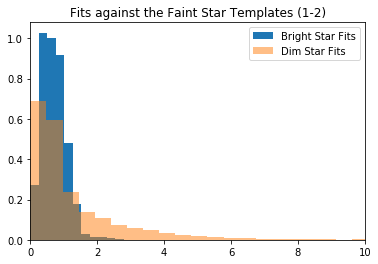

Mean Reduced Chi Squared Value for Bright Star Fits: 0.722389985892
Median Reduced Chi Squared Value for Bright Star Fits: 0.68991124237

Mean Reduced Chi Squared Value for Dim Star Fits: 1.26634004695
Median Reduced Chi Squared Value for Dim Star Fits: 0.744433865976


In [180]:
plt.hist(dm_redChi2_bright12,810,normed=True,label='Bright Star Fits')
plt.hist(dm_redChi2_dim12,40,normed=True,label='Dim Star Fits',alpha=0.5)
plt.title('Fits against the Faint Star Templates (1-2)')
plt.legend()
plt.xlim([0,10])
plt.show()
print('Mean Reduced Chi Squared Value for Bright Star Fits:',np.mean(dm_redChi2_bright12))
print('Median Reduced Chi Squared Value for Bright Star Fits:', np.median(dm_redChi2_bright12))
print('\nMean Reduced Chi Squared Value for Dim Star Fits:', np.mean(dm_redChi2_dim12))
print('Median Reduced Chi Squared Value for Dim Star Fits:', np.median(dm_redChi2_dim12))

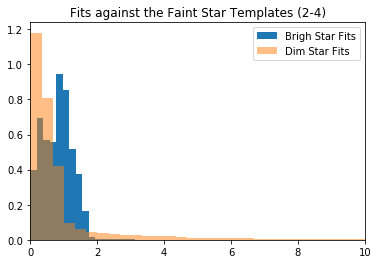

Mean Reduced Chi Squared Value for Bright Star Fits: 0.872542075829
Median Reduced Chi Squared Value for Bright Star Fits: 0.866348460895

Mean Reduced Chi Squared Value for Dim Star Fits: 1.28553201264
Median Reduced Chi Squared Value for Dim Star Fits: 0.45298837762


In [32]:
plt.hist(dm_redChi2_bright24,1000,normed=True,label='Bright Star Fits')
plt.hist(dm_redChi2_dim24,1000,normed=True,label='Dim Star Fits',alpha=0.5)
plt.title('Fits against the Faint Star Templates (2-4)')
plt.legend()
plt.xlim([0,10])
plt.show()
print('Mean Reduced Chi Squared Value for Bright Star Fits:',np.mean(dm_redChi2_bright24))
print('Median Reduced Chi Squared Value for Bright Star Fits:', np.median(dm_redChi2_bright24))
print('\nMean Reduced Chi Squared Value for Dim Star Fits:', np.mean(dm_redChi2_dim24))
print('Median Reduced Chi Squared Value for Dim Star Fits:', np.median(dm_redChi2_dim24))

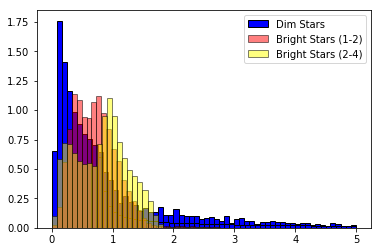

Mean Reduced Chi Squared for Bright Stars (1-2): 0.717943421413
Median Reduced Chi Squared for Bright Stars (1-2): 0.689760530369
STD of Reduced Chi Squared for Bright Stars (1-2): 0.364638465818

Mean Reduced Chi Squared for Dim Stars (1-2): 1.08706825325
Median Reduced Chi Squared for Dim Stars (1-2): 0.716647368953
STD of Reduced Chi Squared for Dim Stars (1-2): 1.03473548499

Mean Reduced Chi Squared for Bright Stars (2-4): 0.828906634457
Median Reduced Chi Squared for Bright Stars (2-4): 0.865056452866
STD of Reduced Chi Squared for Bright Stars (2-4): 0.450427105506

Mean Reduced Chi Squared for Dim Stars (2-4): 0.682500867845
Median Reduced Chi Squared for Dim Stars (2-4): 0.423034621502
STD of Reduced Chi Squared for Dim Stars (2-4): 0.840309772286


In [44]:
better_br_12 = []
better_dim_12 = []
for i in range(len(dm_redChi2_bright12)):
    if(dm_redChi2_bright12[i] <= 5.0):
        better_br_12.append(dm_redChi2_bright12[i])
for i in range(len(dm_redChi2_dim12)):    
    if(dm_redChi2_dim12[i] <= 5.0):
        better_dim_12.append(dm_redChi2_dim12[i])

better_br_24 = []
better_dim_24 = []
for i in range(len(dm_redChi2_bright24)):
    if(dm_redChi2_bright24[i] <= 5.0):
        better_br_24.append(dm_redChi2_bright24[i])
for i in range(len(dm_redChi2_dim24)):    
    if(dm_redChi2_dim24[i] <= 5.0):
        better_dim_24.append(dm_redChi2_dim24[i])
        
plt.hist(better_dim_12,60,normed=True,alpha=1.0,label='Dim Stars',color='blue',edgecolor='black')
plt.hist(better_dim_24,60,normed=True,alpha=1.0,color='blue',edgecolor='black')
plt.hist(better_br_12,60,normed=True,alpha=0.5,label='Bright Stars (1-2)',color='red',edgecolor='black')
plt.hist(better_br_24,60,normed=True,alpha=0.5,label='Bright Stars (2-4)',color='yellow',edgecolor='black')
#plt.xlim([0,30])
plt.legend()
plt.show()
print('Mean Reduced Chi Squared for Bright Stars (1-2):',np.mean(better_br_12))
print('Median Reduced Chi Squared for Bright Stars (1-2):',np.median(better_br_12))
print('STD of Reduced Chi Squared for Bright Stars (1-2):', np.std(better_br_12))

print('\nMean Reduced Chi Squared for Dim Stars (1-2):',np.mean(better_dim_12))
print('Median Reduced Chi Squared for Dim Stars (1-2):',np.median(better_dim_12))
print('STD of Reduced Chi Squared for Dim Stars (1-2):', np.std(better_dim_12))

print('\nMean Reduced Chi Squared for Bright Stars (2-4):',np.mean(better_br_24))
print('Median Reduced Chi Squared for Bright Stars (2-4):',np.median(better_br_24))
print('STD of Reduced Chi Squared for Bright Stars (2-4):', np.std(better_br_24))

print('\nMean Reduced Chi Squared for Dim Stars (2-4):',np.mean(better_dim_24))
print('Median Reduced Chi Squared for Dim Stars (2-4):',np.median(better_dim_24))
print('STD of Reduced Chi Squared for Dim Stars (2-4):', np.std(better_dim_24))


# REDUCED X^2 DISTRIBUTIONS AFTER REMOVING SPURIOUS DATA FOR G-K 1-2 AND 2-4. USING FAINT STAR TEMPLATES

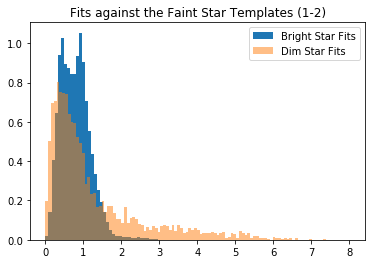

Mean Reduced Chi Squared Value for Bright Star Fits: 0.795899284291
Median Reduced Chi Squared Value for Bright Star Fits: 0.767833177883

Mean Reduced Chi Squared Value for Dim Star Fits: 1.25465228996
Median Reduced Chi Squared Value for Dim Star Fits: 0.79152748797


In [176]:
plt.hist(dm_bestChi_br12,100,normed=True,label='Bright Star Fits')
plt.hist(dm_bestChi_dm12,100,normed=True,label='Dim Star Fits',alpha=0.5)
plt.title('Fits against the Faint Star Templates (1-2)')
plt.legend()
#plt.xlim([0,10])
plt.show()
print('Mean Reduced Chi Squared Value for Bright Star Fits:',np.mean(dm_bestChi_br12))
print('Median Reduced Chi Squared Value for Bright Star Fits:', np.median(dm_bestChi_br12))
print('\nMean Reduced Chi Squared Value for Dim Star Fits:', np.mean(dm_bestChi_dm12))
print('Median Reduced Chi Squared Value for Dim Star Fits:', np.median(dm_bestChi_dm12))

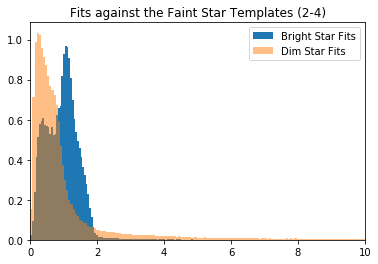

Mean Reduced Chi Squared Value for Bright Star Fits: 0.986344688176
Median Reduced Chi Squared Value for Bright Star Fits: 0.986325150242

Mean Reduced Chi Squared Value for Dim Star Fits: 1.28243276738
Median Reduced Chi Squared Value for Dim Star Fits: 0.607887761914


In [182]:
plt.hist(dm_bestChi_br24,400,normed=True,label='Bright Star Fits')
plt.hist(dm_bestChi_dm24,400,normed=True,label='Dim Star Fits',alpha=0.5)
plt.title('Fits against the Faint Star Templates (2-4)')
plt.legend()
plt.xlim([0,10])
plt.show()
print('Mean Reduced Chi Squared Value for Bright Star Fits:',np.mean(dm_bestChi_br24))
print('Median Reduced Chi Squared Value for Bright Star Fits:', np.median(dm_bestChi_br24))
print('\nMean Reduced Chi Squared Value for Dim Star Fits:', np.mean(dm_bestChi_dm24))
print('Median Reduced Chi Squared Value for Dim Star Fits:', np.median(dm_bestChi_dm24))

# CALCULATING RED X^2 VALUES FOR G-K RANGE FROM 1-2 & 2-4 USING BRIGHT STAR TEMPLATES

In [15]:
Gmags = Gmag - 5 * np.log10(Dist) + 5
GK = Gmag - Kmag
br_Gmag = []
br_GBmag = []
br_GRmag = []
br_Jmag = []
br_Hmag = []
br_Kmag = []
br_GK = []
br_G = []
for i in range(len(Gmags)):
    if(Gmags[i] < 10 and GK[i] >= 2.0 and GK[i] <= 4.0):
    #if(SNR[i] > 50):
        br_Gmag.append(Gmag[i])
        br_GBmag.append(GBmag[i])
        br_GRmag.append(GRmag[i])
        br_Jmag.append(Jmag[i])
        br_Hmag.append(Hmag[i])
        br_Kmag.append(Kmag[i])
        br_GK.append(GK[i])
        br_G.append(Gmags[i])
br_Gmag = np.array(br_Gmag)
br_GBmag = np.array(br_GBmag)
br_GRmag = np.array(br_GRmag)
br_Jmag = np.array(br_Jmag)
br_Hmag = np.array(br_Hmag)
br_Kmag = np.array(br_Kmag)
br_GK = np.array(br_GK)
br_G = np.array(br_G)
print('Length of Br_Mags:',len(br_Gmag))

dm_G = []
dm_Gmag = []
dm_GBmag = []
dm_GRmag = []
dm_Jmag = []
dm_Hmag = []
dm_Kmag = []
dm_GK = []
for i in range(len(Gmags)):
    if(Gmags[i] > 10 and GK[i] >= 2.0 and GK[i] <= 4.0):
        dm_Gmag.append(Gmag[i])
        dm_GBmag.append(GBmag[i])
        dm_GRmag.append(GRmag[i])
        dm_Jmag.append(Jmag[i])
        dm_Hmag.append(Hmag[i])
        dm_Kmag.append(Kmag[i])
        dm_GK.append(GK[i])
        dm_G.append(Gmags[i])
dm_Gmag = np.array(dm_Gmag)
dm_GBmag = np.array(dm_GBmag)
dm_GRmag = np.array(dm_GRmag)
dm_Jmag = np.array(dm_Jmag)
dm_Hmag = np.array(dm_Hmag)
dm_Kmag = np.array(dm_Kmag)
dm_GK = np.array(dm_GK)
dm_G = np.array(dm_G)
print('Length of dm_Mags:',len(dm_Gmag))

Length of Br_Mags: 214996
Length of dm_Mags: 275611


In [16]:
# CREATE TEMPLATES FOR 1-2 RANGE AND 2-4 RANGE
# ENSURE THAT THE br_Mags and dm_Mags ARE THE CORRECT COLOR RANGES
colors = np.arange(2,4,0.03) # EDIT THIS TO USE DESIRED NUMBER OF COLORS

# BUILD BRIGHT STAR TEMPLATES
color_br24 = ColorClassification(br_Gmag,br_Kmag,colors)

stars_br24,color_mags_br24,color_std_br24,color_std_err_br24,abs_color_mags_br24,abs_color_std_br24,abs_color_std_err_br24 = \
CreateTemplates(color_br24,colors,Gmags=br_Gmag,Kmags=br_Kmag,GB_mags=br_GBmag,GR_mags=br_GRmag,J_mags=br_Jmag,H_mags=br_Hmag)

# DIM STARS
#color_dm = ColorClassification(dm_Gmag,dm_Kmag,colors)

#stars_dm,color_mags_dm,color_std_dm,color_std_err_dm,abs_color_mags_dm,abs_color_std_dm,abs_color_std_err_dm = \
#CreateTemplates(color_dm,colors,dm_Gmag,dm_Kmag,GB_mags=dm_GBmag,GR_mags=dm_GRmag,J_mags=dm_Jmag,H_mags=dm_Hmag)

/astromake/opt/python/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:108: RuntimeWarning: Mean of empty slice
/astromake/opt/python/anaconda3/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1423: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/astromake/opt/python/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:111: RuntimeWarning: Mean of empty slice


In [23]:
all_brightStars24 = np.transpose(np.array([br_Gmag,br_GBmag,br_GRmag,br_Jmag,br_Hmag,br_Kmag]))
print(len(all_brightStars24))

all_dimStars24 = np.transpose(np.array([dm_Gmag,dm_GBmag,dm_GRmag,dm_Jmag,dm_Hmag,dm_Kmag]))
print(len(all_dimStars24))

214996
275611


In [13]:
# CALCULATING REDUCED X^2 VALS BY FITTING BRIGHT STARS ONTO BRIGHT STAR TEMPLATES :G-K (1-2)
br_redChi2_bright12 = []
br_bands_br12 = []
br_mags = copy.copy(color_mags_br12)
br_std = copy.copy(color_std_br12)
br_mags = br_mags[1:len(br_mags)]
br_std = br_std[1:len(br_std)]
for i in range(len(all_brightStars12)):
    starBands= np.array(all_brightStars12[i])
    starBands = starBands[~np.isnan(starBands)]
    if(len(starBands) == len(all_brightStars12[0])):
        #starBands = np.array(starBands)
        fit, new_starBand, red_Chi2 = StarFitting(starBands,br_mags,br_std)
        chi2 = red_Chi2[0]
        br_redChi2_bright12.append(chi2)
        br_bands_br12.append(starBands)
br_redChi2_bright12 = np.array(br_redChi2_bright12)
br_bands_br12 = np.array(br_bands_br12)

In [14]:
# CALCULATING REDUCED X^2 VALS BY FITTING FAINT STARS ONTO BRIGHT STAR TEMPLATES :G-K (1-2)
br_redChi2_dim12 = []
br_bands_dm12 = []
br_mags = copy.copy(color_mags_br12)
br_std = copy.copy(color_std_br12)
br_mags = br_mags[1:len(br_mags)]
br_std = br_std[1:len(br_std)]
for i in range(len(all_dimStars12)):
    starBands= np.array(all_dimStars12[i])
    starBands = starBands[~np.isnan(starBands)]
    if(len(starBands) == len(all_dimStars12[0])):
        #starBands = np.array(starBands)
        fit, new_starBand, red_Chi2 = StarFitting(starBands,br_mags,br_std)
        chi2 = red_Chi2[0]
        br_redChi2_dim12.append(chi2)
        br_bands_dm12.append(starBands)
br_redChi2_dim12 = np.array(br_redChi2_dim12)
br_bands_dm12 = np.array(br_bands_dm12)

In [24]:
# CALCULATING REDUCED X^2 VALS BY FITTING BRIGHT STARS ONTO BRIGHT STAR TEMPLATES :G-K (2-4)
br_redChi2_bright24 = []
br_bands_br24 = []
br_mags = copy.copy(color_mags_br24)
br_std = copy.copy(color_std_br24)
br_mags = br_mags[1:len(br_mags)]
br_std = br_std[1:len(br_std)]
for i in range(len(all_brightStars24)):
    starBands= np.array(all_brightStars24[i])
    starBands = starBands[~np.isnan(starBands)]
    if(len(starBands) == len(all_brightStars24[0])):
        #starBands = np.array(starBands)
        fit, new_starBand, red_Chi2 = StarFitting(starBands,br_mags,br_std)
        chi2 = red_Chi2[0]
        br_redChi2_bright24.append(chi2)
        br_bands_br24.append(starBands)
br_redChi2_bright24 = np.array(br_redChi2_bright24)
br_bands_br24 = np.array(br_bands_br24)

In [26]:
# CALCULATING REDUCED X^2 VALS BY FITTING FAINT STARS ONTO BRIGHT STAR TEMPLATES :G-K (2-4)
br_redChi2_dim24 = []
br_bands_dm24 = []
br_mags = copy.copy(color_mags_br24)
br_std = copy.copy(color_std_br24)
br_mags = br_mags[1:len(br_mags)]
br_std = br_std[1:len(br_std)]
for i in range(len(all_dimStars24)):
    starBands= np.array(all_dimStars24[i])
    starBands = starBands[~np.isnan(starBands)]
    if(len(starBands) == len(all_dimStars24[0])):
        #starBands = np.array(starBands)
        fit, new_starBand, red_Chi2 = StarFitting(starBands,br_mags,br_std)
        chi2 = red_Chi2[0]
        br_redChi2_dim24.append(chi2)
        br_bands_dm24.append(starBands)
br_redChi2_dim24 = np.array(br_redChi2_dim24)
br_bands_dm24 = np.array(br_bands_dm24)

In [29]:
# CREATING BETTER BRIGHT STAR TEMPLATES AND REFITTING THE FAINT AND BRIGHT STARS TO THEM BY REMOVING
#                                                                                      SPURIOUS DATA

better_brBands_br12 = []
better_dmBands_br12 = []
for i in range(len(br_bands_br12)):
    if(br_redChi2_bright12[i] <= 5.0):
        better_brBands_br12.append(br_bands_br12[i])
for i in range(len(br_bands_dm12)):    
    if(br_redChi2_dim12[i] <= 5.0):
        better_dmBands_br12.append(br_bands_dm12[i])
better_brBands_br12 = np.array(better_brBands_br12)
better_dmBands_br12 = np.array(better_dmBands_br12)
print('Finished Part 1\n')       
colors = np.arange(1,2,0.03) # EDIT THIS TO USE DESIRED NUMBER OF COLORS

# BRIGHT STARS
bestColor_br12 = ColorClassification(better_brBands_br12[:,0],better_brBands_br12[:,5],colors)

bestStars_br12,bestColor_mags_br12,bestColor_std_br12,bestColor_std_err_br12,best_abs_color_mags_br12, \
best_abs_color_std_br12,best_abs_color_std_err_br12 = \
CreateTemplates(bestColor_br12,colors,Gmags=better_brBands_br12[:,0],Kmags=better_brBands_br12[:,5],\
                GB_mags=better_brBands_br12[:,1],GR_mags=better_brBands_br12[:,2],J_mags=better_brBands_br12[:,3],\
                H_mags=better_brBands_br12[:,4])

# DIM STARS
# best_color_dm12 = ColorClassification(better_dmBands12[:,0],better_dmBands12[:,5],colors)

# best_stars_dm12,best_color_mags_dm12,best_color_std_dm12,best_color_std_err_dm12,best_abs_color_mags_dm12,\
# best_abs_color_std_dm12,best_abs_color_std_err_dm12 = \
# CreateTemplates(best_color_dm12,colors,Gmags=better_dmBands12[:,0],Kmags=better_dmBands12[:,5],\
#                 GB_mags=better_dmBands12[:,1],GR_mags=better_dmBands12[:,2],J_mags=better_dmBands12[:,3],\
#                 H_mags=better_dmBands12[:,4])

print('Finished part 2\n')

br_bestChi_br12 = []
br_mags = copy.copy(bestColor_mags_br12)
br_std = copy.copy(bestColor_std_br12)
br_mags = br_mags[1:len(br_mags)]
br_std = br_std[1:len(br_std)]
for i in range(len(better_brBands_br12)):
    starBands= np.array(better_brBands_br12[i])
    starBands = starBands[~np.isnan(starBands)]
    if(len(starBands) == len(better_brBands_br12[0])):
        #starBands = np.array(starBands)
        fit, new_starBand, red_Chi2 = StarFitting(starBands,br_mags,br_std)
        chi2 = red_Chi2[0]
        br_bestChi_br12.append(chi2)
        
br_bestChi_br12 = np.array(br_bestChi_br12)

print('Finished part 3\n')

br_bestChi_dm12 = []
br_mags = copy.copy(bestColor_mags_br12)
br_std = copy.copy(bestColor_std_br12)
br_mags = br_mags[1:len(br_mags)]
br_std = br_std[1:len(br_std)]
for i in range(len(better_dmBands_br12)):
    starBands= np.array(better_dmBands_br12[i])
    starBands = starBands[~np.isnan(starBands)]
    if(len(starBands) == len(better_dmBands_br12[0])):
        #starBands = np.array(starBands)
        fit, new_starBand, red_Chi2 = StarFitting(starBands,br_mags,br_std)
        chi2 = red_Chi2[0]
        br_bestChi_dm12.append(chi2)
        
br_bestChi_dm12 = np.array(br_bestChi_dm12)



Finished Part 1



/astromake/opt/python/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:108: RuntimeWarning: Mean of empty slice
/astromake/opt/python/anaconda3/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1423: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/astromake/opt/python/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:111: RuntimeWarning: Mean of empty slice


Finished part 2

Finished part 3



In [34]:
# CREATING BETTER BRIGHT STAR TEMPLATES AND REFITTING THE FAINT AND BRIGHT STARS TO THEM BY REMOVING
#          (2-4)                                                                            SPURIOUS DATA

better_brBands_br24 = []
better_dmBands_br24 = []
for i in range(len(br_bands_br24)):
    if(br_redChi2_bright24[i] <= 5.0):
        better_brBands_br24.append(br_bands_br24[i])
for i in range(len(br_bands_dm24)):    
    if(br_redChi2_dim24[i] <= 5.0):
        better_dmBands_br24.append(br_bands_dm24[i])
better_brBands_br24 = np.array(better_brBands_br24)
better_dmBands_br24 = np.array(better_dmBands_br24)
print('Finished Part 1\n')       
colors = np.arange(2,4,0.03) # EDIT THIS TO USE DESIRED NUMBER OF COLORS

# BRIGHT STARS
bestColor_br24 = ColorClassification(better_brBands_br24[:,0],better_brBands_br24[:,5],colors)

bestStars_br24,bestColor_mags_br24,bestColor_std_br24,bestColor_std_err_br24,best_abs_color_mags_br24, \
best_abs_color_std_br24,best_abs_color_std_err_br24 = \
CreateTemplates(bestColor_br24,colors,Gmags=better_brBands_br24[:,0],Kmags=better_brBands_br24[:,5],\
                GB_mags=better_brBands_br24[:,1],GR_mags=better_brBands_br24[:,2],J_mags=better_brBands_br24[:,3],\
                H_mags=better_brBands_br24[:,4])

# DIM STARS
# best_color_dm12 = ColorClassification(better_dmBands12[:,0],better_dmBands12[:,5],colors)

# best_stars_dm12,best_color_mags_dm12,best_color_std_dm12,best_color_std_err_dm12,best_abs_color_mags_dm12,\
# best_abs_color_std_dm12,best_abs_color_std_err_dm12 = \
# CreateTemplates(best_color_dm12,colors,Gmags=better_dmBands12[:,0],Kmags=better_dmBands12[:,5],\
#                 GB_mags=better_dmBands12[:,1],GR_mags=better_dmBands12[:,2],J_mags=better_dmBands12[:,3],\
#                 H_mags=better_dmBands12[:,4])

print('Finished part 2\n')

br_bestChi_br24 = []
br_mags = copy.copy(bestColor_mags_br24)
br_std = copy.copy(bestColor_std_br24)
br_mags = br_mags[1:len(br_mags)]
br_std = br_std[1:len(br_std)]
for i in range(len(better_brBands_br24)):
    starBands= np.array(better_brBands_br24[i])
    starBands = starBands[~np.isnan(starBands)]
    if(len(starBands) == len(better_brBands_br24[0])):
        #starBands = np.array(starBands)
        fit, new_starBand, red_Chi2 = StarFitting(starBands,br_mags,br_std)
        chi2 = red_Chi2[0]
        br_bestChi_br24.append(chi2)
        
br_bestChi_br24 = np.array(br_bestChi_br24)

print('Finished part 3\n')

br_bestChi_dm24 = []
br_mags = copy.copy(bestColor_mags_br24)
br_std = copy.copy(bestColor_std_br24)
br_mags = br_mags[1:len(br_mags)]
br_std = br_std[1:len(br_std)]
for i in range(len(better_dmBands_br24)):
    starBands= np.array(better_dmBands_br24[i])
    starBands = starBands[~np.isnan(starBands)]
    if(len(starBands) == len(better_dmBands_br24[0])):
        #starBands = np.array(starBands)
        fit, new_starBand, red_Chi2 = StarFitting(starBands,br_mags,br_std)
        chi2 = red_Chi2[0]
        br_bestChi_dm24.append(chi2)
        
br_bestChi_dm24 = np.array(br_bestChi_dm24)

print('Finished Final Part')

Finished Part 1



/astromake/opt/python/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:108: RuntimeWarning: Mean of empty slice
/astromake/opt/python/anaconda3/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1423: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/astromake/opt/python/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:111: RuntimeWarning: Mean of empty slice


Finished part 2

Finished part 3

Finished Final Part


# Red X^2 Distributions for G-K 1-2 & 2-4 for Bright and Faint Stars Fitted to Bright Star Templates

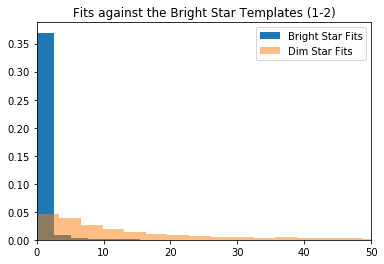

Mean Reduced Chi Squared Value for Bright Star Fits: 1.16627829519
Median Reduced Chi Squared Value for Bright Star Fits: 0.54009330752

Mean Reduced Chi Squared Value for Dim Star Fits: 76.6916690886
Median Reduced Chi Squared Value for Dim Star Fits: 18.8141061327


In [21]:
plt.hist(br_redChi2_bright12,300,normed=True,label='Bright Star Fits')
plt.hist(br_redChi2_dim12,300,normed=True,label='Dim Star Fits',alpha=0.5)
plt.title('Fits against the Bright Star Templates (1-2)')
plt.legend()
plt.xlim([0,50])
plt.show()
print('Mean Reduced Chi Squared Value for Bright Star Fits:',np.mean(br_redChi2_bright12))
print('Median Reduced Chi Squared Value for Bright Star Fits:', np.median(br_redChi2_bright12))
print('\nMean Reduced Chi Squared Value for Dim Star Fits:', np.mean(br_redChi2_dim12))
print('Median Reduced Chi Squared Value for Dim Star Fits:', np.median(br_redChi2_dim12))

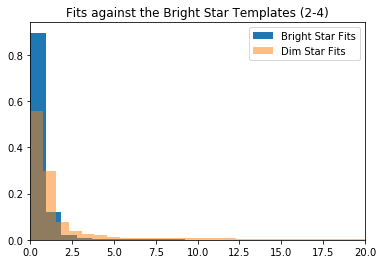

Mean Reduced Chi Squared Value for Bright Star Fits: 1.13089682361
Median Reduced Chi Squared Value for Bright Star Fits: 0.481023871457

Mean Reduced Chi Squared Value for Dim Star Fits: 9.62710408453
Median Reduced Chi Squared Value for Dim Star Fits: 0.900935030777


In [28]:
plt.hist(br_redChi2_bright24,1000,normed=True,label='Bright Star Fits')
plt.hist(br_redChi2_dim24,1000,normed=True,label='Dim Star Fits',alpha=0.5)
plt.title('Fits against the Bright Star Templates (2-4)')
plt.legend()
plt.xlim([0,20])
plt.show()
print('Mean Reduced Chi Squared Value for Bright Star Fits:',np.mean(br_redChi2_bright24))
print('Median Reduced Chi Squared Value for Bright Star Fits:', np.median(br_redChi2_bright24))
print('\nMean Reduced Chi Squared Value for Dim Star Fits:', np.mean(br_redChi2_dim24))
print('Median Reduced Chi Squared Value for Dim Star Fits:', np.median(br_redChi2_dim24))

79362
896


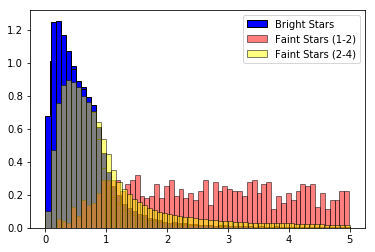

Mean Reduced Chi Squared for Bright Stars (1-2): 0.662684243124
Median Reduced Chi Squared for Bright Stars (1-2): 0.525656355562
STD of Reduced Chi Squared for Bright Stars (1-2): 0.605526033391

Mean Reduced Chi Squared for Dim Stars (1-2): 2.66316969142
Median Reduced Chi Squared for Dim Stars (1-2): 2.62787544507
STD of Reduced Chi Squared for Dim Stars (1-2): 1.2816600833

Mean Reduced Chi Squared for Bright Stars (2-4): 0.601679540958
Median Reduced Chi Squared for Bright Stars (2-4): 0.469301739422
STD of Reduced Chi Squared for Bright Stars (2-4): 0.582101671261

Mean Reduced Chi Squared for Dim Stars (2-4): 0.981117281218
Median Reduced Chi Squared for Dim Stars (2-4): 0.709168958498
STD of Reduced Chi Squared for Dim Stars (2-4): 0.900085442642


In [33]:
better_br2_12 = []
better_dim2_12 = []
for i in range(len(br_redChi2_bright12)):
    if(br_redChi2_bright12[i] <= 5.0):
        better_br2_12.append(br_redChi2_bright12[i])
for i in range(len(br_redChi2_dim12)):    
    if(br_redChi2_dim12[i] <= 5.0):
        better_dim2_12.append(br_redChi2_dim12[i])
print(len(better_br2_12))
print(len(better_dim2_12))
better_br2_24 = []
better_dim2_24 = []
for i in range(len(br_redChi2_bright24)):
    if(br_redChi2_bright24[i] <= 5.0):
        better_br2_24.append(br_redChi2_bright24[i])
for i in range(len(br_redChi2_dim24)):    
    if(br_redChi2_dim24[i] <= 5.0):
        better_dim2_24.append(br_redChi2_dim24[i])
        
plt.hist(better_br2_12,60,normed=True,alpha=1.0,label='Bright Stars',color='blue',edgecolor='black')
plt.hist(better_br2_24,60,normed=True,alpha=1.0,color='blue',edgecolor='black')
plt.hist(better_dim2_12,60,normed=True,alpha=0.5,label='Faint Stars (1-2)',color='red',edgecolor='black')
plt.hist(better_dim2_24,60,normed=True,alpha=0.5,label='Faint Stars (2-4)',color='yellow',edgecolor='black')
#plt.xlim([0,30])
plt.legend()
plt.show()
print('Mean Reduced Chi Squared for Bright Stars (1-2):',np.mean(better_br2_12))
print('Median Reduced Chi Squared for Bright Stars (1-2):',np.median(better_br2_12))
print('STD of Reduced Chi Squared for Bright Stars (1-2):', np.std(better_br2_12))

print('\nMean Reduced Chi Squared for Dim Stars (1-2):',np.mean(better_dim2_12))
print('Median Reduced Chi Squared for Dim Stars (1-2):',np.median(better_dim2_12))
print('STD of Reduced Chi Squared for Dim Stars (1-2):', np.std(better_dim2_12))

print('\nMean Reduced Chi Squared for Bright Stars (2-4):',np.mean(better_br2_24))
print('Median Reduced Chi Squared for Bright Stars (2-4):',np.median(better_br2_24))
print('STD of Reduced Chi Squared for Bright Stars (2-4):', np.std(better_br2_24))

print('\nMean Reduced Chi Squared for Dim Stars (2-4):',np.mean(better_dim2_24))
print('Median Reduced Chi Squared for Dim Stars (2-4):',np.median(better_dim2_24))
print('STD of Reduced Chi Squared for Dim Stars (2-4):', np.std(better_dim2_24))


# REDUCED X^2 DISTRIBUTIONS AFTER REMOVING SPURIOUS DATA FOR G-K 1-2 AND 2-4. USING FAINT STAR TEMPLATES

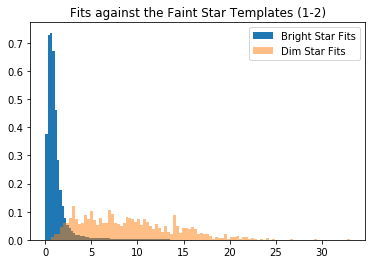

Mean Reduced Chi Squared Value for Bright Star Fits: 1.20904647204
Median Reduced Chi Squared Value for Bright Star Fits: 0.81125093701

Mean Reduced Chi Squared Value for Dim Star Fits: 8.98820373502
Median Reduced Chi Squared Value for Dim Star Fits: 8.33438132506


In [30]:
plt.hist(br_bestChi_br12,100,normed=True,label='Bright Star Fits')
plt.hist(br_bestChi_dm12,100,normed=True,label='Dim Star Fits',alpha=0.5)
plt.title('Fits against the Bright Star Templates (1-2)')
plt.legend()
#plt.xlim([0,10])
plt.show()
print('Mean Reduced Chi Squared Value for Bright Star Fits:',np.mean(br_bestChi_br12))
print('Median Reduced Chi Squared Value for Bright Star Fits:', np.median(br_bestChi_br12))
print('\nMean Reduced Chi Squared Value for Dim Star Fits:', np.mean(br_bestChi_dm12))
print('Median Reduced Chi Squared Value for Dim Star Fits:', np.median(br_bestChi_dm12))

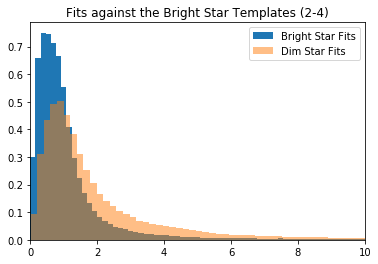

Mean Reduced Chi Squared Value for Bright Star Fits: 1.19062558928
Median Reduced Chi Squared Value for Bright Star Fits: 0.790587463418

Mean Reduced Chi Squared Value for Dim Star Fits: 2.13935138907
Median Reduced Chi Squared Value for Dim Star Fits: 1.31784275806


In [37]:
plt.hist(br_bestChi_br24,200,normed=True,label='Bright Star Fits')
plt.hist(br_bestChi_dm24,200,normed=True,label='Dim Star Fits',alpha=0.5)
plt.title('Fits against the Bright Star Templates (2-4)')
plt.legend()
plt.xlim([0,10])
plt.show()
print('Mean Reduced Chi Squared Value for Bright Star Fits:',np.mean(br_bestChi_br24))
print('Median Reduced Chi Squared Value for Bright Star Fits:', np.median(br_bestChi_br24))
print('\nMean Reduced Chi Squared Value for Dim Star Fits:', np.mean(br_bestChi_dm24))
print('Median Reduced Chi Squared Value for Dim Star Fits:', np.median(br_bestChi_dm24))

# Red X^2 Distributions for Faint and Bright Stars Fitted onto Faint Star Templates for G-K 1-4 

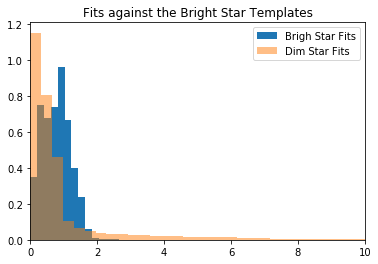

Mean Reduced Chi Squared Value for Bright Star Fits: 0.830767690887
Median Reduced Chi Squared Value for Bright Star Fits: 0.803300870614

Mean Reduced Chi Squared Value for Dim Star Fits: 1.36912625557
Median Reduced Chi Squared Value for Dim Star Fits: 0.467066145204


In [270]:
plt.hist(dm_redChi2_bright,1000,normed=True,label='Bright Star Fits')
plt.hist(dm_redChi2_dim,1000,normed=True,label='Dim Star Fits',alpha=0.5)
plt.title('Fits against the Faint Star Templates')
plt.legend()
plt.xlim([0,10])
plt.show()
print('Mean Reduced Chi Squared Value for Bright Star Fits:',np.mean(dm_redChi2_bright))
print('Median Reduced Chi Squared Value for Bright Star Fits:', np.median(dm_redChi2_bright))
print('\nMean Reduced Chi Squared Value for Dim Star Fits:', np.mean(dm_redChi2_dim))
print('Median Reduced Chi Squared Value for Dim Star Fits:', np.median(dm_redChi2_dim))

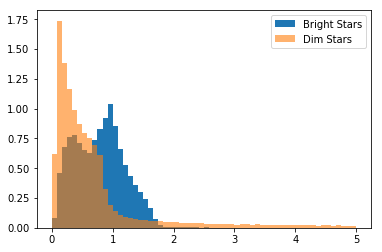

Mean Reduced Chi Squared for Bright Stars: 0.796385656988
Median Reduced Chi Squared for Bright Stars: 0.802159732744
STD of Reduced Chi Squared for Bright Stars: 0.429127706535
Standard Error for Bright Stars: 0.000789494244459

Mean Reduced Chi Squared for Dim Stars: 0.706515295719
Median Reduced Chi Squared for Dim Stars: 0.428906683954
STD of Reduced Chi Squared for Dim Stars: 0.882621010399
Standard Error for Dim Stars: 0.00172913428766


In [272]:
better_br_2 = []
better_dim_2 = []
for i in range(len(dm_redChi2_bright)):
    if(dm_redChi2_bright[i] <= 5.0):
        better_br_2.append(dm_redChi2_bright[i])
for i in range(len(dm_redChi2_dim)):    
    if(dm_redChi2_dim[i] <= 5.0):
        better_dim_2.append(dm_redChi2_dim[i])

plt.hist(better_br_2,60,normed=True,alpha=1.0,label='Bright Stars')
plt.hist(better_dim_2,60,normed=True,alpha=0.6,label='Dim Stars')
#plt.xlim([0,30])
plt.legend()
plt.show()
print('Mean Reduced Chi Squared for Bright Stars:',np.mean(better_br_2))
print('Median Reduced Chi Squared for Bright Stars:',np.median(better_br_2))
print('STD of Reduced Chi Squared for Bright Stars:', np.std(better_br_2))
print('Standard Error for Bright Stars:', np.std(better_br_2)/np.sqrt(len(better_br_2)))
print('\nMean Reduced Chi Squared for Dim Stars:',np.mean(better_dim_2))
print('Median Reduced Chi Squared for Dim Stars:',np.median(better_dim_2))
print('STD of Reduced Chi Squared for Dim Stars:', np.std(better_dim_2))
print('Standard Error for Dim Stars:', np.std(better_dim_2)/np.sqrt(len(better_dim_2)))

# ** BELOW: Subtracting the Two Templates and Comparing Standard Error to Difference Value **

[        nan         nan -0.50957551         nan         nan  0.64622905
         nan  1.43695642  1.90810059  2.01499574]


In [83]:
mags_br = copy.copy(color_mags_br)
std_err_br = copy.copy(color_std_err_br)
mags_dm = copy.copy(color_mags_dm)
std_err_dm = copy.copy(color_std_err_dm)
mags_br = mags_br[1:len(mags_br)]
mags_dm = mags_dm[1:len(mags_dm)]
std_err_br = std_err_br[1:len(std_err_br)]
std_err_dm = std_err_dm[1:len(std_err_dm)]


magDiff = []
GBdiff = []
GRdiff = []
Jdiff = []
Hdiff = []
Kdiff = []
# for i in range(len(mags_br)):
#     br = mags_br[i]
#     br = br[~np.isnan(br)]
#     dm = mags_dm
#     mags_dm[i] = mags_dm[i][~np.isnan(mags_dm[i])]
#     magDiff.append(mags_br[i] - mags_dm[i])
    
    
# for i in range(len(magDiff)):
#     GBdiff.append(magDiff[0])
#     GRdiff.append(magDiff[1])
#     Jdiff.append(magDiff[2])
#     Hdiff.append(magDiff[3])
#     Kdiff.append(magDiff[4])

# sumErr = []
# for i in range(len(std_err_br)):
#     std_err_br[i] = std_err_br[i][~np.isnan(std_err_br[i])]
#     std_err_dm[i] = std_err_dm[i][~np.isnan(std_err_dm[i])]
    
#     sumErr.append(std_err_br[i] + std_err_dm[i])
        

magDiff = np.array(abs(mags_br - mags_dm))
sumErr = np.array(std_err_dm + std_err_br)
#sumErr = np.array((std_err_br))
#sumErr = np.array(np.sqrt(std_err_dm) + np.sqrt(std_err_br))

GB_error = []
GR_error = []
J_error = []
H_error = []
K_error = []

for i in range(len(sumErr)):
    er = sumErr[i]
    er = er[~np.isnan(er)]
    GB_error.append((er[0]))
    GR_error.append((er[1]))
    J_error.append((er[2]))
    H_error.append((er[3]))
    K_error.append((er[4]))


for i in range(len(magDiff)):
    diffs = magDiff[i]
    diffs = diffs[~np.isnan(diffs)]
    GBdiff.append(diffs[0])
    GRdiff.append(diffs[1])
    Jdiff.append(diffs[2])
    Hdiff.append(diffs[3])
    Kdiff.append(diffs[4])
    


# for i in range(len(sumErr)):
#     er = sumErr[i]
#     er = er[~np.isnan(er)]
#     GB_error.append(er[0])
#     GR_error.append(er[1])
#     J_error.append(er[2])
#     H_error.append(er[3])
#     K_error.append(er[4])
    
DiffResults = np.array([[GBdiff,GB_error],[GRdiff,GR_error],[Jdiff,J_error],[Hdiff,H_error],[Kdiff,K_error]])    
#print(GBdiff[1],GB_error[1])
GB = np.transpose(DiffResults[0])
GR = np.transpose(DiffResults[1])
J = np.transpose(DiffResults[2])
H = np.transpose(DiffResults[3])
K = np.transpose(DiffResults[4])



In [84]:
GB_r = GB[:,0] - GB[:,1]
GR_r = GR[:,0] - GR[:,1]
J_r = J[:,0] - J[:,1]
H_r = H[:,0] - H[:,1]
K_r = K[:,0] - K[:,1]
# x[x >= 0]
GB_pos = GB_r[GB_r>=0]
GR_pos = GR_r[GR_r>=0]
J_pos = J_r[J_r>=0]
H_pos = H_r[H_r>=0]
K_pos = K_r[K_r>=0]

print('Percentage of GB band Being Significantly Different:',100*(len(GB_pos)/len(GB_r)))
print('Percentage of GR band Being Significantly Different:',100*(len(GR_pos)/len(GR_r)))
print('Percentage of J band Being Significantly Different:',100*(len(J_pos)/len(J_r)))
print('Percentage of H band Being Significantly Different:',100*(len(H_pos)/len(H_r)))
print('Percentage of K band Being Significantly Different:',100*(len(K_pos)/len(K_r)))

Percentage of GB band Being Significantly Different: 100.0
Percentage of GR band Being Significantly Different: 100.0
Percentage of J band Being Significantly Different: 100.0
Percentage of H band Being Significantly Different: 72.72727272727273
Percentage of K band Being Significantly Different: 72.72727272727273


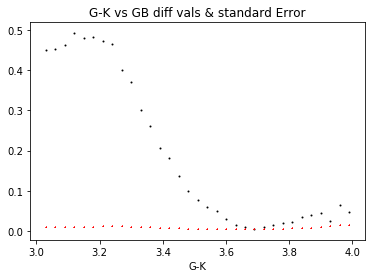

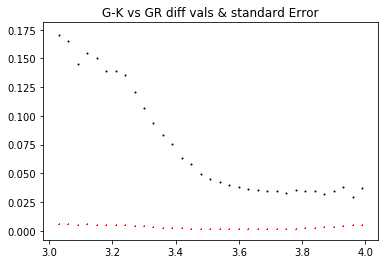

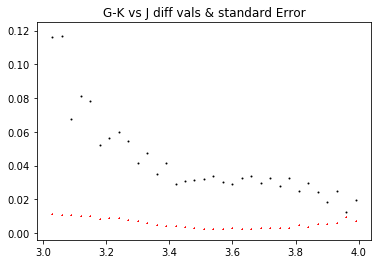

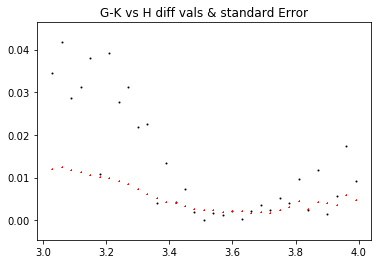

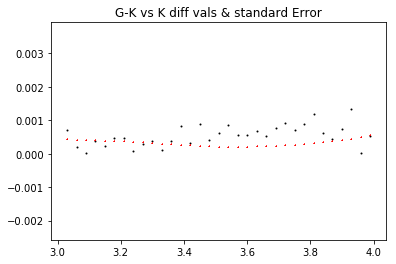

In [85]:
plt.scatter(colors[1:len(colors)],GB[:,0],c='k',s=1.0,label='Difference')
plt.scatter(colors[1:len(colors)],GB[:,1],c='r',s=1.0,marker='+',label='Standard Error')
plt.title('G-K vs GB diff vals & standard Error')
plt.xlabel('G-K')
plt.show()

plt.scatter(colors[1:len(colors)],GR[:,0],c='k',s=1.0,label='Difference')
plt.scatter(colors[1:len(colors)],GR[:,1],c='r',s=1.0,marker='+',label='Standard Error')
plt.title('G-K vs GR diff vals & standard Error')
plt.show()

plt.scatter(colors[1:len(colors)],J[:,0],c='k',s=1.0,label='Difference')
plt.scatter(colors[1:len(colors)],J[:,1],c='r',s=1.0,marker='+',label='Standard Error')
plt.title('G-K vs J diff vals & standard Error')
plt.show()

plt.scatter(colors[1:len(colors)],H[:,0],c='k',s=1.0,label='Difference')
plt.scatter(colors[1:len(colors)],H[:,1],c='r',s=1.0,marker='+',label='Standard Error')
plt.title('G-K vs H diff vals & standard Error')
plt.show()

plt.scatter(colors[1:len(colors)],K[:,0],c='k',s=1.0,label='Difference')
plt.scatter(colors[1:len(colors)],K[:,1],c='r',s=1.0,marker='+',label='Standard Error')
plt.title('G-K vs K diff vals & standard Error')
plt.show()

In [62]:
a = [1,1,1,1,1,1]
b = [2,2,2,2,2,2]
c = [3,3,3,3,3,3]
d = [4,4,4,4,4,4]
e = [5,5,5,5,5,5]
f = [6,6,6,6,6,6]

n = np.array([[a,b],[c,d],[e,f]])
t = np.transpose(n)
print(np.transpose(n[0]))
#print(GB)

[[1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]
 [1 2]]


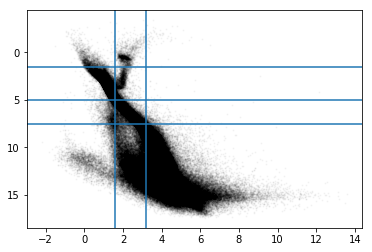

In [274]:
# Dist = 1000./plx


# GK = Gmag - Kmag
# Gmags = Gmag - 5 * np.log10(Dist) + 5

# new_Gmag = []
# for i in range(len(Gmags)):
#     if(Gmags[i] < 9):
#         new_Gmag.append(Gmag[i])
plt.scatter(GK,Gmags,s=1.0,alpha=0.03,c='k')
plt.gca().invert_yaxis()
plt.axhline(1.5)
plt.axvline(3.2)
plt.axvline(1.6)

plt.axhline(5)
plt.axhline(7.5)
plt.show()

#for i in range(len(Gmags)):
GiantStars = []
MS_stars = []
for i in range(len(Gmags)):
    if(Gmags[i] <= 1.5 and GK[i] >=1.6 and GK[i] <= 3.2):
        
        GiantStars.append([Gmag[i],GBmag[i],GRmag[i],Jmag[i],Hmag[i],Kmag[i]])
    if(Gmags[i] >= 5 and Gmags[i]<=7.5 and GK[i] >= 1.6 and GK[i] <= 3.2):
        MS_stars.append([Gmag[i],GBmag[i],GRmag[i],Jmag[i],Hmag[i],Kmag[i]])
GiantStars = np.array(GiantStars)
MS_stars = np.array(MS_stars)

In [281]:
colors = np.arange(1.6,3.2,0.03) # EDIT THIS TO USE DESIRED NUMBER OF COLORS
#color = ColorClassification(new_Gmag,new_Kmag,colors)
color_G = ColorClassification(GiantStars[:,0],GiantStars[:,5],colors)


stars_G,color_mags_G,color_std_G,color_std_err_G,abs_color_mags,abs_color_std,abs_color_std_err = \
CreateTemplates(color,colors,GiantStars[:,0],GiantStars[:,5],GB_mags=GiantStars[:,1],GR_mags=GiantStars[:,2],J_mags=GiantStars[:,3],H_mags=GiantStars[:,4])

/astromake/opt/python/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:108: RuntimeWarning: Mean of empty slice
/astromake/opt/python/anaconda3/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1423: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/astromake/opt/python/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:111: RuntimeWarning: Mean of empty slice


In [298]:
print(GiantStars[0])
print(all_starBands[0])

[ 5.73735571  6.29967976  5.1195364   4.31799984  3.71099997  3.71000004]
[ 10.02853012  10.37783909   9.54774475   8.99300003   8.68599987
   8.65100002]


In [296]:
G_Chi2 = []
for i in range(len(GiantStars)):
    g_star = GiantStars[i]
    g_star = g_star[~np.isnan(g_star)]
    fit, new_g_starBand, red_Chi2 = StarFitting(g_star,color_mags_G,color_std_G)
    G_Chi2.append(red_Chi2[0])

IndexError: too many indices for array

In [299]:
colors = np.arange(1.6,3.2,0.03) # EDIT THIS TO USE DESIRED NUMBER OF COLORS
#color = ColorClassification(new_Gmag,new_Kmag,colors)
color_MS = ColorClassification(MS_stars[:,0],MS_stars[:,5],colors)


stars_MS,color_mags_MS,color_std_MS,color_std_err_MS,abs_color_mags,abs_color_std,abs_color_std_err = \
CreateTemplates(color_MS,colors,MS_stars[:,0],MS_stars[:,5],GB_mags=MS_stars[:,1],GR_mags=MS_stars[:,2],J_mags=MS_stars[:,3],H_mags=MS_stars[:,4])

/astromake/opt/python/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:108: RuntimeWarning: Mean of empty slice
/astromake/opt/python/anaconda3/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1423: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/astromake/opt/python/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:111: RuntimeWarning: Mean of empty slice


In [301]:
MS_Chi2 = []
for i in range(len(MS_stars)):
    ms_star = MS_stars[i]
    ms_star = ms_star[~np.isnan(ms_star)]
    fit, new_ms_starBand, red_Chi2 = StarFitting(ms_star,color_mags_MS,color_std_MS)
    G_Chi2.append(red_Chi2[0])

IndexError: too many indices for array

# Comparing Templates (All stars & Stars: > 10 G abs

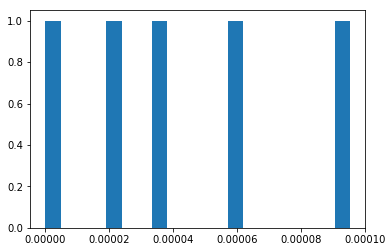

In [343]:
Diff_temps = []
for i in range(len(color_mags)):
    all_stars = color_mags[i]
    all_stars = all_stars[~np.isnan(all_stars)]
    bright_stars = color_mags_br[i]
    bright_stars = bright_stars[~np.isnan(bright_stars)]
    Diff_temps.append(all_stars - bright_stars)
Diff_temps = np.array(Diff_temps)

sum_error = []
for i in range(len(color_std_err)):
    sum_ = []
    all_stars_er = color_std[i]
    all_stars_er = all_stars_er[~np.isnan(all_stars_er)]
    bright_stars_er = color_std_br[i]
    bright_stars_er = bright_stars_er[~np.isnan(bright_stars_er)]
    for j in range(len(all_stars_er)):
        sum_.append(np.sum([all_stars_er[j],bright_stars_er[j]]))
    sum_error.append(sum_)
sum_error = np.array(sum_error)   


compChi = Diff_temps**2/(sum_error)**2
compChi = compChi/(len(Diff_temps)-1)
plt.hist(compChi[4],20)
plt.show()